# Notebook 2
==================================================================================

# Modeling Returns using Fundamentals
In the last notebook, the fundamentals data scraped from TD Ameritrade's were used to regress the current trading price of the securities, in order to attempt a value investor-style trading strategy in which the residuals of the model were treated as Margins of Safety for directional bets. For the time period studied, this method did not prove to be effective. Although the models were quite effective in regressing the prices, the residuals did not have any linear relationship with the returns of the securities over the last 6 months.

In this notebook, the actual returns of the securities over the 6 month period will be used as the target variable, to evaluate the predictive power of the scraped fundamental data. Two versions of the target will be tested: one which is simply the raw returns, and a second which represents the excess returns compared to the SP500 index as a whole. The latter target may be lead to a more robust model for future deployment, as the market may move up or down over any given time period, which is an unavoidable risk that an investor takes, but that investor would prefer to have chosen securities which outperform the market. Further, if the model is successful in identifying outperforming and underperforming stocks, the investor could construct a long/short portfolio, which longs the stocks with the best and shorts the stocks with the worst predicted performance in equal dollar values, in order to hedge themselves against the overall movement of the market, in order to achieve a market neutral strategy.

The first round of modeling will attempt to regress the returns. Then, in a second round of modeling, the efficacy of the regression will be compared to categorizing the returns and performing classification instead. These two rounds of modeling will be repeated before and after multicollinearity is removed from the dataset to compare results.

## Outline
[Import Step](#import)<br>
[Data Exploration](#exploration)<br>
[Modeling](#modeling)<br>
- [Regression 1](#regression1)<br>
- [Classification 1](#classification1)<br>
- [Removing Multicollinearity](#removing_multicollinearity)<br>
- [Regression 2](#regression2)<br>
- [Classification 2](#classification2)<br></ul>
[Conclusions](#conclusions)

<a id='import'></a>
### Importing Libraries and Data

In [1]:
import bot_functions as bf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import yfinance as yf

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [309]:
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_curve

In [2]:
plt.style.use('seaborn-darkgrid')

In [3]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 11, 7

In [4]:
# First, let's get the list of tickers used in the scrape to get target variables for
sp500_tickers = pd.read_csv('sp500.csv', usecols=[1])
sp500_tickers.head()

Symbol
0      A
1    AAL
2    AAP
3   AAPL
4   ABBV

In [5]:
sp500_tickers.tail()

Symbol
498    YUM
499    ZBH
500   ZBRA
501   ZION
502    ZTS

In [6]:
print(len(sp500_tickers))

503


In [7]:
# Finding odd entries in tickers list, these tickers do not have data from the scrape and do not
# work with yfinance
bad_tickers = []
for ticker in sp500_tickers.Symbol:
    if '.' in ticker:
        print(ticker)
        bad_tickers.append(ticker)

BF.B
BRK.B


In [8]:
sp500_tickers = sp500_tickers[~sp500_tickers.Symbol.isin(bad_tickers)]['Symbol']
print(len(sp500_tickers))

501


Now that we have our tickers, we can set about getting pricing information with yfinance. We will only need to concern ourselves with closing prices for our purposes.

In [9]:
# Setting start and end dates. The web scrape was done on Friday, 2020-05-08, the end date to be
# used for this project is Friday, 2020-10-30
start_date = '2020-05-08'
end_date = '2020-10-30'
# yfinance likes the tickers formatted as a list
ticks = yf.Tickers(list(sp500_tickers))
sp500_close = ticks.history(start=start_date, end=end_date).Close
sp500_close.tail()

[*********************100%***********************]  501 of 501 completed

1 Failed download:
- AGN: No data found, symbol may be delisted


A    AAL         AAP        AAPL       ABBV        ABC  \
Date                                                                          
2020-10-26  104.629997  11.80  151.210007  114.851852  83.919998  97.962059   
2020-10-27  106.040001  11.23  150.410004  116.399178  82.709999  97.245041   
2020-10-28  101.660004  10.95  146.380005  111.008476  80.489998  95.303123   
2020-10-29  102.019997  11.16  146.000000  115.121384  80.669998  94.197723   
2020-10-30         NaN    NaN         NaN         NaN        NaN        NaN   

                  ABMD         ABT         ACN        ADBE  ...        XLNX  \
Date                                                        ...               
2020-10-26  288.320007  109.000000  219.229996  475.200012  ...  114.225449   
2020-10-27  290.510010  108.580002  220.660004  478.559998  ...  123.997673   
2020-10-28  283.000000  106.419998  213.940002  456.970001  ...  119.420685   
2020-10-29  254.610001  105.000000  216.440002  461.109985  ...  122.551788   
2020-10-30         NaN         NaN         NaN         NaN  ...         NaN   

                  XOM       XRAY    XRX        XYL        YUM         ZBH  \
Date                                                                        
2020-10-26  32.564335  47.610001  18.92  89.814369  99.199997  139.509995   
2020-10-27  32.046825  47.540001  18.52  88.807236  97.989998  138.600006   
2020-10-28  30.826271  44.840000  17.23  87.102089  95.059998  133.369995   
2020-10-29  32.193291  44.799999  17.65  86.613480  94.940002  133.839996   
2020-10-30        NaN        NaN    NaN        NaN        NaN         NaN   

                  ZBRA       ZION         ZTS  
Date                                           
2020-10-26  295.100006  32.181160  160.479996  
2020-10-27  289.279999  30.813015  162.470001  
2020-10-28  285.200012  30.337139  158.690002  
2020-10-29  291.970001  31.288893  161.190002  
2020-10-30         NaN        NaN         NaN  

[5 rows x 501 columns]

In [10]:
# AGN was not found, it appears as though it has been acquired by ABBV since the data was
# originally scraped. I will make adjustments accordingly.

In [11]:
# We can see that yfinance has still not posted closing prices for Friday, which is part of why
# yfinance is so lame. However, it is an eas-to-access market data retrieval package so I will
# just drop friday for now so we can get moving with some analysis.

In [12]:
sp500_close = sp500_close.iloc[:-1]
sp500_close.tail()

A    AAL         AAP        AAPL       ABBV        ABC  \
Date                                                                          
2020-10-23  106.169998  12.60  154.720001  114.841873  84.339996  98.967865   
2020-10-26  104.629997  11.80  151.210007  114.851852  83.919998  97.962059   
2020-10-27  106.040001  11.23  150.410004  116.399178  82.709999  97.245041   
2020-10-28  101.660004  10.95  146.380005  111.008476  80.489998  95.303123   
2020-10-29  102.019997  11.16  146.000000  115.121384  80.669998  94.197723   

                  ABMD         ABT         ACN        ADBE  ...        XLNX  \
Date                                                        ...               
2020-10-23  281.420013  107.790001  229.699997  488.500000  ...  116.489014   
2020-10-26  288.320007  109.000000  219.229996  475.200012  ...  114.225449   
2020-10-27  290.510010  108.580002  220.660004  478.559998  ...  123.997673   
2020-10-28  283.000000  106.419998  213.940002  456.970001  ...  119.420685   
2020-10-29  254.610001  105.000000  216.440002  461.109985  ...  122.551788   

                  XOM       XRAY    XRX        XYL         YUM         ZBH  \
Date                                                                         
2020-10-23  33.355255  49.150002  19.73  91.330055  101.279999  142.710007   
2020-10-26  32.564335  47.610001  18.92  89.814369   99.199997  139.509995   
2020-10-27  32.046825  47.540001  18.52  88.807236   97.989998  138.600006   
2020-10-28  30.826271  44.840000  17.23  87.102089   95.059998  133.369995   
2020-10-29  32.193291  44.799999  17.65  86.613480   94.940002  133.839996   

                  ZBRA       ZION         ZTS  
Date                                           
2020-10-23  303.720001  32.914806  163.490005  
2020-10-26  295.100006  32.181160  160.479996  
2020-10-27  289.279999  30.813015  162.470001  
2020-10-28  285.200012  30.337139  158.690002  
2020-10-29  291.970001  31.288893  161.190002  

[5 rows x 501 columns]

In [13]:
sp500_close['AGN']

Date
2020-05-08   NaN
2020-05-11   NaN
2020-05-12   NaN
2020-05-13   NaN
2020-05-14   NaN
              ..
2020-10-23   NaN
2020-10-26   NaN
2020-10-27   NaN
2020-10-28   NaN
2020-10-29   NaN
Name: AGN, Length: 122, dtype: float64

In [14]:
sp500_close.drop(columns=['AGN'], inplace=True)

In [15]:
# Checking tickers with NaN values
for col in sp500_close:
    if sp500_close[col].isna().sum() > 0:
        print(col)

ARNC
ETFC
VIAC


In [16]:
sp500_close[['ARNC', 'ETFC', 'VIAC']]

ARNC       ETFC       VIAC
Date                                       
2020-05-08   9.120000  40.961483  17.931803
2020-05-11   8.780000  40.732868  17.892132
2020-05-12   8.520000  39.276699  18.100410
2020-05-13   8.300000  37.790607  16.711885
2020-05-14   8.330000  38.698219  17.019344
...               ...        ...        ...
2020-10-23  23.889999        NaN  29.280001
2020-10-26  23.440001        NaN  28.750000
2020-10-27  23.070000        NaN  28.209999
2020-10-28  21.190001        NaN  27.799999
2020-10-29  21.910000        NaN  28.129999

[122 rows x 3 columns]

In [17]:
# Explaining the dropout of ETFC, which is ETrade Financial Corp, it appears that Morgan
# Stanley (MS) has acquired it. Since we still have a price for the date of the data scrape,
# it can still be useful for building an asset price model, but it will not be useful for 
# modeling returns.
# Need to look now for the rows with missing values for the other two
sp500_close[sp500_close['ARNC'].isna()]['ARNC']

Date
2020-10-01   NaN
2020-10-02   NaN
Name: ARNC, dtype: float64

In [18]:
# Just a couple of missing values there, that won't affect our calculations
sp500_close[sp500_close['VIAC'].isna()]['VIAC']

Date
2020-06-05   NaN
2020-06-08   NaN
2020-06-09   NaN
2020-06-10   NaN
2020-06-11   NaN
2020-06-12   NaN
2020-06-15   NaN
2020-06-16   NaN
2020-06-17   NaN
2020-06-18   NaN
2020-06-19   NaN
2020-06-22   NaN
Name: VIAC, dtype: float64

In [19]:
# Quite a few missing values there, probably through some issue with the yfinance method.
# Still, these missing values are not important for our purposes here.

In [20]:
# Get log prices, and drop ETFC which has pricing dropout
log_close = np.log(sp500_close).drop(columns=['ETFC'])
# Create a new dataframe to store our log returns
log_returns = pd.DataFrame(index=log_close.columns, columns=['log_return'])
# Populate new dataframe with log returns for each security
for col in log_close.columns:
    log_return = log_close[col].iloc[-1] - log_close[col].iloc[0]
    log_returns.loc[col, 'log_return'] = log_return
    
log_returns.head()

log_return
A      0.250673
AAL   0.0958479
AAP    0.161577
AAPL   0.398815
ABBV -0.0143164

In [21]:
# Looking at log_close df
log_close.head()

A       AAL       AAP      AAPL      ABBV       ABC  \
Date                                                                     
2020-05-08  4.374496  2.316488  4.822029  4.347172  4.404683  4.465096   
2020-05-11  4.393878  2.312535  4.830722  4.362785  4.450542  4.493632   
2020-05-12  4.376251  2.266958  4.819222  4.351291  4.479250  4.470643   
2020-05-13  4.380126  2.209373  4.776055  4.339143  4.461517  4.419338   
2020-05-14  4.398420  2.213754  4.791781  4.345268  4.473485  4.417911   

                ABMD       ABT       ACN      ADBE  ...      XLNX       XOM  \
Date                                                ...                       
2020-05-08  5.231483  4.532896  5.231851  5.906751  ...  4.453416  3.769967   
2020-05-11  5.270998  4.557875  5.227546  5.917334  ...  4.448684  3.760394   
2020-05-12  5.253791  4.533963  5.216675  5.900171  ...  4.424102  3.743537   
2020-05-13  5.223594  4.516324  5.190932  5.882096  ...  4.401096  3.692626   
2020-05-14  5.216402  4.512192  5.185336  5.873216  ...  4.430157  3.701411   

                XRAY       XRX       XYL       YUM       ZBH      ZBRA  \
Date                                                                     
2020-05-08  3.700320  2.867282  4.133082  4.446337  4.799027  5.492732   
2020-05-11  3.691921  2.836476  4.125594  4.448539  4.766754  5.460691   
2020-05-12  3.605698  2.797027  4.068671  4.420715  4.728749  5.438948   
2020-05-13  3.615386  2.702131  4.054005  4.377410  4.706315  5.407530   
2020-05-14  3.629744  2.703432  4.066637  4.412227  4.715545  5.401641   

                ZION       ZTS  
Date                            
2020-05-08  3.406633  4.829415  
2020-05-11  3.356230  4.836721  
2020-05-12  3.307834  4.817711  
2020-05-13  3.251668  4.809777  
2020-05-14  3.297358  4.833869  

[5 rows x 499 columns]

In [22]:
log_returns.info()

<class 'pandas.core.frame.DataFrame'>
Index: 499 entries, A to ZTS
Data columns (total 1 columns):
log_return    499 non-null object
dtypes: object(1)
memory usage: 27.8+ KB


Text(0.5, 1.0, 'Distribution of Log Returns for SP500 since May 8, 2020')

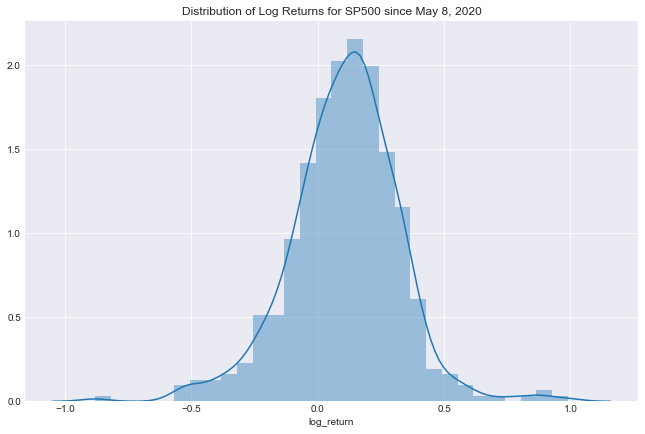

In [23]:
sns.distplot(log_returns.log_return)
plt.title('Distribution of Log Returns for SP500 since May 8, 2020')

In [24]:
# We can see above that the distribution of log returns for the past 6 months of the SP500 is
# mostly normal, and that the mean return is greater than zero. This is important to take note
# of when we try and do some classification tests later, as it may be more useful to classify
# securities based on whether they outperformed/underperformed the market, rather than whether
# they were above/below zero. This is because the analysis of such classifications may be
# more robust to varying market conditions, ie when the market as a whole moved up or down,
# since the time period in question was an overall period of growth for the market, and future
# periods of consideration may be neutral, or negative overall, and it would be better to use
# the fundamental financial data to try to find securities which would under or overperform the
# market.

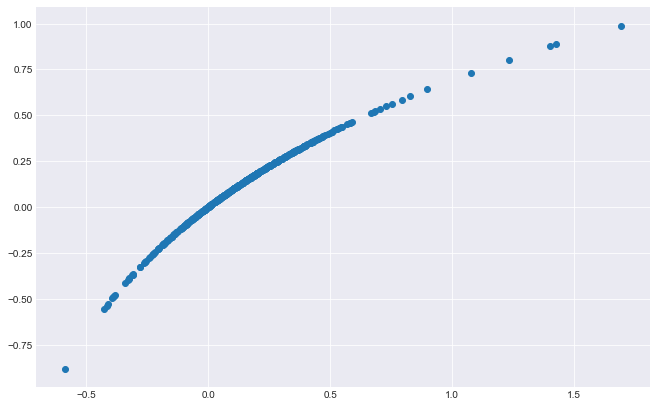

In [25]:
# I want to visualize the relationship between log returns and percent changes, just to make
# sure there aren't any surprises in how these have been calculated.
percent_returns = (sp500_close.iloc[-1].T / sp500_close.iloc[0].T) - 1
percent_returns = percent_returns.loc[log_returns.index]
plt.scatter(percent_returns, log_returns)

In [57]:
# Good, no surprises there. Now to get our fundamentals data imported
df = bf.build_big_df(sp500_tickers, 'data/sp500_close_05-08-2020')
df.head()

% Above Low  % Below High  % Held by Institutions          52-Wk Range  \
A             NaN        0.1206                  0.8499    ['61.13 - 90.64']   
AAL        0.1155           NaN                  0.8162     ['9.09 - 34.99']   
AAP           NaN        0.2717                  1.0080   ['71.33 - 171.43']   
AAPL          NaN        0.0540                  0.5986  ['170.27 - 327.85']   
ABBV          NaN        0.1420                  0.7329    ['62.55 - 97.86']   

      5yr Avg Return  5yr High  5yr Low  Annual Dividend $  Annual Dividend %  \
A           0.127567     90.64    33.12               0.72             0.0092   
AAL        -0.171550     59.08     9.09                NaN                NaN   
AAP         0.019850    201.24    71.33               1.00             0.0084   
AAPL        0.214367    327.85    89.47               3.28             0.0108   
ABBV        0.064350    125.86    45.45               4.72             0.0560   

      Annual Dividend Yield  ...  marketEdge  marketEdge opinion  \
A                    0.0092  ...         1.0    neutralfromavoid   
AAL                     NaN  ...         2.0    neutralfromavoid   
AAP                  0.0084  ...         1.0    neutralfromavoid   
AAPL                 0.0108  ...         3.0    neutralfromavoid   
ABBV                 0.0560  ...        -1.0     neutralfromlong   

      marketEdge opinion since  marketEdge since newConstructs  \
A                   2020-05-01        2020-05-01           3.0   
AAL                 2020-05-01        2020-05-01           4.0   
AAP                 2020-05-01        2020-05-01           1.0   
AAPL                2020-05-01        2020-05-01           3.0   
ABBV                2020-05-01        2020-05-01           1.0   

      newConstructs since  researchTeam  researchTeam since  theStreet  \
A              2020-05-08        reduce          2020-05-01        buy   
AAL            2020-05-08        reduce          2020-05-01       sell   
AAP            2020-05-08        reduce          2020-05-01       hold   
AAPL           2020-05-08          hold          2020-04-20        buy   
ABBV           2020-05-08          hold          2018-09-19       hold   

     theStreet since  
A         2016-03-28  
AAL       2020-05-01  
AAP       2020-03-17  
AAPL      2009-04-13  
ABBV      2019-08-27  

[5 rows x 106 columns]

## Data Exploration and Cleaning

In [58]:
df.info(max_cols=200)

<class 'pandas.core.frame.DataFrame'>
Index: 501 entries, A to ZTS
Data columns (total 106 columns):
% Above Low                                          274 non-null float64
% Below High                                         227 non-null float64
% Held by Institutions                               495 non-null float64
52-Wk Range                                          501 non-null object
5yr Avg Return                                       501 non-null float64
5yr High                                             501 non-null float64
5yr Low                                              501 non-null float64
Annual Dividend $                                    394 non-null float64
Annual Dividend %                                    394 non-null float64
Annual Dividend Yield                                389 non-null float64
Ask                                                  494 non-null float64
Ask Size                                             492 non-null float64
Ask close   

In [59]:
# In this notebook, we will not be modeling the prices of the securities at the date of the
# scrape, but rather attempting to model the returns of the securities since then. This means
# that our feature selection will follow different criteria. It is no longer a bad thing to
# have features which are related to the price of the security on the date of the scrape, so
# more features can be included in this round of modeling. We will still need to deal with
# getting rid of non-useful features, and features which are missing a lot of data.
# We can see straight away that % Above Low and % Above High have a lot of missing values, but
# we do have complete data for 52-Wk range, which would allow us to calculate these values
# manually, so we can drop these columns and compute them afterward.
to_drop = ['% Above Low',
           '% Below High',
           'Annual Dividend $', # Leave this out because % is more generalized
           #'Ask', # Price related
           #'Ask Size', # Not fundamental
           'Ask close', # Price related
           #'B/A Ratio', # Not fundamental
           #'B/A Size',
           #'Bid', # Price related
           #'Bid Size',
           'Bid close', # Price related
           'Change Since Close', # Price related
           #'Closing Price', # Using the yfinance closing prices
           'Day Change $', # % is more generalized
           #'Day Change %',
           #'Day High',
           #'Day Low',
           'Dividend Pay Date',
           'Ex-dividend',
           'Ex-dividend Date',
           #'Last (size)',
           'Last (time)',
           'Last Trade',
           'Next Earnings Announcement',
           #'Prev Close',
           'Price',
           #"Today's Open",
           #'Volume',
           #'Volume Past Day',
           'cfra since',
           'creditSuisse since',
           'ford since',
           'marketEdge opinion since',
           'marketEdge since',
           'newConstructs since',
           'researchTeam since',
           'theStreet since'
          ]

X = df.drop(columns=to_drop)
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 501 entries, A to ZTS
Data columns (total 84 columns):
% Held by Institutions                               495 non-null float64
52-Wk Range                                          501 non-null object
5yr Avg Return                                       501 non-null float64
5yr High                                             501 non-null float64
5yr Low                                              501 non-null float64
Annual Dividend %                                    394 non-null float64
Annual Dividend Yield                                389 non-null float64
Ask                                                  494 non-null float64
Ask Size                                             492 non-null float64
B/A Ratio                                            492 non-null float64
B/A Size                                             501 non-null object
Beta                                                 488 non-null float64
Bid           

In [60]:
# Comparing dividend related columns
X[['Annual Dividend %', 'Annual Dividend Yield']]

Annual Dividend %  Annual Dividend Yield
A                0.0092                 0.0092
AAL                 NaN                    NaN
AAP              0.0084                 0.0084
AAPL             0.0108                 0.0108
ABBV             0.0560                 0.0560
...                 ...                    ...
YUM              0.0222                 0.0218
ZBH              0.0080                 0.0079
ZBRA                NaN                    NaN
ZION             0.0460                 0.0443
ZTS              0.0064                 0.0064

[501 rows x 2 columns]

In [61]:
# We can see that these two columns are mostly the same, so the one with less missing values 
# should be dropped.
X = X.drop(columns='Annual Dividend Yield')

At this point it is necessary to deal with the missing data. In the last notebook, a variety of ways were explored to handle this issue. Since the missing data is spread across many rows, dropping the missing data is not an option, and binning all of the features to deal with missing data creates a vast number of features that are hard to interpret. It was decided that the best method of dealing with the missing data is to impute the data using sklearn. The most effective estimator for imputation varies, so I will repeat the process here of imputer estimator comparison, to find which estimator gives the best results, and continue using that selection.

In [62]:
# We still have a somewhat disappointing number of missing values to deal with. To get a sense
# of how they are distributed among the securites, let's see what we have left over if we 
# drop them all.
X.dropna().info()

<class 'pandas.core.frame.DataFrame'>
Index: 76 entries, AAP to ZTS
Data columns (total 83 columns):
% Held by Institutions                               76 non-null float64
52-Wk Range                                          76 non-null object
5yr Avg Return                                       76 non-null float64
5yr High                                             76 non-null float64
5yr Low                                              76 non-null float64
Annual Dividend %                                    76 non-null float64
Ask                                                  76 non-null float64
Ask Size                                             76 non-null float64
B/A Ratio                                            76 non-null float64
B/A Size                                             76 non-null object
Beta                                                 76 non-null float64
Bid                                                  76 non-null float64
Bid Size                 

In [63]:
# This is not very good news. There are only 76 securities for which we have data in all
# columns. We will address the issue with imputation

In [64]:
# The 'Volume Past Day' column is in a string format, let's take a look at it
X['Volume Past Day'].value_counts()

(Light)            244
(Average)           93
(Below Average)     85
(Heavy Day)         51
(Above Average)     28
Name: Volume Past Day, dtype: int64

In [65]:
# We can see that this feature is categorical, which will not be a problem if we are using
# any tree-based regressors, but it will need to be kept in mind.
# We need to look at 52-Wk Range, since this likely needs to be split into two columns
X['52-Wk Range'].head()


A         ['61.13 - 90.64']
AAL        ['9.09 - 34.99']
AAP      ['71.33 - 171.43']
AAPL    ['170.27 - 327.85']
ABBV      ['62.55 - 97.86']
Name: 52-Wk Range, dtype: object

In [66]:
# Testing a method to get rid of characters
X.loc['A', '52-Wk Range'].strip('[]').strip("''").replace(' ','')

'61.13-90.64'

In [67]:
X[['52-Wk Range', 'Market Cap', 'creditSuisse', 'researchTeam', 'theStreet']].head()

52-Wk Range Market Cap  creditSuisse researchTeam theStreet
A       ['61.13 - 90.64']      24.7B           NaN       reduce       buy
AAL      ['9.09 - 34.99']       4.3B  underperform       reduce      sell
AAP    ['71.33 - 171.43']       8.6B    outperform       reduce      hold
AAPL  ['170.27 - 327.85']       1.3T       neutral         hold       buy
ABBV    ['62.55 - 97.86']     124.0B           NaN         hold      hold

In [68]:
import dataframe_image as dfi

In [69]:
X['52-Wk Range'] = X['52-Wk Range'].map(lambda x: x.strip('[]').replace("'",'').replace(' ',''))
X['52-Wk Range'].head()

A         61.13-90.64
AAL        9.09-34.99
AAP      71.33-171.43
AAPL    170.27-327.85
ABBV      62.55-97.86
Name: 52-Wk Range, dtype: object

In [70]:
# Now to split this into two numerical columns
X['52-Wk Low'] = X['52-Wk Range'].map(lambda x: float(x.replace(',','').split('-')[0]))
X['52-Wk High'] = X['52-Wk Range'].map(lambda x: float(x.replace(',','').split('-')[1]))
X[['52-Wk Low', '52-Wk High']].head()

52-Wk Low  52-Wk High
A         61.13       90.64
AAL        9.09       34.99
AAP       71.33      171.43
AAPL     170.27      327.85
ABBV      62.55       97.86

In [71]:
# Great, now the original column can be dropped
X.drop('52-Wk Range', axis=1, inplace=True)
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 501 entries, A to ZTS
Data columns (total 84 columns):
% Held by Institutions                               495 non-null float64
5yr Avg Return                                       501 non-null float64
5yr High                                             501 non-null float64
5yr Low                                              501 non-null float64
Annual Dividend %                                    394 non-null float64
Ask                                                  494 non-null float64
Ask Size                                             492 non-null float64
B/A Ratio                                            492 non-null float64
B/A Size                                             501 non-null object
Beta                                                 488 non-null float64
Bid                                                  499 non-null float64
Bid Size                                             492 non-null float64
Change in Deb

In [72]:
# Now for a closer look at the Bid/Ask size related columns
X[['B/A Size', 'Bid Size', 'Ask Size']].head()

B/A Size  Bid Size  Ask Size
A      200x100     200.0     100.0
AAL   1300x100    1300.0     100.0
AAP   2800x200    2800.0     200.0
AAPL   500x300     500.0     300.0
ABBV  1200x100    1200.0     100.0

In [73]:
# It looks like we can comfortably drop the B/A Size column as we have the info elsewhere
X.drop('B/A Size', axis=1, inplace=True)
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 501 entries, A to ZTS
Data columns (total 83 columns):
% Held by Institutions                               495 non-null float64
5yr Avg Return                                       501 non-null float64
5yr High                                             501 non-null float64
5yr Low                                              501 non-null float64
Annual Dividend %                                    394 non-null float64
Ask                                                  494 non-null float64
Ask Size                                             492 non-null float64
B/A Ratio                                            492 non-null float64
Beta                                                 488 non-null float64
Bid                                                  499 non-null float64
Bid Size                                             492 non-null float64
Change in Debt/Total Capital Quarter over Quarter    473 non-null float64
Closing Pric

In [75]:
# We need to fix the format of the Market Cap column
X['Market Cap'].head()

A        24.7B
AAL       4.3B
AAP       8.6B
AAPL      1.3T
ABBV    124.0B
Name: Market Cap, dtype: object

In [76]:
# We can see that the last character is a letter representing a multiple
X['Market Cap'].map(lambda x: x[-1]).unique()

array(['B', 'T', 'M'], dtype=object)

In [77]:
def fix_market_cap(x):
    if x[-1] == 'M':
        x = x.strip('M')
        x = float(x) * 1e6
    elif x[-1] == 'B':
        x = x.strip('B')
        x = float(x) * 1e9
    elif x[-1] == 'T':
        x = x.strip('T')
        x = float(x) * 1e12
    else:
        raise ValueError('Invalid input')
        
    return x

In [78]:
X['marketCap'] = X['Market Cap'].map(fix_market_cap)
X[['marketCap']].head()

marketCap
A     2.470000e+10
AAL   4.300000e+09
AAP   8.600000e+09
AAPL  1.300000e+12
ABBV  1.240000e+11

In [79]:
# There, that's fixed, now to drop original column
X.drop(columns=['Market Cap'], inplace=True)

In [80]:
# We have a duplicate Market Edge Opinion column, and also a P/E Ratio duplicate
to_drop = ['Market Edge Opinion:', 
            'P/E Ratio (TTM, GAAP)'
           ]
X = X.drop(columns=to_drop)
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 501 entries, A to ZTS
Data columns (total 81 columns):
% Held by Institutions                               495 non-null float64
5yr Avg Return                                       501 non-null float64
5yr High                                             501 non-null float64
5yr Low                                              501 non-null float64
Annual Dividend %                                    394 non-null float64
Ask                                                  494 non-null float64
Ask Size                                             492 non-null float64
B/A Ratio                                            492 non-null float64
Beta                                                 488 non-null float64
Bid                                                  499 non-null float64
Bid Size                                             492 non-null float64
Change in Debt/Total Capital Quarter over Quarter    473 non-null float64
Closing Pric

In [81]:
# Check for NaN values in log_returns
log_returns.isna().sum()

log_return    0
dtype: int64

In [82]:
# Check for any companies we do not have a target for
[colname for colname in X.index if colname not in log_returns.index]

['AGN', 'ETFC']

In [83]:
X_new = X.drop(index=['AGN', 'ETFC'])

In [84]:
# Need to check for infs
np.inf in X_new.values or -np.inf in X_new.values

True

In [85]:
# Replace the infs with nans for consistent missing data format
X_new = X_new.replace([np.inf, -np.inf], np.NaN)

<a id='modeling'></a>
# Modeling the returns
This section will repeat Regression and Classifiaction tasks before and after multicollinearity is removed from the predictors, this way we get an idea of how the multicollinearity affects the models and resulting feature importances.

<a id='regression1'></a>
## Regression (1)

<a id='imputing_regression1'></a>
### Imputing Data (Regression 1)

In [86]:
# Import some regressors
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

In [87]:
# First we will make helper functions to make this process efficient. These are modified
# versions of the functions found in the sklearn documentation
def get_scores_for_imputer(imputer, X_missing, y_missing, regressor, scoring, scale=True):
    if scale:
        steps = [('scaler', StandardScaler()), 
                 ('imputer', imputer), 
                 ('regressor', regressor)]
    else:
        steps = [('imputer', imputer), 
                 ('regressor', regressor)]
        
    estimator = Pipeline(steps=steps)
    impute_scores = cross_val_score(estimator, X_missing, y_missing,
                                    scoring=scoring,
                                    cv=N_SPLITS)
    return impute_scores

def get_impute_zero_score(X_missing, y_missing, regressor, scoring):

    imputer = SimpleImputer(missing_values=np.nan, add_indicator=True,
                            strategy='constant', fill_value=0)
    zero_impute_scores = get_scores_for_imputer(imputer, 
                                                X_missing, 
                                                y_missing, 
                                                regressor, 
                                                scoring)
    return zero_impute_scores.mean(), zero_impute_scores.std()

def get_impute_knn_score(X_missing, y_missing, regressor, scoring, n_neighbors=5):
    imputer = KNNImputer(missing_values=np.nan, 
                         add_indicator=True, 
                         n_neighbors=n_neighbors,
                         weights='distance')
    knn_impute_scores = get_scores_for_imputer(imputer, 
                                               X_missing, 
                                               y_missing, 
                                               regressor, 
                                               scoring)
    return knn_impute_scores.mean(), knn_impute_scores.std()

def get_impute_mean(X_missing, y_missing, regressor, scoring):
    imputer = SimpleImputer(missing_values=np.nan, strategy="mean",
                            add_indicator=True)
    mean_impute_scores = get_scores_for_imputer(imputer, 
                                                X_missing, 
                                                y_missing, 
                                                regressor, 
                                                scoring)
    return mean_impute_scores.mean(), mean_impute_scores.std()

def get_impute_iterative(X_missing, y_missing, regressor, scoring, estimator=None,
                         n_nearest_features=None, max_iter=10
                        ):
    sample_posterior = False
    if 'BayesianRidge' in str(estimator):
        sample_posterior = True
    elif estimator is None:
        n_nearest_features = 5
        sample_posterior = True
       
    imputer = IterativeImputer(estimator=estimator,
                               missing_values=np.nan, 
                               max_iter=max_iter,
                               add_indicator=True,
                               random_state=0, 
                               n_nearest_features=n_nearest_features,
                               sample_posterior=sample_posterior
                              )
    iterative_impute_scores = get_scores_for_imputer(imputer,
                                                     X_missing,
                                                     y_missing,
                                                     regressor,
                                                     scoring
                                                    )
    
    return iterative_impute_scores.mean(), iterative_impute_scores.std()

In [265]:
# Function to graph results of imputation comparisons
def graph_imputer_scores(scores, stds, labels, scoring, regressor=None, iterative=False):
    n_bars = len(scores)
    xval = np.arange(n_bars)
    
    if regressor is not None:
        name = str(regressor).split('(')[0]
        title_string = ' with {}'.format(name)
    else:
        title_string = ''

    x_labels = labels
    colors = ['r', 'g', 'b', 'orange', 'black', 'magenta', 'cyan', 'purple', 'grey']

    plt.figure(figsize=(12, 6))
    ax1 = plt.subplot(111)
    for j in xval:
        ax1.barh(j, scores[j], xerr=stds[j],
                 color=colors[j], alpha=0.6, align='center')
    if not iterative:
        ax1.set_title('Imputation Techniques Comparison{}'.format(title_string))
    else:
        ax1.set_title('Iterative Imputation Estimator Comparison{}'.format(title_string))
    ax1.set_xlim(left=np.min(scores*2) * 0.9,
                 right=np.max(scores*2) * 1.1)
    ax1.set_yticks(xval)
    ax1.set_xlabel(scoring)
    ax1.invert_yaxis()
    ax1.set_yticklabels(x_labels)

    return ax1

# Creating a wrapper function to keep code DRY
def compare_imputer_scores(X, y, regressor, scoring, iterative_estimators=None, max_iter=10):
    # Getting scores for these imputers
    zero_scores = get_impute_zero_score(X, y, regressor, scoring)
    mean_scores = get_impute_mean(X, y, regressor, scoring)
    knn_scores = get_impute_knn_score(X, y, regressor, scoring)
    iter_scores = get_impute_iterative(X, y, regressor, scoring, n_nearest_features=5)
    
    scores = [zero_scores[0], mean_scores[0], knn_scores[0], iter_scores[0]]
    stds = [zero_scores[1], mean_scores[1], knn_scores[1], iter_scores[1]]
    
    # Graphing the scores of the imputation methods above
    labels = ['Zero imputation',
              'Mean Imputation',
              'KNN Imputation',
              'Iterative Imputation']
    
    # Now to run through the estimators for IterativeImputer
    results = []

    if iterative_estimators:
        labels2 = []
        for estimator in iterative_estimators:
            name = str(estimator).split('(')[0]
            print('Imputing with IterativeImputer using {} estimator'.format(name))
            labels2.append(name)
            
            n_nearest_features = None
            if 'BayesianRidge' in str(estimator):
                n_nearest_features = 5
                
            results.append(get_impute_iterative(X,
                                                y,
                                                regressor,
                                                scoring,
                                                estimator,
                                                n_nearest_features=n_nearest_features,
                                                max_iter=max_iter
                                              )
                         )
            
        scores2 = [results[i][0] for i in range(len(results))]
        stds2 = [results[i][1] for i in range(len(results))]
    
    ax1 = graph_imputer_scores(scores, stds, labels, scoring, regressor)
    
    if iterative_estimators:
        ax2 = graph_imputer_scores(scores2, stds2, labels2, scoring, regressor, iterative=True)
        return ax1, ax2
        
    return ax1

#### LinearRegression

In [89]:
regressor = LinearRegression()

In [90]:
import sklearn
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted'])

In [91]:
y = log_returns.log_return
N_SPLITS = 5

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 330, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 296, in _fit
    **fit_params_steps[name])
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\memory.py", line 355, in __call__
    return self.func(*args, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 740, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "C:\ProgramData\Anaconda

ValueError: Axis limits cannot be NaN or Inf

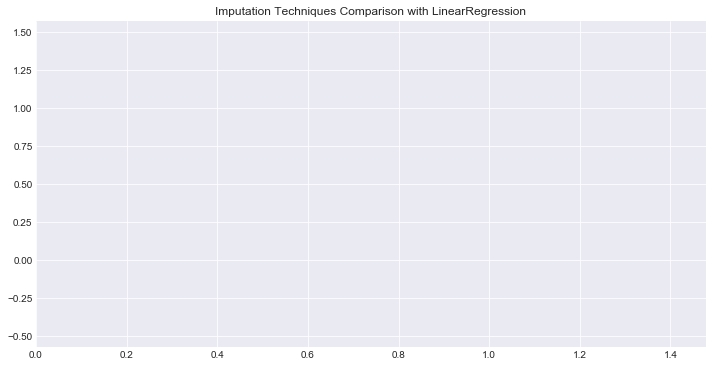

In [92]:
ax1 = compare_imputer_scores(X_new, y, regressor, 'r2')

In [93]:
# We still need to deal with our categorical variables to make them numeric, or one-hot encode
# them. Let's take another look
X_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 499 entries, A to ZTS
Data columns (total 81 columns):
% Held by Institutions                               493 non-null float64
5yr Avg Return                                       499 non-null float64
5yr High                                             499 non-null float64
5yr Low                                              499 non-null float64
Annual Dividend %                                    392 non-null float64
Ask                                                  492 non-null float64
Ask Size                                             490 non-null float64
B/A Ratio                                            490 non-null float64
Beta                                                 486 non-null float64
Bid                                                  497 non-null float64
Bid Size                                             490 non-null float64
Change in Debt/Total Capital Quarter over Quarter    471 non-null float64
Closing Pric

In [94]:
X_new.dtypes[X_new.dtypes == 'object'].index

Index(['Volume Past Day', 'creditSuisse', 'marketEdge opinion', 'researchTeam',
       'theStreet'],
      dtype='object')

In [95]:
X_new[X_new.dtypes[X_new.dtypes == 'object'].index].head()

Volume Past Day  creditSuisse marketEdge opinion researchTeam theStreet
A        (Heavy Day)           NaN   neutralfromavoid       reduce       buy
AAL          (Light)  underperform   neutralfromavoid       reduce      sell
AAP      (Heavy Day)    outperform   neutralfromavoid       reduce      hold
AAPL       (Average)       neutral   neutralfromavoid         hold       buy
ABBV     (Heavy Day)           NaN    neutralfromlong         hold      hold

In [96]:
# I don't think that the Volume Past Day will be very helpful for a 6 month projection, so I
# will drop it. The marketEdge opinion has a numeric counterpart in marketEdge column, so this
# can also probably be dropped. The rest can be turned into dummy variables
X_new.drop(columns=['Volume Past Day', 'marketEdge opinion'], inplace=True)

In [97]:
X_new = pd.get_dummies(X_new, drop_first=True)
X_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 499 entries, A to ZTS
Data columns (total 82 columns):
% Held by Institutions                               493 non-null float64
5yr Avg Return                                       499 non-null float64
5yr High                                             499 non-null float64
5yr Low                                              499 non-null float64
Annual Dividend %                                    392 non-null float64
Ask                                                  492 non-null float64
Ask Size                                             490 non-null float64
B/A Ratio                                            490 non-null float64
Beta                                                 486 non-null float64
Bid                                                  497 non-null float64
Bid Size                                             490 non-null float64
Change in Debt/Total Capital Quarter over Quarter    471 non-null float64
Closing Pric

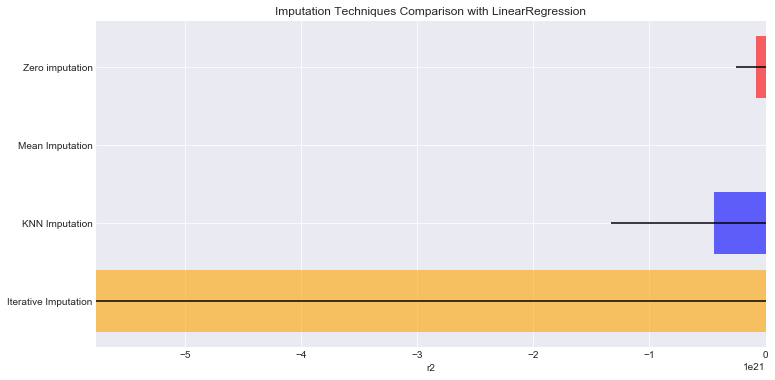

In [98]:
ax1 = compare_imputer_scores(X_new, y, regressor, 'r2')

#### Lasso Regression

In [99]:
# Let's try this with another regressor
from sklearn.linear_model import Lasso
regressor = Lasso()

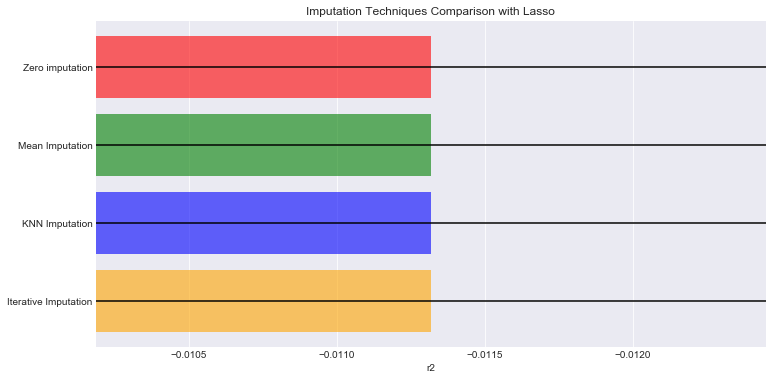

In [100]:
ax1 = compare_imputer_scores(X_new, y, regressor, 'r2')

In [101]:
# Lasso Regression has not performed well here

In [102]:
# There are some options for IterativeImputer that have not been explored yet. Let's import some
from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor

#### RandomForestRegressor

In [216]:
y = targets.log_return

In [217]:
# We can see that the Linear Regressions have not performed well, but that things are working
# Let's step it up to a better regressor
regressor = RandomForestRegressor(random_state=0)

In [219]:
estimators = [
    BayesianRidge(),
    DecisionTreeRegressor(max_features='auto', random_state=123),
    ExtraTreesRegressor(n_estimators=10, max_features='sqrt', random_state=123),
    KNeighborsRegressor(n_neighbors=15)
]

Imputing with IterativeImputer using BayesianRidge estimator
Imputing with IterativeImputer using DecisionTreeRegressor estimator


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


Imputing with IterativeImputer using ExtraTreesRegressor estimator


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


Imputing with IterativeImputer using KNeighborsRegressor estimator


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


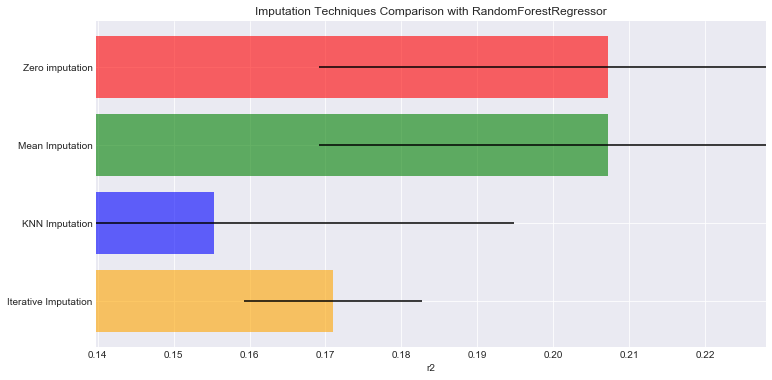

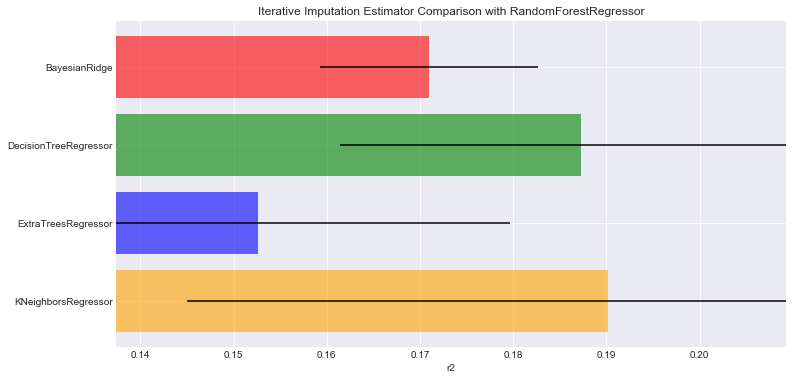

In [220]:
ax1, ax2 = compare_imputer_scores(X_new, y, regressor, 'r2', estimators)

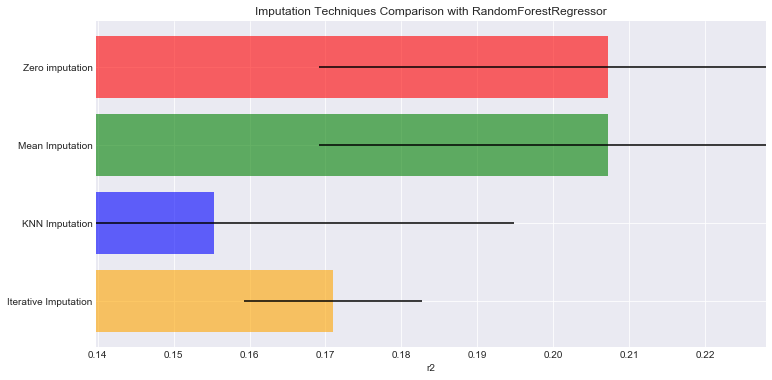

In [221]:
ax1.figure

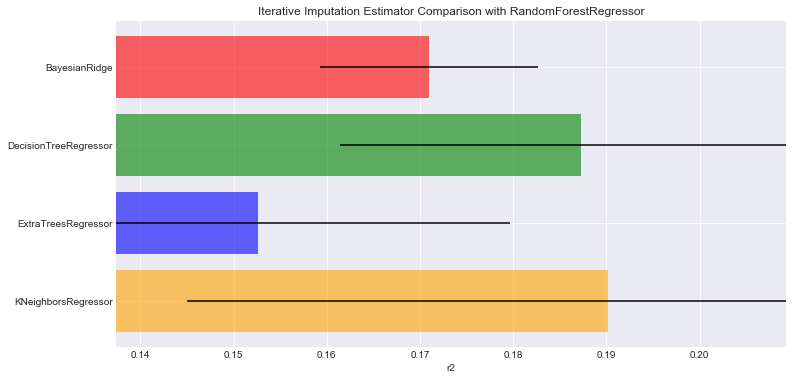

In [222]:
ax2.figure

In [108]:
# We can see that the RandomForestRegressor has performed much better than the LinearRegression
# The Zero and Mean imputation methods had the best results, although the variance was wide.
# These results are somewhat lackluster, with an r2 just over .2

In [122]:
estimators = [
    BayesianRidge(),
    DecisionTreeRegressor(max_features='auto', random_state=0),
    RandomForestRegressor(random_state=0),
    ExtraTreesRegressor(n_estimators=10, random_state=0),
    KNeighborsRegressor(n_neighbors=15)
]

In [134]:
estimators = [
    BayesianRidge(),
    DecisionTreeRegressor(max_features='sqrt', random_state=123),
    ExtraTreesRegressor(n_estimators=10, max_features='sqrt', random_state=123),
    KNeighborsRegressor(n_neighbors=30)
]

#### GradientBoostingRegressor

In [109]:
# Let's try this one more time with another regressor
from sklearn.ensemble import GradientBoostingRegressor
regressor = GradientBoostingRegressor(random_state=0)

In [110]:
estimators = [
    BayesianRidge(),
    DecisionTreeRegressor(max_features='sqrt', random_state=123),
    ExtraTreesRegressor(n_estimators=10, max_features='sqrt', random_state=123),
    KNeighborsRegressor(n_neighbors=15)
]

Imputing with IterativeImputer using BayesianRidge estimator
Imputing with IterativeImputer using DecisionTreeRegressor estimator


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


Imputing with IterativeImputer using ExtraTreesRegressor estimator


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


Imputing with IterativeImputer using KNeighborsRegressor estimator


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


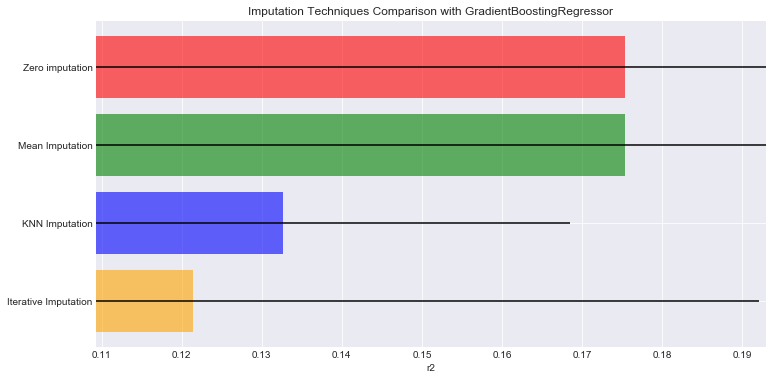

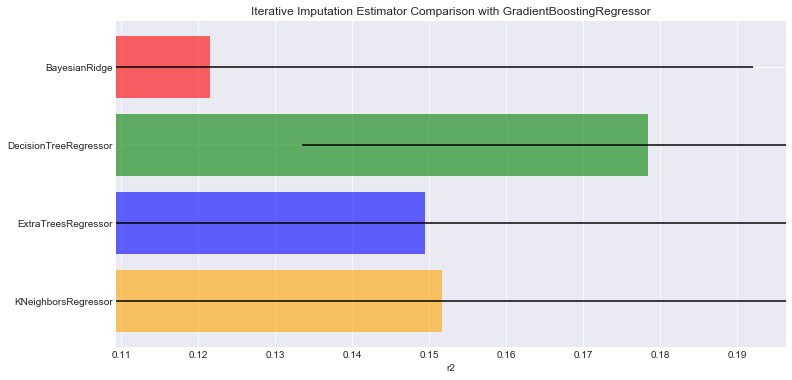

In [111]:
ax1, ax2 = compare_imputer_scores(X_new, y, regressor, 'r2', estimators)

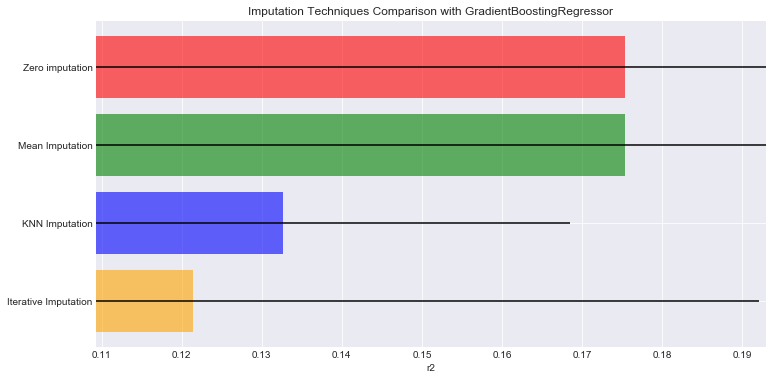

In [112]:
ax1.figure

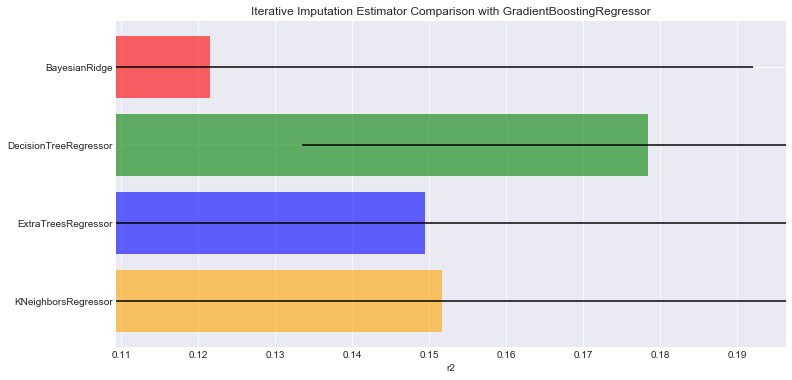

In [113]:
ax2.figure

In [114]:
# These scores are even worse than the RandomForest. So far the RandomForestRegressor with zero
# imputation is actually working the best.

#### XGBRegressor

In [115]:
from xgboost import XGBRegressor
regressor = XGBRegressor(random_state=0)

In [201]:
estimators = [
    BayesianRidge(),
    DecisionTreeRegressor(max_features='sqrt', random_state=123),
    ExtraTreesRegressor(n_estimators=10, max_features='sqrt', random_state=123),
    KNeighborsRegressor(n_neighbors=15)
]

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[22:23:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[22:23:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[22:23:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[22:23:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[22:23:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[22:23:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[22:23:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[22:23:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[22:23:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[22:23:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[22:23:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[22:23:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[22:23:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[22:23:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[22:23:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[22:23:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[22:23:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[22:23:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[22:23:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:23:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Imputing with IterativeImputer using BayesianRidge estimator


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[22:24:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[22:24:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[22:24:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[22:24:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[22:24:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Imputing with IterativeImputer using DecisionTreeRegressor estimator


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[22:24:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[22:24:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[22:24:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[22:24:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[22:24:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Imputing with IterativeImputer using ExtraTreesRegressor estimator


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[22:24:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[22:25:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[22:25:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[22:25:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[22:26:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Imputing with IterativeImputer using KNeighborsRegressor estimator


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[22:26:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[22:26:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[22:26:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[22:26:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[22:26:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


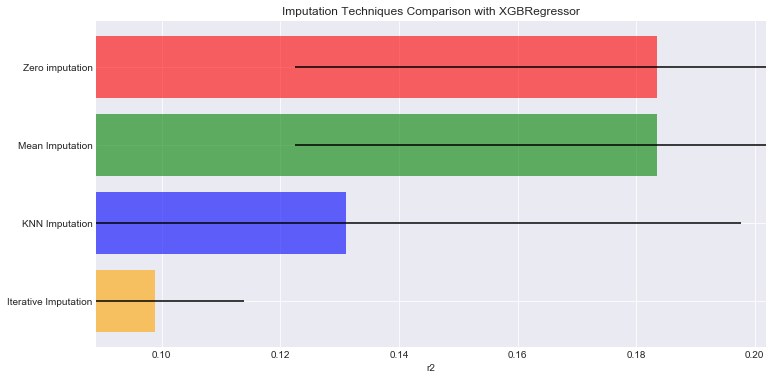

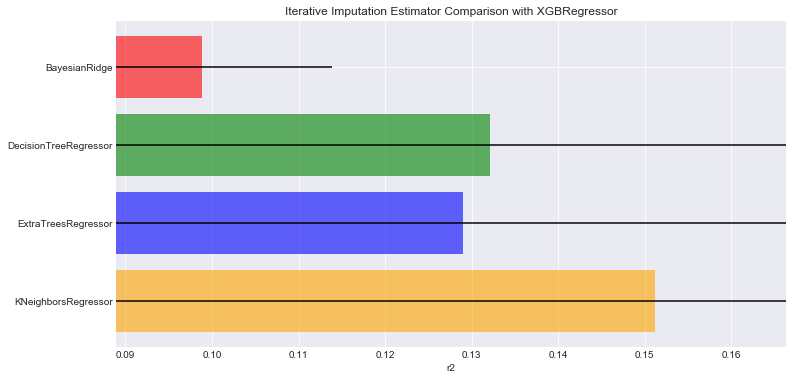

In [202]:
ax1, ax2 = compare_imputer_scores(X_new, y, regressor, 'r2', estimators)

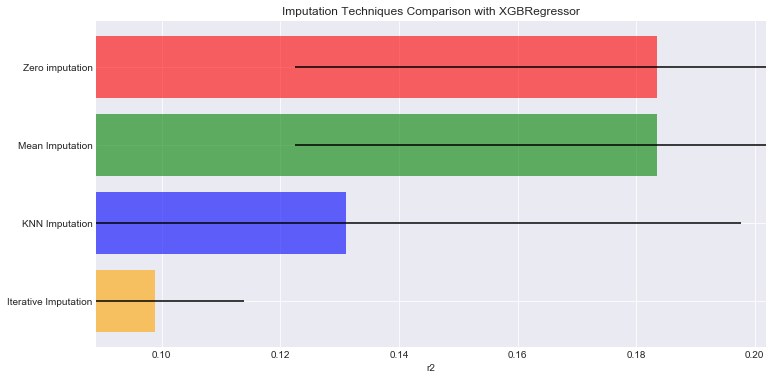

In [203]:
ax1.figure

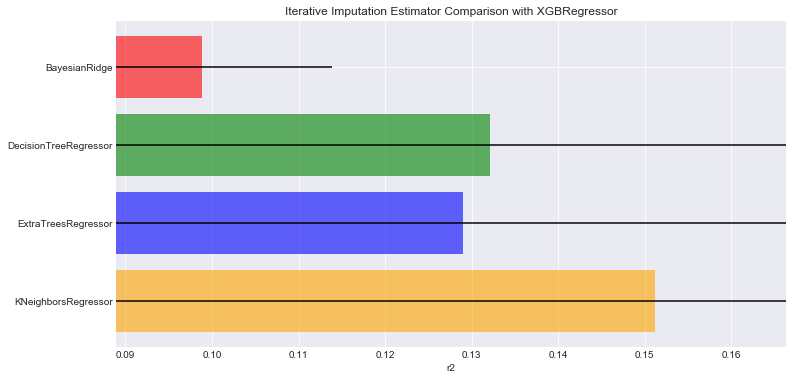

In [204]:
ax2.figure

In [ ]:
# Again, more lackluster scores that are all over the place

In [212]:
# XGBRegressor has its own imputation method built in, let's try it out
scores = cross_val_score(regressor, X_new, y, scoring='r2', n_jobs=-1)
print('cross validation scores')
print('mean:', scores.mean())
print('std:', scores.std())

cross validation scores
mean: 0.19282912900251387
std: 0.053154758800013815


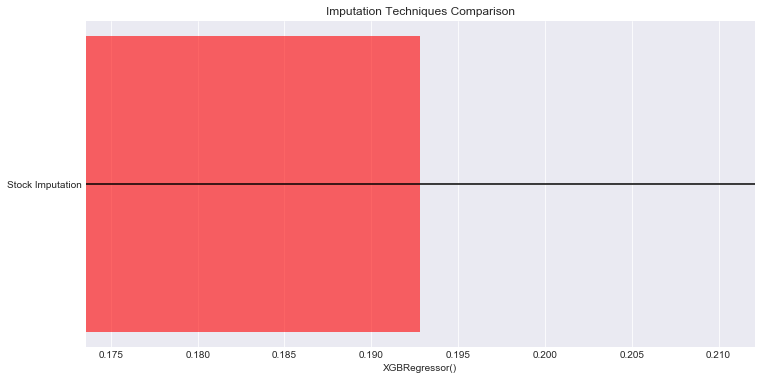

In [215]:
graph_imputer_scores([scores.mean()], [scores.std()], ['Stock Imputation'], regressor)

In [ ]:
# This worked better than the other methods, but the r2 is still low and the variance is still
# wide.

#### XGBRFRegressor

In [123]:
from xgboost import XGBRFRegressor
regressor = XGBRFRegressor(random_state=0)

In [124]:
estimators = [
    BayesianRidge(),
    DecisionTreeRegressor(max_features='sqrt', random_state=123),
    ExtraTreesRegressor(n_estimators=10, max_features='sqrt', random_state=123),
    KNeighborsRegressor(n_neighbors=15)
]

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:25:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:25:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:25:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:25:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:25:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:25:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:25:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:25:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:25:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:25:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:25:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:25:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:25:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:25:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:25:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:25:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:25:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:25:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:25:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:25:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Imputing with IterativeImputer using BayesianRidge estimator


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:25:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:25:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:25:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:25:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:25:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Imputing with IterativeImputer using DecisionTreeRegressor estimator


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:25:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:25:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:25:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:25:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:25:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Imputing with IterativeImputer using ExtraTreesRegressor estimator


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:26:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:26:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:26:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:26:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:26:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Imputing with IterativeImputer using KNeighborsRegressor estimator


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:26:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:27:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:27:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:27:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:27:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


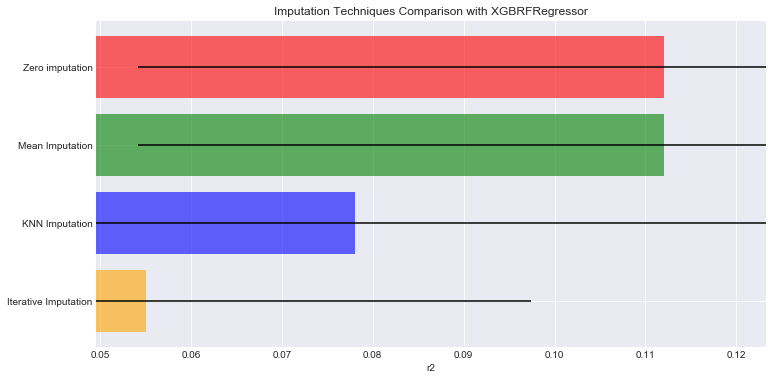

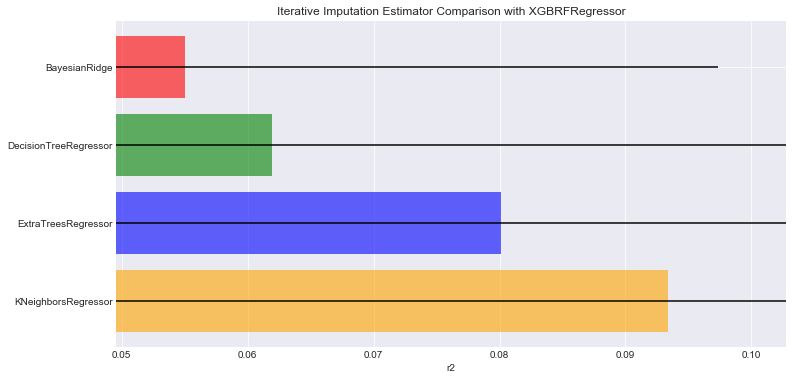

In [125]:
ax1, ax2 = compare_imputer_scores(X_new, y, regressor, 'r2', estimators)

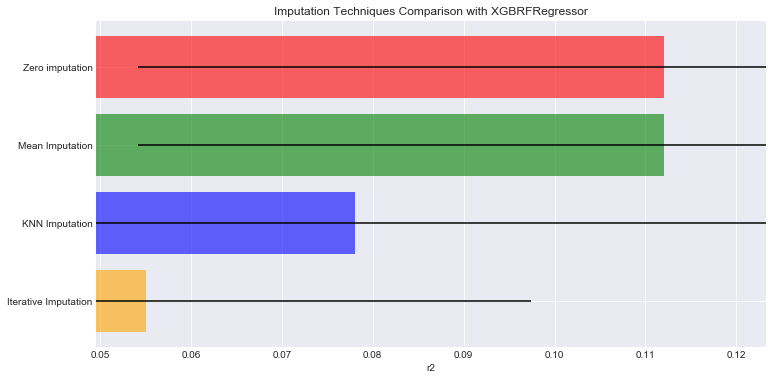

In [126]:
ax1.figure

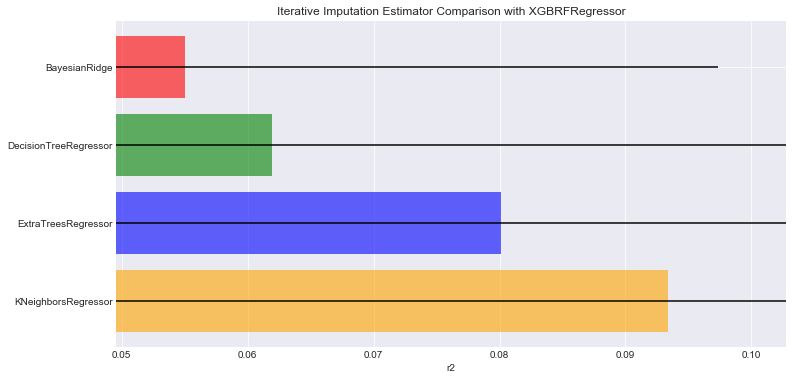

In [127]:
ax2.figure

In [128]:
# Nothing happening here either

In [129]:
# XGBRFRegressor has its own imputation method built in, let's try it out
scores = cross_val_score(regressor, X_new, y, scoring='r2', n_jobs=-1)
print('cross validation scores')
print('mean:', scores.mean())
print('std:', scores.std())

cross validation scores
mean: 0.10847621888577766
std: 0.05449842678702326


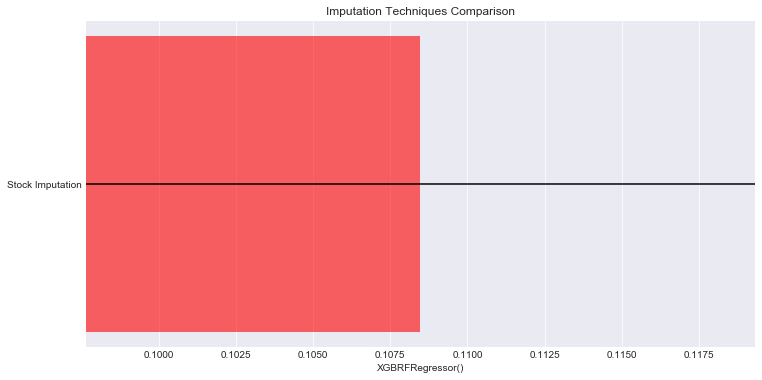

In [130]:
graph_imputer_scores([scores.mean()], [scores.std()], ['Stock Imputation'], regressor)

In [ ]:
# This regressor is not working as well as others we have explored so far

#### KNeighborsRegression

In [205]:
regressor = KNeighborsRegressor(weights='distance', n_jobs=-1)

In [206]:
estimators = [
    BayesianRidge(),
    DecisionTreeRegressor(max_features='sqrt', random_state=123),
    ExtraTreesRegressor(n_estimators=10, max_features='sqrt', random_state=123),
    KNeighborsRegressor(n_neighbors=15)
]

Imputing with IterativeImputer using BayesianRidge estimator
Imputing with IterativeImputer using DecisionTreeRegressor estimator


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


Imputing with IterativeImputer using ExtraTreesRegressor estimator


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


Imputing with IterativeImputer using KNeighborsRegressor estimator


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


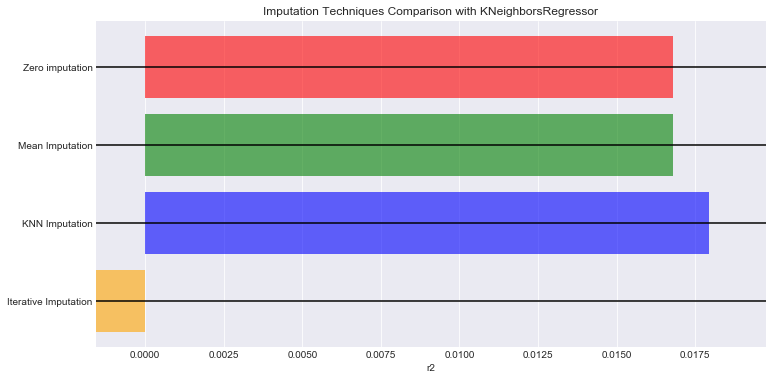

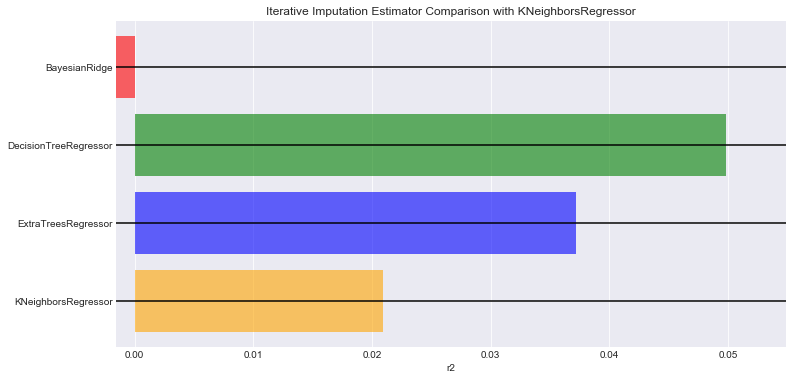

In [207]:
ax1, ax2 = compare_imputer_scores(X_new, y, regressor, 'r2', estimators)

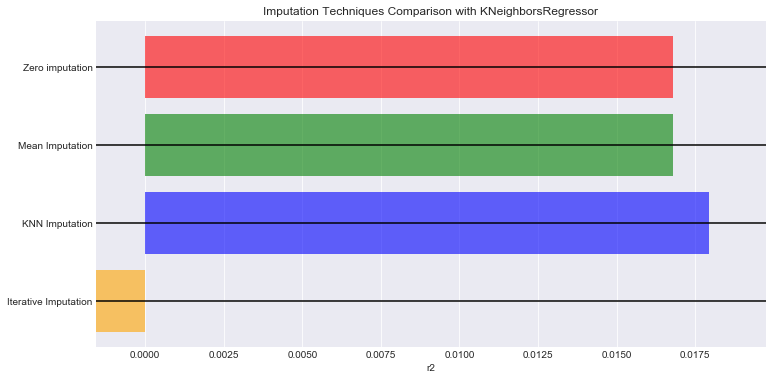

In [208]:
ax1.figure

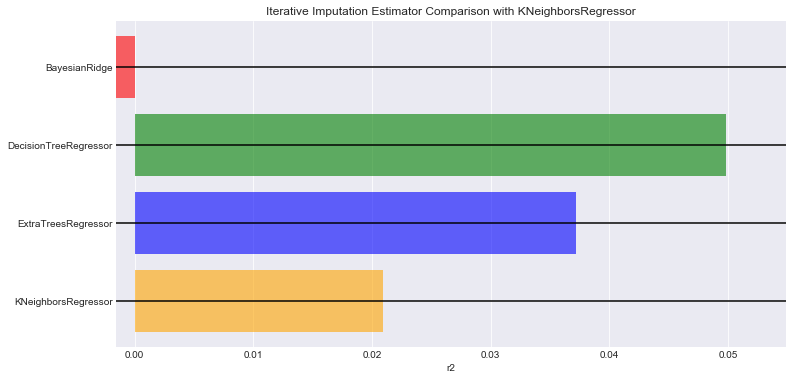

In [209]:
ax2.figure

In [ ]:
# Some terrible performance here from the KNeighborsRegressor

#### AdaBoostRegressor

In [116]:
from sklearn.ensemble import AdaBoostRegressor
regressor = AdaBoostRegressor(random_state=0)

In [117]:
estimators = [
    BayesianRidge(),
    DecisionTreeRegressor(max_features='sqrt', random_state=123),
    ExtraTreesRegressor(n_estimators=10, max_features='sqrt', random_state=123),
    KNeighborsRegressor(n_neighbors=15)
]

Imputing with IterativeImputer using BayesianRidge estimator
Imputing with IterativeImputer using DecisionTreeRegressor estimator


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


Imputing with IterativeImputer using ExtraTreesRegressor estimator


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


Imputing with IterativeImputer using KNeighborsRegressor estimator


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


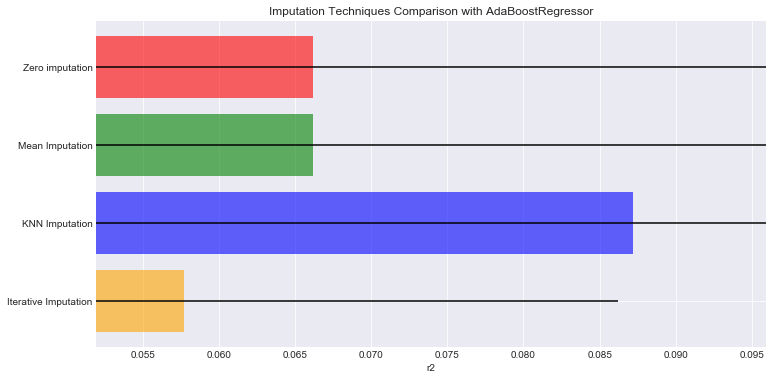

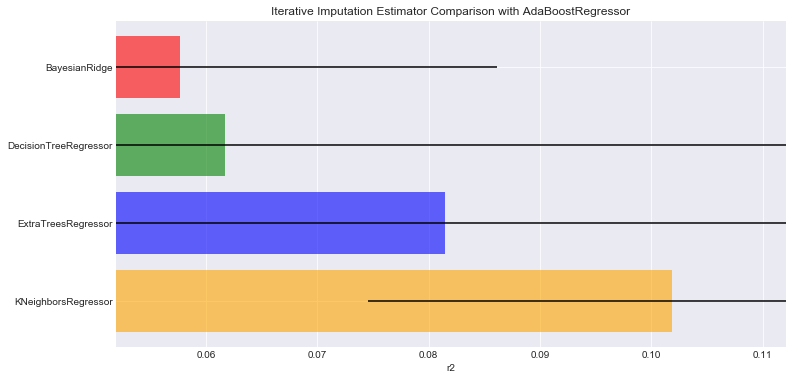

In [118]:
ax1, ax2 = compare_imputer_scores(X_new, y, regressor, 'r2', estimators)

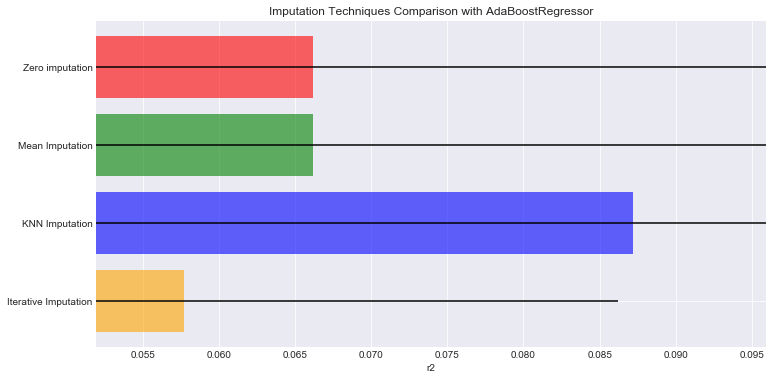

In [119]:
ax1.figure

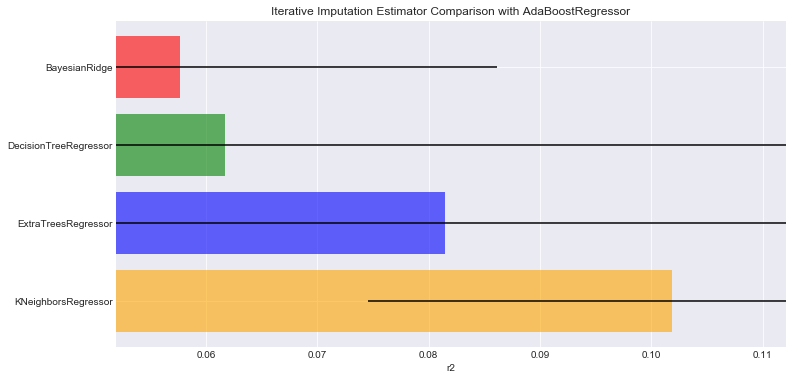

In [120]:
ax2.figure

In [ ]:
# So far so terrible. Let's take the best regressor so far, the RandomForestRegressor, and
# do a grid search to see what the best model we can make is.

<a id='modeling_regression1'></a>
### Modeling (Regression 1)

In [121]:
# Let's do some grid searching to tune the hyperparameters of the model
from sklearn.model_selection import GridSearchCV

In [122]:
from sklearn.pipeline import Pipeline

In [143]:
imputer_estimator = KNeighborsRegressor(weights='distance', n_jobs=-1)
#n_nearest_features = None
sample_posterior = True

scaler = StandardScaler()

imputer = IterativeImputer(estimator=imputer_estimator,
                           missing_values=np.nan, 
                           add_indicator=True,
                           random_state=123,
                           #sample_posterior=sample_posterior
                          )

regressor = RandomForestRegressor(random_state=0, n_jobs=-1)

steps = [('scaler', scaler),
         ('imputer', imputer),
         ('regressor', regressor)
        ]
estimator = Pipeline(steps=steps)

param_grid = {'imputer__n_nearest_features': [10, 15, 20],
              #'imputer__weights': ['uniform', 'auto'],
              #'regressor__loss': ['ls', 'lad', 'huber'],
              'regressor__n_estimators': [10, 50, 100, 200],
              'regressor__max_features': ['auto', 'sqrt', 'log2'],
              'regressor__min_samples_leaf': [1, 2, 5]
             }

grid_search = GridSearchCV(estimator, param_grid=param_grid, scoring='r2', cv=5)
grid_fit = grid_search.fit(X_new, y)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impu

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impu

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impu

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impu

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impu

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impu

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impu

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impu

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impu

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impu

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impu

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impu

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impu

In [144]:
grid_fit.best_params_

{'imputer__n_nearest_features': 15,
 'regressor__max_features': 'auto',
 'regressor__min_samples_leaf': 1,
 'regressor__n_estimators': 200}

In [145]:
grid_fit.best_score_

0.21562174010216592

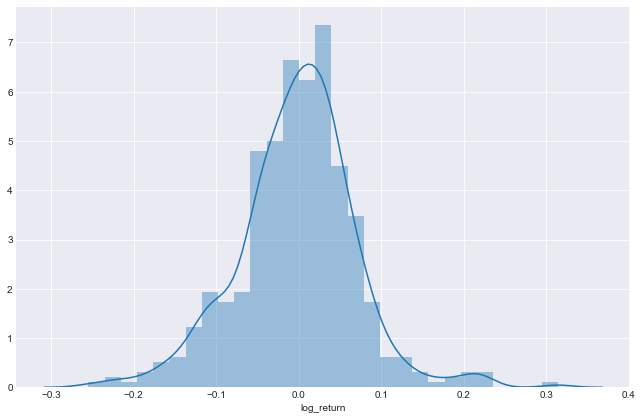

In [146]:
# These results are not extraordinary, but they aren't completely useless either. It is starting
# to look like turning this into a classification task is the way to go. First I'd like to try
# another regressor or two, but ultimately a binary classification task between winners and 
# losers may give the most robust business application.
# Let's look at our residuals
preds = grid_fit.best_estimator_.predict(X_new)
resids = y - preds
sns.distplot(resids)

In [348]:
# We can see that the residuals are symmetrical

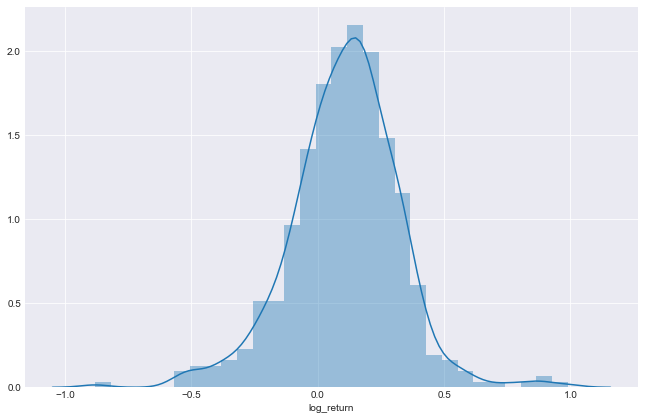

In [349]:
# Let's look again at our log returns over the period of study
sns.distplot(log_returns.log_return)

In [150]:
# Let's train regressor with the same hyperparameters but no missing value indicators to get
# an idea of what feature importances for predicting returns over the time period look like
# before multicollinearity is managed, so that we have something to compare to later.
imputer_estimator = KNeighborsRegressor(weights='distance', 
                                        n_jobs=-1,
                                        n_neighbors=15
                                       )
imputer = IterativeImputer(estimator=imputer_estimator,
                           missing_values=np.nan, 
                           add_indicator=False,
                           random_state=123,
                          )

est = Pipeline(steps=[('scaler', StandardScaler()),
                      ('imputer', imputer),
                      ('regressor',
                       RandomForestRegressor(random_state=0,
                                             n_jobs=-1,
                                             n_estimators=200,
                                            ))])

In [151]:
cv_scores = cross_val_score(est, X_new, y, scoring='r2', cv=5)
cv_scores.mean()

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


0.19492460129848485

In [152]:
# Although the model's predictive power is pretty low, it isn't nonexistent, and knowing which
# features contributed to it is still useful
X_train, X_test, y_train, y_test = train_test_split(X_new, y, random_state=42)
est.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('imputer',
                 IterativeImputer(estimator=KNeighborsRegressor(n_jobs=-1,
                                                                n_neighbors=15,
                                                                weights='distance'),
                                  random_state=123)),
                ('regressor',
                 RandomForestRegressor(n_estimators=200, n_jobs=-1,
                                       random_state=0))])

Text(0.5, 1.0, 'Feature Importance (MDI)')

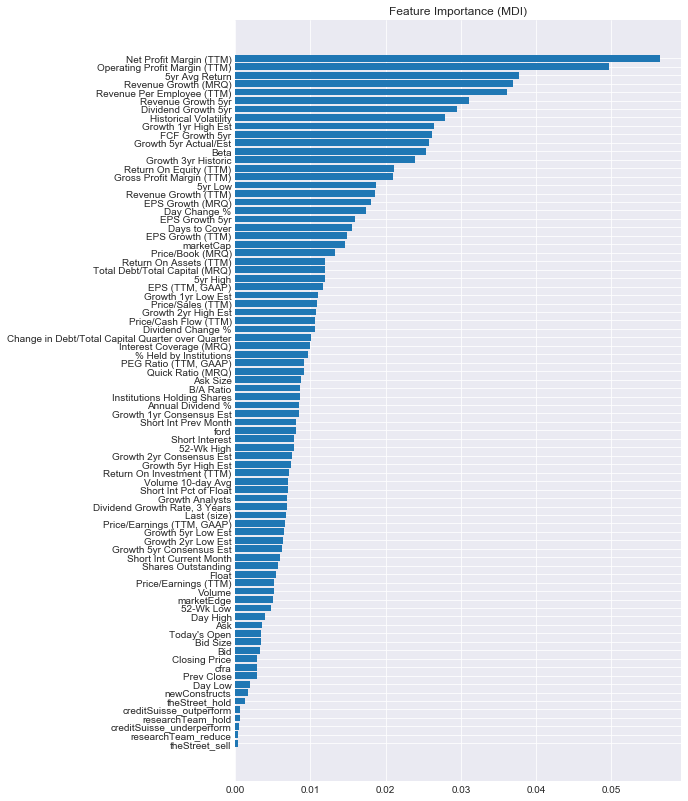

In [154]:
feature_importance = est.steps[2][1].feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(8, 14))
plt.subplot(1, 1, 1)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(X_new.columns)[sorted_idx])
plt.title('Feature Importance (MDI)')

In [ ]:
# This investigation will be useful for comparing to regressions done with multicollinearity
# removed from the dataset

## Classification (1)
I will start by making two target categorical variables. The first will be a binary category representing securities with returns of above or below zero, with 1 representing gainers and 0 representing losers. A possible issue with training a classifier this way and trying to deploy it on future data is that different time periods will see the market trending in different directions, meaning that the average return for securities within the SP500 index will be positive or negative, given different time periods of study. Since the market has been trending upward in the past 6 months, and the average return is positive, most of the securities will fall into the gainer category due in large part to the overall movement of the market during this time, obfuscating the effect of the independent variables on the performance of their related securities. An algorithm trained on a time period of overall market growth may fail to be useful if deployed on a later time period when the market trended differently. For this reason, it is probably a better idea to subtract the average return of the SP500 index from the returns of each of the securities, then classify them as positive or negative, reflecting whether they performed better or worse than the market in general. This method of classification would logically be more robust to different market conditions, since the differences in performance would be more closely related to the fundamentals of the companies, having removed the influence of the overall market trend. Keeping this in mind, I will train algorithms on both targets, in case any additional insights may be obtained.

In [132]:
# First, establish a dataframe of our various targets
targets = log_returns.copy()
targets.loc[targets.log_return > 0, 'class1'] = 1
targets.loc[targets.log_return <= 0, 'class1'] = 0
targets.loc[targets.log_return - targets.log_return.mean() > 0, 'class2'] = 1
targets.loc[targets.log_return - targets.log_return.mean() <= 0, 'class2'] = 0
targets.head()

log_return  class1  class2
A      0.250673     1.0     1.0
AAL   0.0958479     1.0     0.0
AAP    0.161577     1.0     1.0
AAPL   0.398815     1.0     1.0
ABBV -0.0143164     0.0     0.0

### Imputing Data (Classification 1)

In [131]:
# Now to import some classifiers
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier

#### KNeighborsClassifier

In [134]:
clf = KNeighborsClassifier()

In [135]:
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted'])

In [136]:
y = targets.class1

In [137]:
estimators = [
    BayesianRidge(),
    DecisionTreeRegressor(max_features='sqrt', random_state=123),
    ExtraTreesRegressor(n_estimators=10, max_features='sqrt', random_state=123),
    KNeighborsRegressor(n_neighbors=15)
]

Imputing with IterativeImputer using BayesianRidge estimator
Imputing with IterativeImputer using DecisionTreeRegressor estimator


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


Imputing with IterativeImputer using ExtraTreesRegressor estimator


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


Imputing with IterativeImputer using KNeighborsRegressor estimator


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


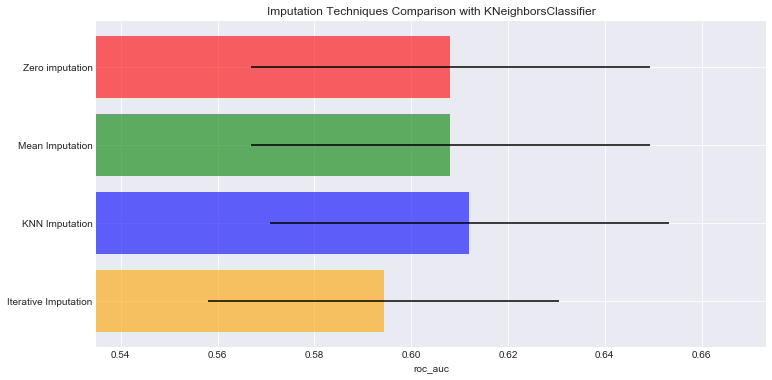

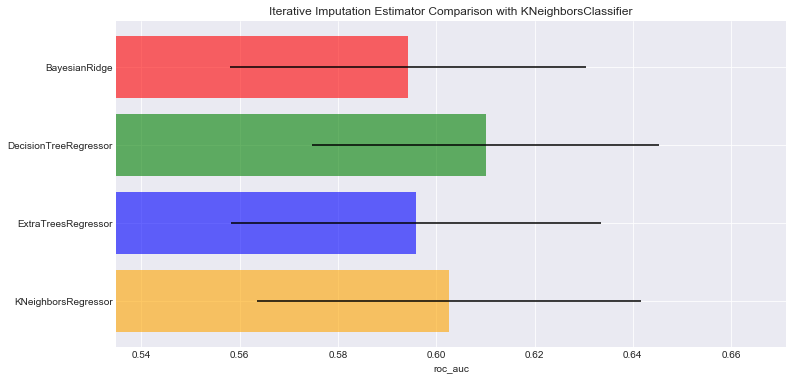

In [138]:
ax1, ax2 = compare_imputer_scores(X_new, y, clf, 'roc_auc', estimators)

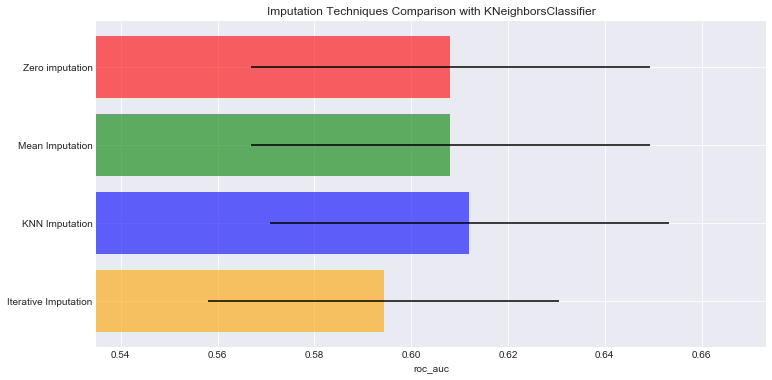

In [139]:
ax1.figure

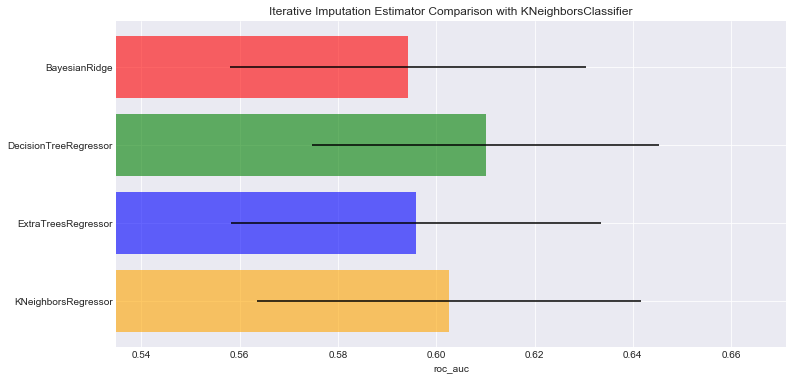

In [140]:
ax2.figure

In [ ]:
# Of everything tried so far, it looks like the KNNImputer did the best job. Let's try a
# different classifier

#### GradientBoostingClassifier

In [141]:
clf = GradientBoostingClassifier()

In [137]:
estimators = [
    BayesianRidge(),
    DecisionTreeRegressor(max_features='sqrt', random_state=123),
    ExtraTreesRegressor(n_estimators=10, max_features='sqrt', random_state=123),
    KNeighborsRegressor(n_neighbors=15)
]

Imputing with IterativeImputer using BayesianRidge estimator
Imputing with IterativeImputer using DecisionTreeRegressor estimator


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


Imputing with IterativeImputer using ExtraTreesRegressor estimator


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


Imputing with IterativeImputer using KNeighborsRegressor estimator


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


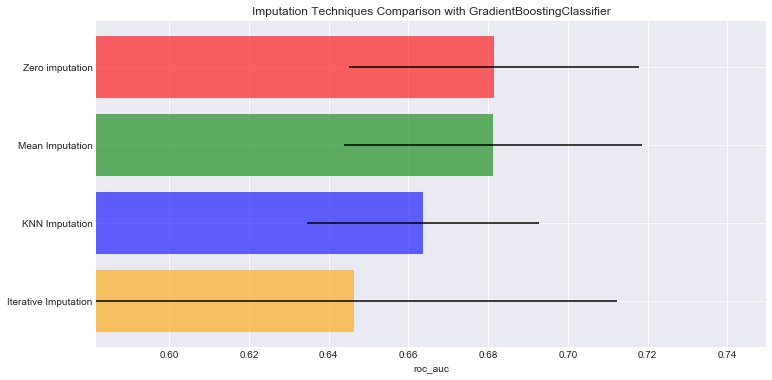

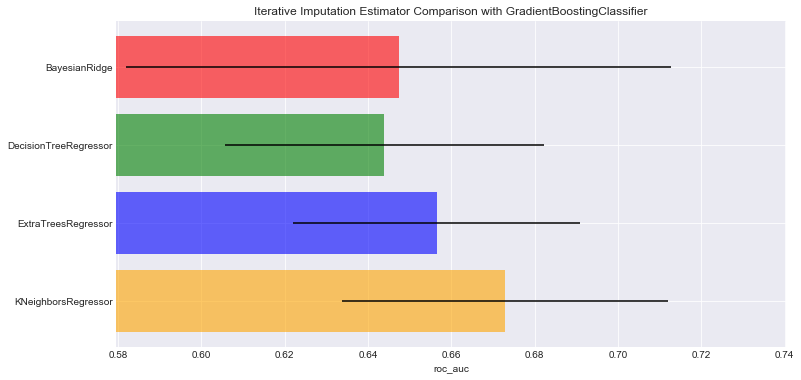

In [142]:
ax1, ax2 = compare_imputer_scores(X_new, y, clf, 'roc_auc', estimators)

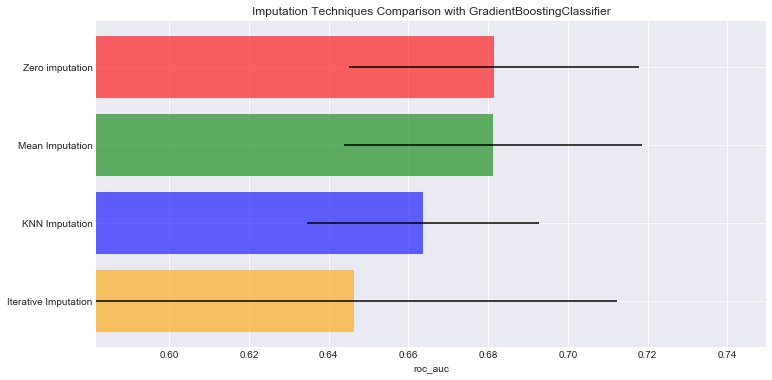

In [143]:
ax1.figure

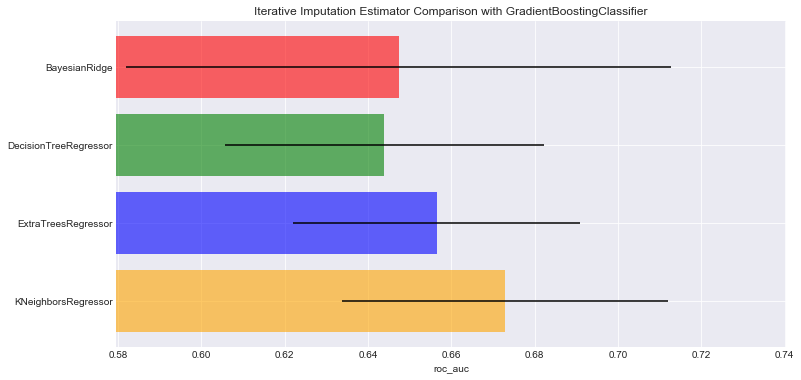

In [144]:
ax2.figure

In [ ]:
# The Mean and Zero imputation are performing the best with the GradientBoostingClassifier

#### AdaBoostClassifier

In [146]:
clf = AdaBoostClassifier(random_state=0)

In [137]:
estimators = [
    BayesianRidge(),
    DecisionTreeRegressor(max_features='sqrt', random_state=123),
    ExtraTreesRegressor(n_estimators=10, max_features='sqrt', random_state=123),
    KNeighborsRegressor(n_neighbors=15)
]

Imputing with IterativeImputer using BayesianRidge estimator
Imputing with IterativeImputer using DecisionTreeRegressor estimator


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


Imputing with IterativeImputer using ExtraTreesRegressor estimator


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


Imputing with IterativeImputer using KNeighborsRegressor estimator


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


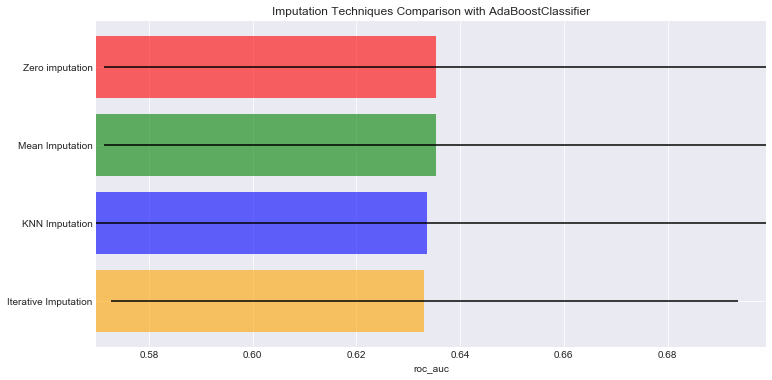

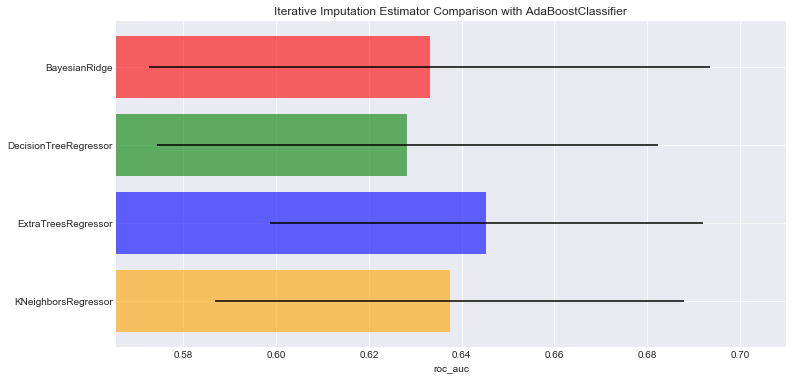

In [147]:
ax1, ax2 = compare_imputer_scores(X_new, y, clf, 'roc_auc', estimators)

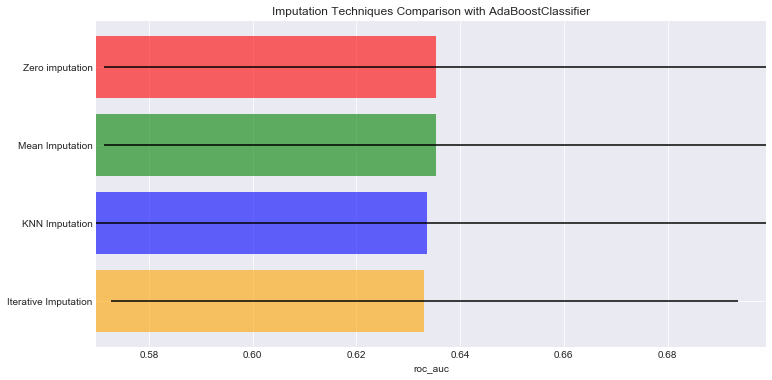

In [148]:
ax1.figure

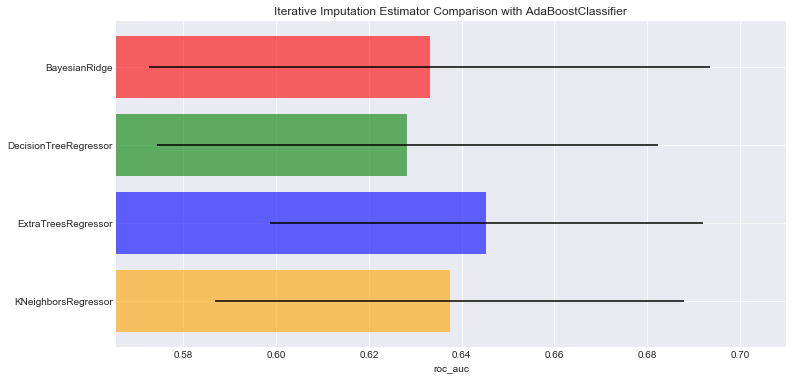

In [149]:
ax2.figure

In [150]:
# These results are lackluster compared to the GradientBoostingClassifier, and the variance
# is very wide.
# A very power classifier to try is the XGBoost classifier

#### XGBClassifier

In [151]:
from xgboost import XGBClassifier

In [152]:
clf = XGBClassifier()

In [153]:
estimators = [
    BayesianRidge(),
    DecisionTreeRegressor(max_features='sqrt', random_state=123),
    ExtraTreesRegressor(n_estimators=10, max_features='sqrt', random_state=123),
    KNeighborsRegressor(n_neighbors=15)
]

Imputing with IterativeImputer using BayesianRidge estimator
Imputing with IterativeImputer using DecisionTreeRegressor estimator


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


Imputing with IterativeImputer using ExtraTreesRegressor estimator


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


Imputing with IterativeImputer using KNeighborsRegressor estimator


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


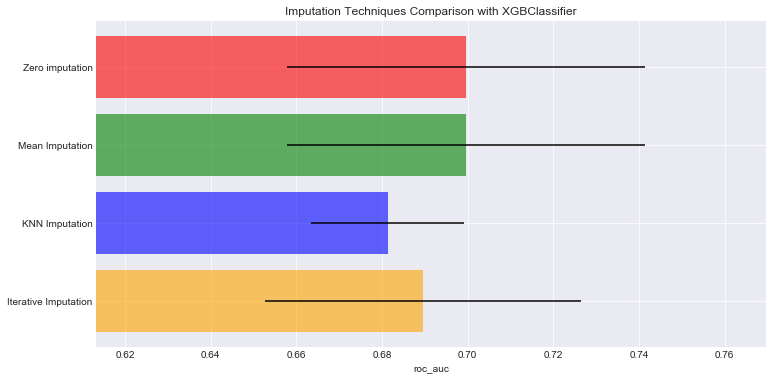

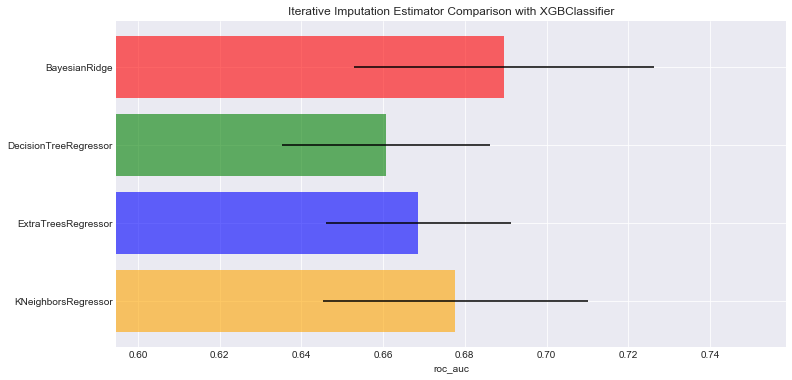

In [154]:
ax1, ax2 = compare_imputer_scores(X_new, y, clf, 'roc_auc', estimators)

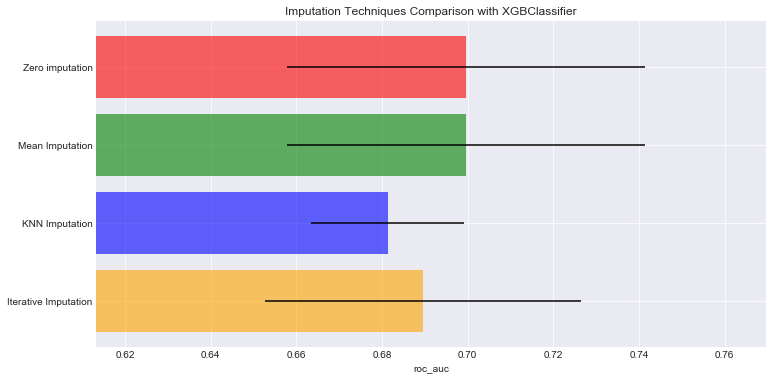

In [155]:
ax1.figure

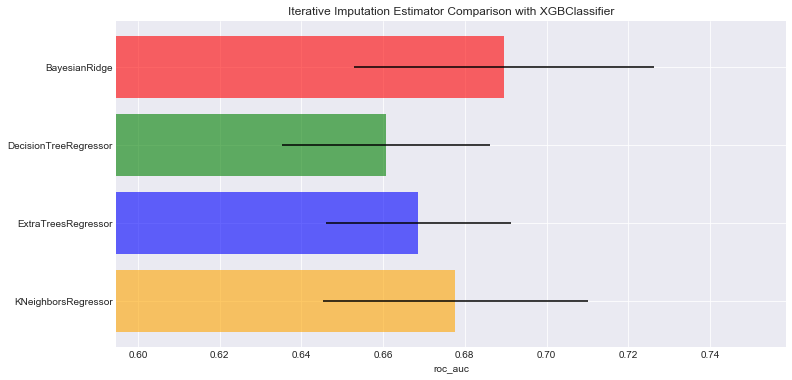

In [156]:
ax2.figure

In [ ]:
# Zero and Mean Imputation have worked the best with the XGBoost Classifier

#### XGBRFClassifier

In [158]:
from xgboost import XGBRFClassifier

In [159]:
clf = XGBRFClassifier(random_state=0)

In [160]:
estimators = [
    BayesianRidge(),
    DecisionTreeRegressor(max_features='sqrt', random_state=123),
    ExtraTreesRegressor(n_estimators=10, max_features='sqrt', random_state=123),
    KNeighborsRegressor(n_neighbors=15)
]

Imputing with IterativeImputer using BayesianRidge estimator
Imputing with IterativeImputer using DecisionTreeRegressor estimator


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


Imputing with IterativeImputer using ExtraTreesRegressor estimator


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


Imputing with IterativeImputer using KNeighborsRegressor estimator


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


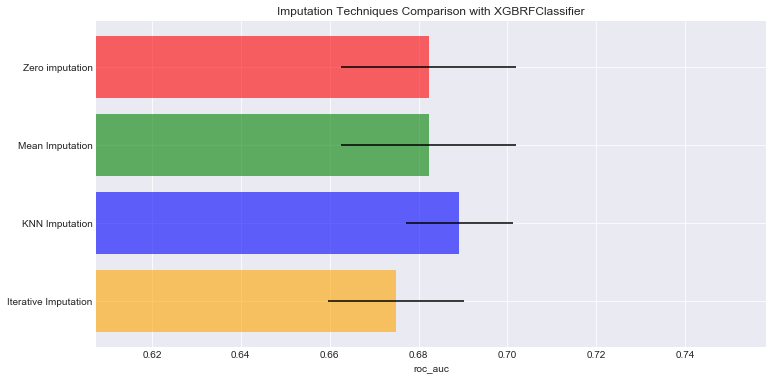

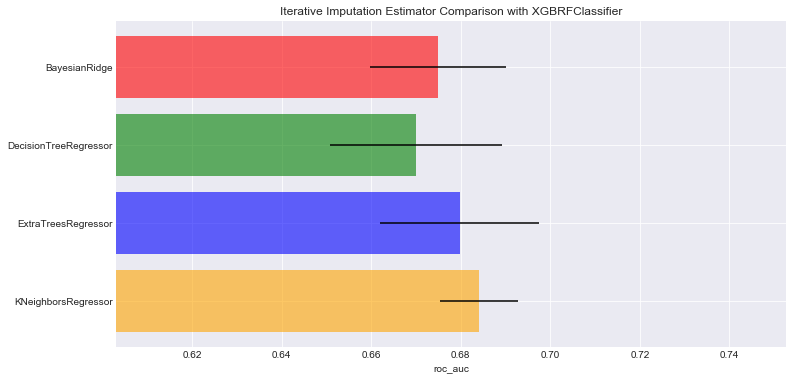

In [161]:
ax1, ax2 = compare_imputer_scores(X_new, y, clf, 'roc_auc', estimators)

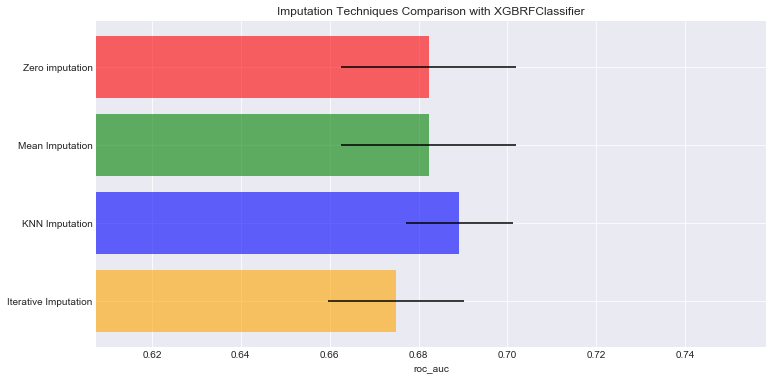

In [162]:
ax1.figure

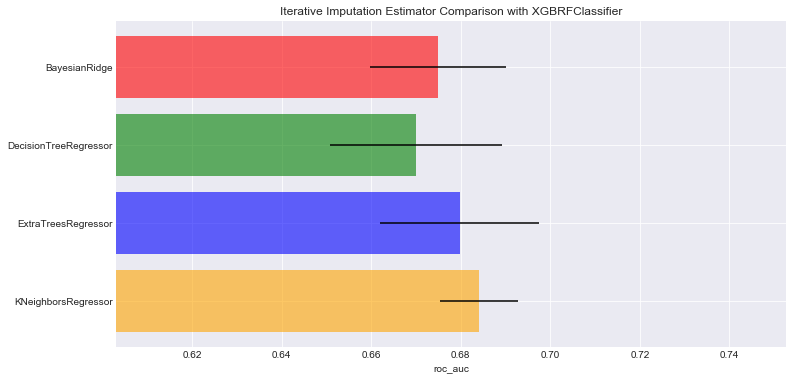

In [163]:
ax2.figure

In [ ]:
# One thing that I notice here is that although the scores are not as high as for the XGBoost,
# the variance of the scores is much tighter. This means that the models generated with this
# algorithm may be more robust to unseen data. Hyperparameter tuning may make this the better
# option of the two, this should be investigated.

## Modeling - Classification

In [268]:
# The best results for this classification task have been with the Zero Imputer and the XGBoost
# classifier, let's try some parameter tuning
scaler = StandardScaler()

imputer = SimpleImputer(strategy='constant', fill_value=0)

clf = XGBClassifier(random_state=0, n_jobs=-1)

steps = [('scaler', scaler),
         ('imputer', imputer),
         ('clf', clf)
        ]
estimator = Pipeline(steps=steps)

param_grid = {'clf__n_estimators': [100, 250, 500],
              'clf__max_depth': [2, 3, 5],
              'clf__learning_rate': [.001, .01, .1, .5],
              'clf__booster': ['gbtree', 'gblinear', 'dart'],
              'clf__reg_alpha': [0, 1],
              'clf__reg_lambda': [.5, 1, 5],
              'clf__subsample': [.5, .75, 1],
              'clf__colsample_bytree': [.7, 1],
              'clf__colsample_bylevel': [.7, 1]
             }

grid_search = GridSearchCV(estimator, 
                           param_grid=param_grid, 
                           scoring='roc_auc', 
                           cv=5,
                           n_jobs=-1,
                           verbose=2
                          )
grid_fit = grid_search.fit(X_new, y)

Fitting 5 folds for each of 7776 candidates, totalling 38880 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   24.8s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   57.8s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed: 10.1min
[Parallel(n_jobs=-1)]: Done 3265 tasks      | elapsed: 12.0min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed: 15.6min
[Parallel(n_jobs=-1)]: Done 4885 tasks      | elapsed: 19.5min
[Parallel(n_jobs=-1)]: Done 5816 tasks      | elapsed: 23.1min
[Parallel(n_jobs=-1)]: Done 6829 tasks      | elapsed: 26.3min
[Parallel(n_jobs=-1)]: Done 7922 tasks      | elapsed: 31.8min
[Parallel(n_jobs=-1)]: Done 9097 tasks      | e

In [331]:
# Let's see what the best score was
grid_fit.best_score_

0.7162452787643045

In [332]:
# This is not a whole lot higher than we got with the out-of-the-box parameters, but it is
# not bad either, and is significantly higher than a .50 (random guess).
grid_fit.best_params_

{'clf__booster': 'gbtree',
 'clf__colsample_bylevel': 1,
 'clf__colsample_bytree': 1,
 'clf__learning_rate': 0.1,
 'clf__max_depth': 3,
 'clf__n_estimators': 100,
 'clf__reg_alpha': 0,
 'clf__reg_lambda': 1,
 'clf__subsample': 1}

In [333]:
# Looks like these are actually the out-of-box parameters
# Let's calculate the probabilities, and see if they have any relationship with the returns
probas = grid_fit.best_estimator_.predict_proba(X_new)
probas[:5]

array([[0.12182909, 0.8781709 ],
       [0.08672547, 0.9132745 ],
       [0.03955919, 0.9604408 ],
       [0.08281821, 0.9171818 ],
       [0.6212164 , 0.37878358]], dtype=float32)

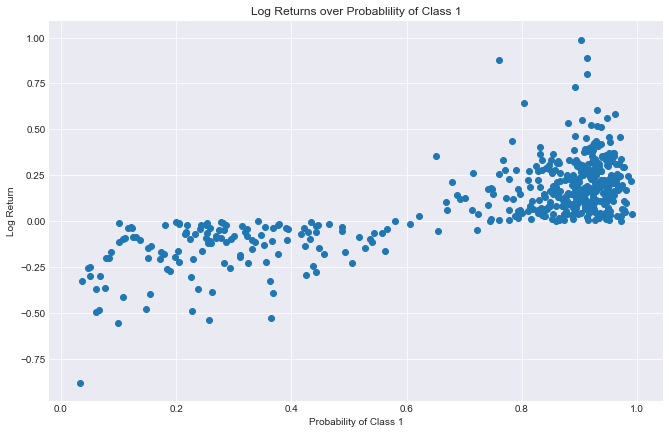

In [334]:
plt.scatter(probas[:, 1], targets.log_return)
plt.title('Log Returns over Probablility of Class 1')
plt.xlabel('Probability of Class 1')
plt.ylabel('Log Return');

In [ ]:
# We can see that there is definitely a relationship here, and that if one were to use a 
# Threshold of 0.6, the model would have likely been profitable, especially if one were to only
# invest or short in securities which had a probability outside of a window around the threshold
# of maybe 0.5-0.7

Text(0.5, 1.0, 'Feature Importance (MDI)')

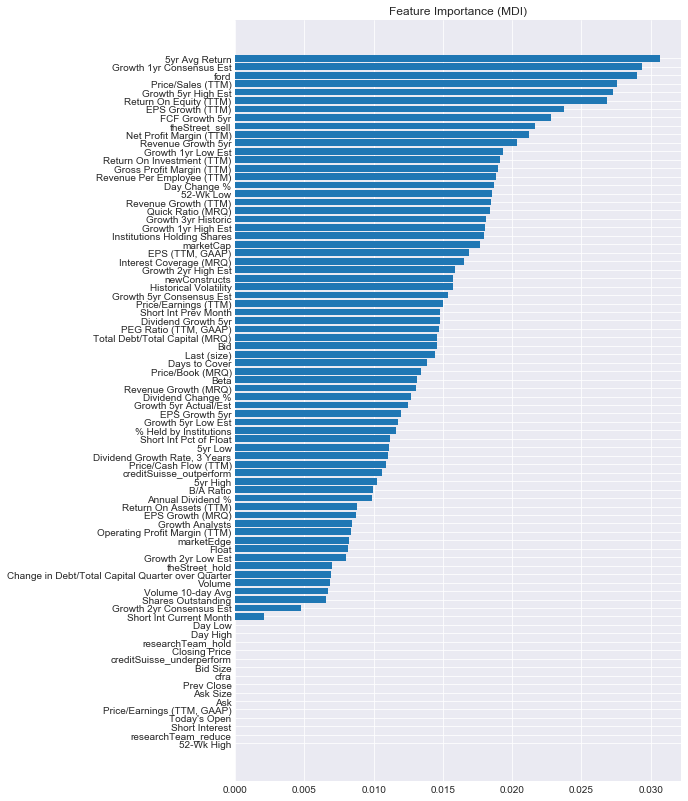

In [356]:
# Let's look at the feature importances for this model, for comparison later
feature_importance = grid_fit.best_estimator_.steps[2][1].feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(8, 14))
plt.subplot(1, 1, 1)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(X_new.columns)[sorted_idx])
plt.title('Feature Importance (MDI)')

In [367]:
# Above we can see the average feature importances of all the trees in the model
# We can get a more nuanced idea of how the features contribute to model accuracy by using
# permutation_importance, which goes through the features one at a time and shuffles them,
# breaking their relationship to the target variable, and tracks the effect on performance
# by doing so. The features which have the most negative impact on performance when shuffled
# are obviously the most important to the model. Again, these may be distorted due to 
# multicollinearity in the data, but will prove useful for comparison later
X_train, X_test, y_train, y_test = train_test_split(X_new, 
                                                    targets.class1, 
                                                    test_size=0.2,
                                                    random_state=0
                                                   )

In [164]:
from sklearn.inspection import permutation_importance

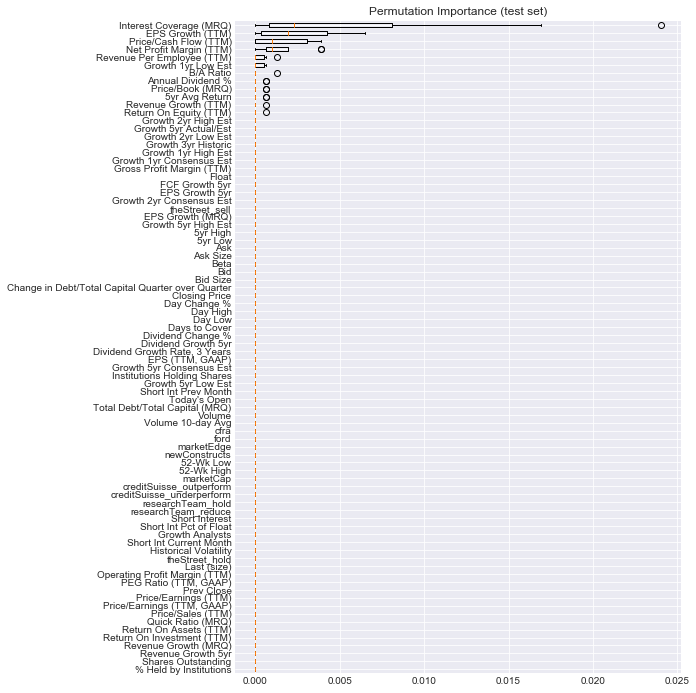

In [369]:
result = permutation_importance(grid_fit.best_estimator_, 
                                X_test, 
                                y_test, 
                                scoring='roc_auc',
                                n_repeats=10,
                                random_state=42, 
                                n_jobs=-1)
sorted_idx = result.importances_mean.argsort()
fig = plt.figure(figsize=(8,12))
plt.subplot(1, 1, 1)
plt.boxplot(result.importances[sorted_idx].T,
            vert=False, labels=np.array(X_new.columns)[sorted_idx])
plt.title("Permutation Importance (test set)")
plt.show()

In [370]:
# Let's compare this to a model with the same parameters fit to a train test split
scaler = StandardScaler()

imputer = SimpleImputer(strategy='constant', fill_value=0)

clf = XGBClassifier(random_state=0, n_jobs=-1)

steps = [('scaler', scaler),
         ('imputer', imputer),
         ('clf', clf)
        ]
estimator = Pipeline(steps=steps)

estimator.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('imputer', SimpleImputer(fill_value=0, strategy='constant')),
                ('clf', XGBClassifier(n_jobs=-1))])

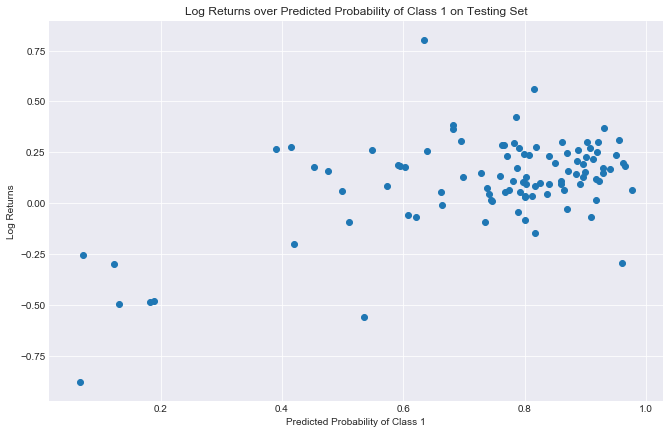

In [371]:
pred_probas = estimator.predict_proba(X_test)
plt.scatter(pred_probas[:, 1], targets.loc[y_test.index, 'log_return'])
plt.title('Log Returns over Predicted Probability of Class 1 on Testing Set')
plt.xlabel('Predicted Probability of Class 1')
plt.ylabel('Log Returns');

In [372]:
# We can see that this model has a slightly more messy set of predictions, with more overlap
# over the zero line. Still, with a threshold around 0.6, the trader would have been right
# more often than not. We can see the fact that the time period of study was a bull's market
# by the fact that most of the securities are above the zero line.

Text(0.5, 1.0, 'Feature Importance (MDI)')

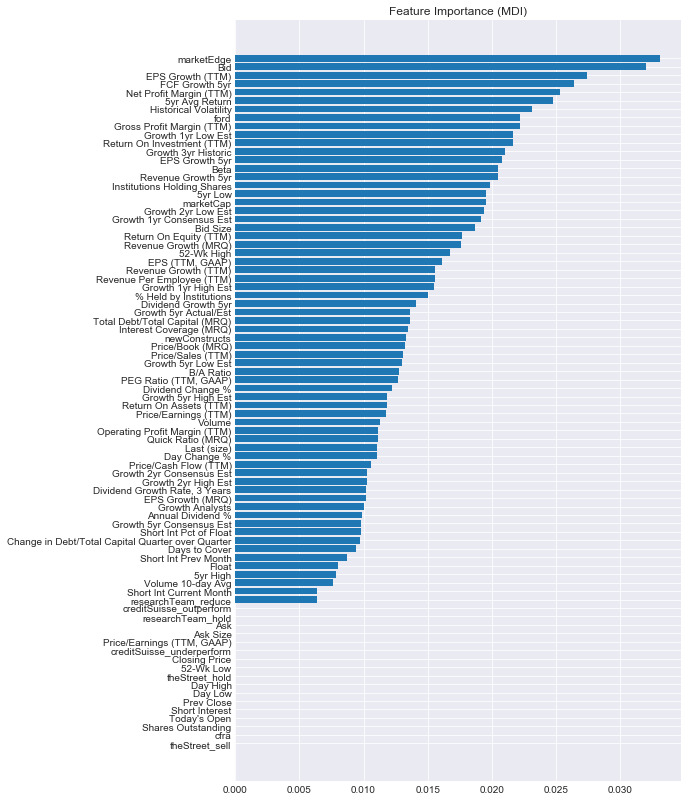

In [373]:
feature_importance = estimator.steps[2][1].feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(8, 14))
plt.subplot(1, 1, 1)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(X_new.columns)[sorted_idx])
plt.title('Feature Importance (MDI)')

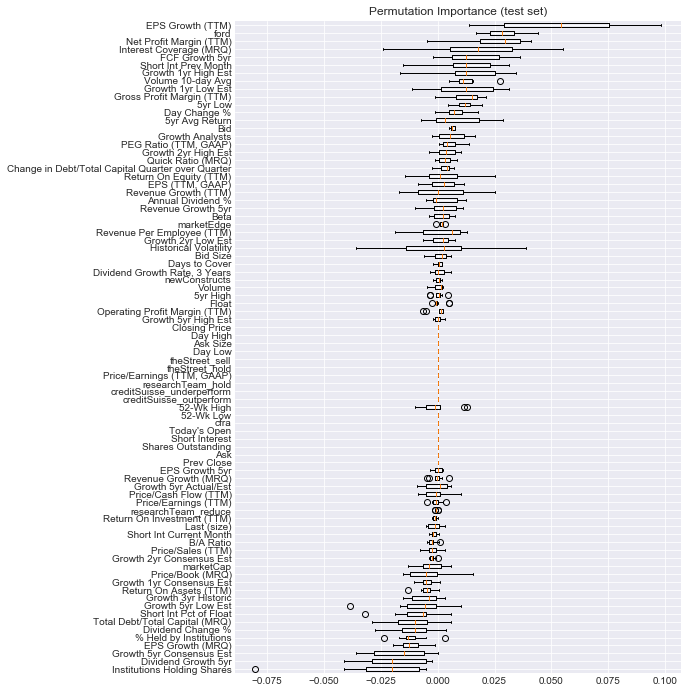

In [374]:
# Here we can see a wildly different set of feature importances than we got from the grid_fit
# estimator. Let's compare the permutation importances.
result = permutation_importance(estimator, 
                                X_test, 
                                y_test, 
                                scoring='roc_auc',
                                n_repeats=10,
                                random_state=42, 
                                n_jobs=-1)
sorted_idx = result.importances_mean.argsort()
fig = plt.figure(figsize=(8,12))
plt.subplot(1, 1, 1)
plt.boxplot(result.importances[sorted_idx].T,
            vert=False, labels=np.array(X_new.columns)[sorted_idx])
plt.title("Permutation Importance (test set)")
plt.show()

In [375]:
# This is interesting. We now see that some of our features have negative permutation importance
# which means that when the feature was shuffled, the resulting model was actually better than
# with the feature left in tact. It is interesting that this was not an issue with the model
# generated from the grid search. We can notice that some of the most valuable features are still
# at the top of this list, namely EPS Growth (TTM), Net Profit Margin (TTM), Interest Coverage
# (MRQ), and Growth 1yr Low Est.
# Let's see what happens if we train another estimator with a different train test split,
# and compare these permutation importances
X_train, X_test, y_train, y_test = train_test_split(X_new,
                                                    targets.class1,
                                                    test_size=0.20,
                                                    random_state=42
                                                   )
estimator = Pipeline(steps=steps)

estimator.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('imputer', SimpleImputer(fill_value=0, strategy='constant')),
                ('clf', XGBClassifier(n_jobs=-1))])

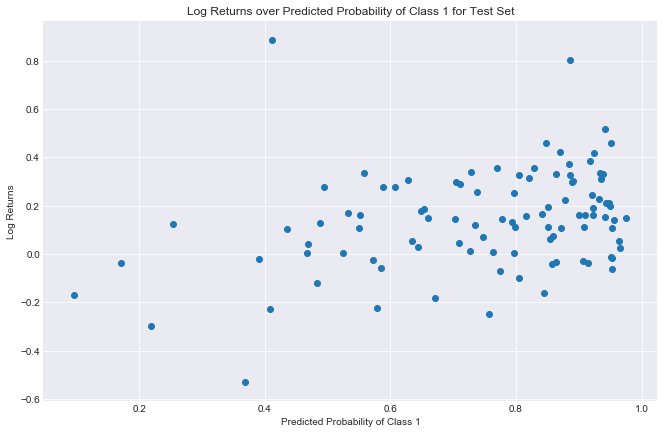

In [388]:
predict_probs = estimator.predict_proba(X_test)
plt.scatter(predict_probs[:,1], log_returns.loc[y_test.index])
plt.xlabel('Predicted Probability of Class 1')
plt.ylabel('Log Returns')
plt.title('Log Returns over Predicted Probability of Class 1 for Test Set');

In [80]:
from sklearn.metrics import roc_auc_score

In [384]:
roc_auc_score(y_test, predict_probs[:, 1])

0.6346153846153846

In [385]:
# We can see once again that the fitted model is far inferior to the one we got from the grid
# search

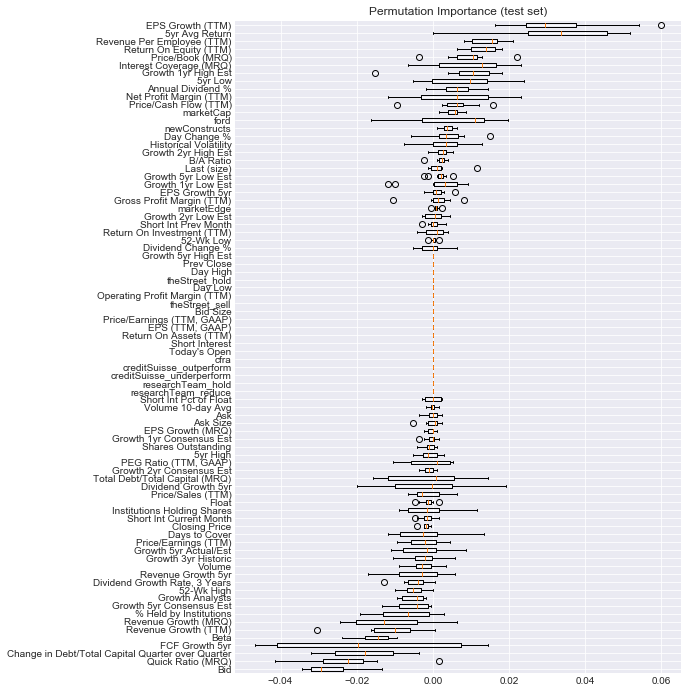

In [386]:
result = permutation_importance(estimator, 
                                X_test, 
                                y_test, 
                                scoring='roc_auc',
                                n_repeats=10,
                                random_state=42, 
                                n_jobs=-1)
sorted_idx = result.importances_mean.argsort()
fig = plt.figure(figsize=(8,12))
plt.subplot(1, 1, 1)
plt.boxplot(result.importances[sorted_idx].T,
            vert=False, labels=np.array(X_new.columns)[sorted_idx])
plt.title("Permutation Importance (test set)")
plt.show()

In [394]:
# We can see that although some of the same features appear towards the top here, the results
# of the permutation importances are kind of all over the place. Also, the roc_auc scores of 
# the models fit outside of the grid search are much lower, and the predicted probabilities
# are far less correlated to log returns.
# I have a sneaking suspicion that the zero imputation method may have something to do with what
# we are seeing here. Since we have been simply replacing all missing values with zeros, it
# is understandable that shuffling the columns is having drastic effects on model performance.
# Perhaps it would be better to use a more sophisticated imputation method, and see how that
# affects the fits and permutation importances.
# Earlier, fairly good results were obtained using the XGBRF Classifier with the KNNImputer
# Let's compare models generated this way.
scaler = StandardScaler()

imputer = KNNImputer(weights='distance')

clf = XGBRFClassifier(random_state=0, n_jobs=-1)

steps = [('scaler', scaler),
         ('imputer', imputer),
         ('clf', clf)
        ]
estimator = Pipeline(steps=steps)

param_grid = {'imputer__n_neighbors': [5, 10, 15],
              'clf__n_estimators': [100, 300, 500],
              'clf__max_depth': [2, 3, 5],
              'clf__learning_rate': [.01, .1, 1, 2],
              'clf__reg_alpha': [0, 0.5, 1],
              'clf__reg_lambda': [.5, 1, 5],
              'clf__subsample': [.7, .8, 1],
              'clf__colsample_bytree': [.8, 1],
              'clf__colsample_bylevel': [.8, 1]
             }

grid_search = GridSearchCV(estimator, 
                           param_grid=param_grid, 
                           scoring='roc_auc', 
                           cv=5,
                           n_jobs=-1,
                           verbose=2
                          )
grid_fit = grid_search.fit(X_new, y)

Fitting 5 folds for each of 11664 candidates, totalling 58320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   31.8s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done 3265 tasks      | elapsed: 12.2min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed: 16.7min
[Parallel(n_jobs=-1)]: Done 4885 tasks      | elapsed: 19.8min
[Parallel(n_jobs=-1)]: Done 5816 tasks      | elapsed: 23.1min
[Parallel(n_jobs=-1)]: Done 6829 tasks      | elapsed: 28.2min
[Parallel(n_jobs=-1)]: Done 7922 tasks      | elapsed: 33.8min
[Parallel(n_jobs=-1)]: Done 9097 tasks      | e

In [395]:
# Let's see what the best score was
grid_fit.best_score_

0.7058909746885395

In [396]:
# This is only slightly lower than our best score from the XGBClassifier
# Let's look at the parameters
grid_fit.best_params_

{'clf__colsample_bylevel': 1,
 'clf__colsample_bytree': 0.8,
 'clf__learning_rate': 0.01,
 'clf__max_depth': 5,
 'clf__n_estimators': 300,
 'clf__reg_alpha': 0,
 'clf__reg_lambda': 0.5,
 'clf__subsample': 0.8,
 'imputer__n_neighbors': 5}

In [407]:
# Looks like these are actually the out-of-box parameters
# Let's calculate the probabilities, and see if they have any relationship with the returns
probas = grid_fit.best_estimator_.predict_proba(X_new)
probas[:5]

array([[0.49717587, 0.5028241 ],
       [0.49743098, 0.502569  ],
       [0.49650198, 0.503498  ],
       [0.4970023 , 0.5029977 ],
       [0.49956423, 0.50043577]], dtype=float32)

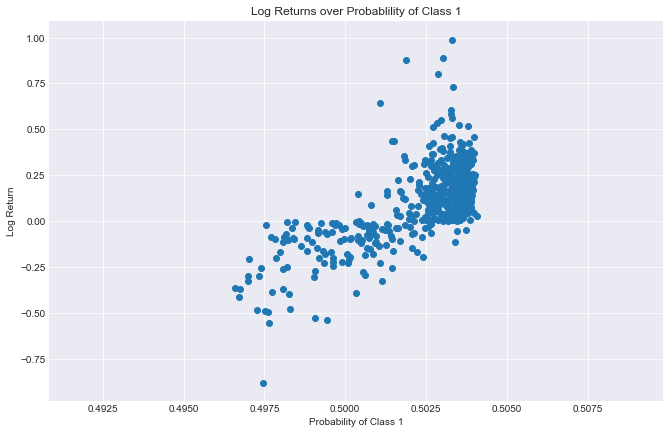

In [408]:
plt.scatter(probas[:, 1], targets.log_return)
plt.title('Log Returns over Probablility of Class 1')
plt.xlabel('Probability of Class 1')
plt.ylabel('Log Return');

In [399]:
# We can see that the predicted probabilities of this model have a very tight distribution,
# with the extremes not even going past .495 or .505. There does seem to be a very strong
# linear relationsip here, which is good.

In [81]:
# Let's do a linear regression between these two variables and see how strong the relationship
# is
import my_functions as mf

             0         1
A     0.502824  0.250673
AAL   0.502569  0.095848
AAP   0.503498  0.161577
AAPL  0.502998  0.398815
ABBV  0.500436 -0.014316
Linear Regression for log_return~probs


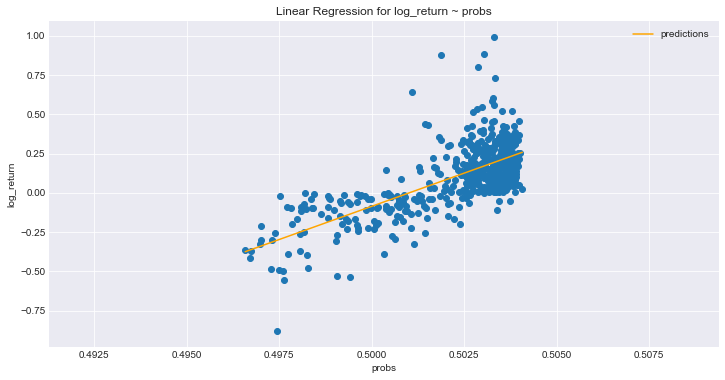

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             log_return   R-squared:                       0.474
Model:                            OLS   Adj. R-squared:                  0.473
Method:                 Least Squares   F-statistic:                     448.6
Date:                Fri, 06 Nov 2020   Prob (F-statistic):           1.99e-71
Time:                        16:18:11   Log-Likelihood:                 217.45
No. Observations:                 499   AIC:                            -430.9
Df Residuals:                     497   BIC:                            -422.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -42.3750      2.006    -21.126      0.000     -46.316     -38.434
probs         84.5768      3.993     21.180      0.000      76.731      92.423
==============================================================================
Omnibus:                      124.206   Durbin-Watson:                   1.909
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              456.384
Skew:                           1.096   Prob(JB):                    7.90e-100
Kurtosis:                       7.140   Cond. No.                         712.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Test for homoscedasticity of residuals:


F_statistic      p_value
Goldfeld-Quandt     1.57257  0.000777068

Normality Test Results for ['residuals']:
-------------------------------------------------------------------------------------------


K-S and Shapiro-Wilk: 
 
 
 
 
 K-S 
 Shapiro-Wilk 
 
 
 
 
 residuals 
 Statistic 
 3.789163e-01 
 9.369934e-01 
 
 
 p-value 
 6.783606e-65 
 1.102306e-13 
 
 
 Anderson-Darling: 
 
 
 
 statistic 
 critical 
 
 
 
 
 residuals 
 4.422651 
 0.781 
 
 
 Jarque-Bera: 
 
 
 
 residuals 
 
 
 
 
 Statistic 
 4.563842e+02 
 
 
 p-value 
 7.896577e-100 
 
 
 Skew 
 1.096356e+00 
 
 
 Kurtosis 
 7.140333e+00

Skew: 1.0963558758263345
Kurtosis: 4.14033277973083


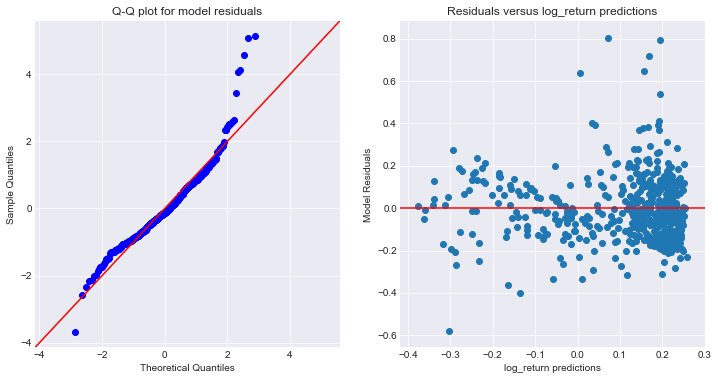

In [428]:
test_df = pd.DataFrame(list(zip(probas[:,1], log_returns.log_return)), index=log_returns.index)
print(test_df.head())
test_df.columns = ['probs', 'log_return']
mf.do_a_linreg(test_df, ['probs'], 'log_return')

In [ ]:
# We can see there is a definitive relationship here. This is interesting, because before when
# we were tryhing to train regressors on the data to model returns, the r-squared was very low,
# around .20, but now when we do a simple linear regression between the predicted probabilities
# from our classifiers and the log returns, we are getting a much higher r-squared around .40

Text(0.5, 1.0, 'Feature Importance (MDI)')

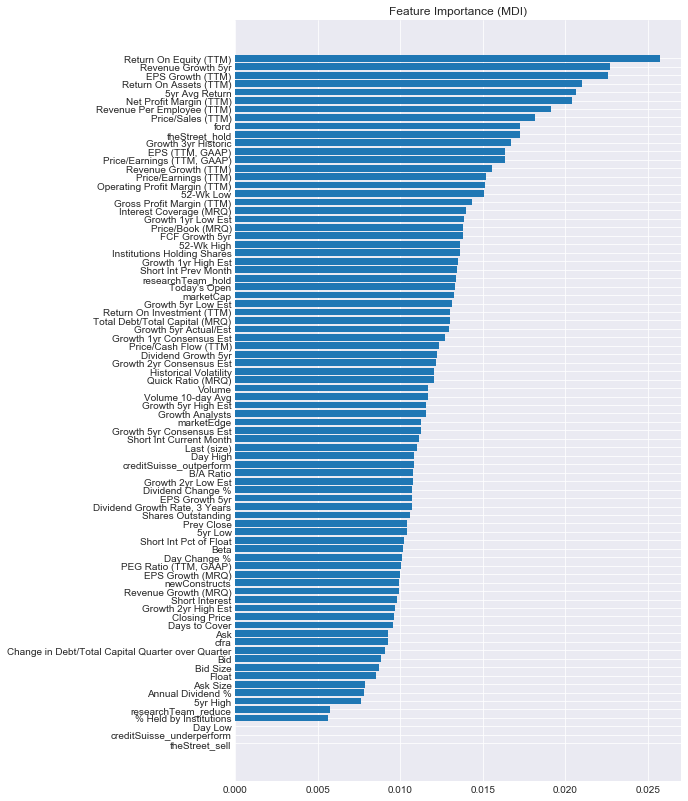

In [400]:
# Let's look at the feature importances for this model
feature_importance = grid_fit.best_estimator_.steps[2][1].feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(8, 14))
plt.subplot(1, 1, 1)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(X_new.columns)[sorted_idx])
plt.title('Feature Importance (MDI)')

In [401]:
# Above we can see the average feature importances of all the trees in the model
# We can get a more nuanced idea of how the features contribute to model accuracy by using
# permutation_importance, which goes through the features one at a time and shuffles them,
# breaking their relationship to the target variable, and tracks the effect on performance
# by doing so. The features which have the most negative impact on performance when shuffled
# are obviously the most important to the model.
X_train, X_test, y_train, y_test = train_test_split(X_new, 
                                                    targets.class1, 
                                                    test_size=0.2,
                                                    random_state=0
                                                   )

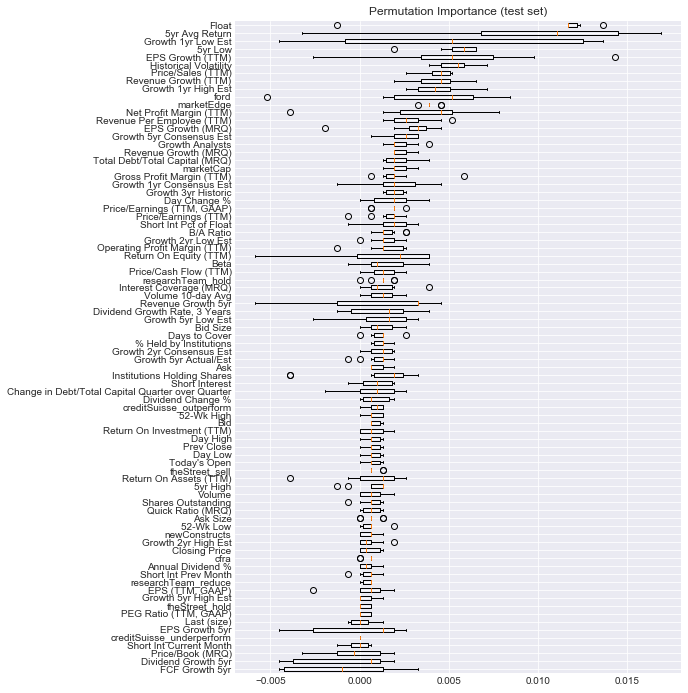

In [402]:
result = permutation_importance(grid_fit.best_estimator_, 
                                X_test, 
                                y_test, 
                                scoring='roc_auc',
                                n_repeats=10,
                                random_state=42, 
                                n_jobs=-1)
sorted_idx = result.importances_mean.argsort()
fig = plt.figure(figsize=(8,12))
plt.subplot(1, 1, 1)
plt.boxplot(result.importances[sorted_idx].T,
            vert=False, labels=np.array(X_new.columns)[sorted_idx])
plt.title("Permutation Importance (test set)")
plt.show()

In [429]:
# Again we see a new mixture of variables at the top and bottom of the chart. Let's see what
# it looks like if we train a model with the hyperparameters above on the train set
scaler = StandardScaler()

imputer = KNNImputer(n_neighbors=5, weights='distance')

clf = XGBRFClassifier(colsample_bytree=0.8,
                      learning_rate=0.01,
                      max_depth=5,
                      n_estimators=300,
                      reg_lambda=0.5,
                      random_state=0, 
                      n_jobs=-1)

steps = [('scaler', scaler),
         ('imputer', imputer),
         ('clf', clf)
        ]
estimator = Pipeline(steps=steps)

estimator.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('imputer', KNNImputer(weights='distance')),
                ('clf',
                 XGBRFClassifier(colsample_bytree=0.8, learning_rate=0.01,
                                 max_depth=5, n_estimators=300, n_jobs=-1,
                                 reg_lambda=0.5))])

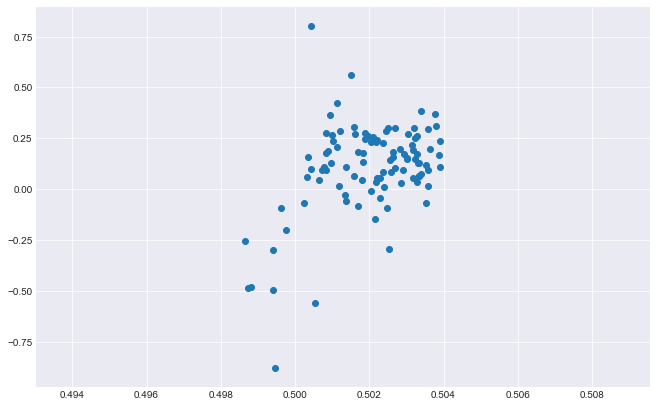

In [430]:
probas = estimator.predict_proba(X_test)
plt.scatter(probas[:,1], log_returns.loc[y_test.index])

             0         1
CHTR  0.500773  0.111397
JNJ   0.503516 -0.067022
LNT   0.502641  0.160579
TWTR  0.501496  0.560618
WDC   0.502156 -0.148248
Linear Regression for log_return~probs


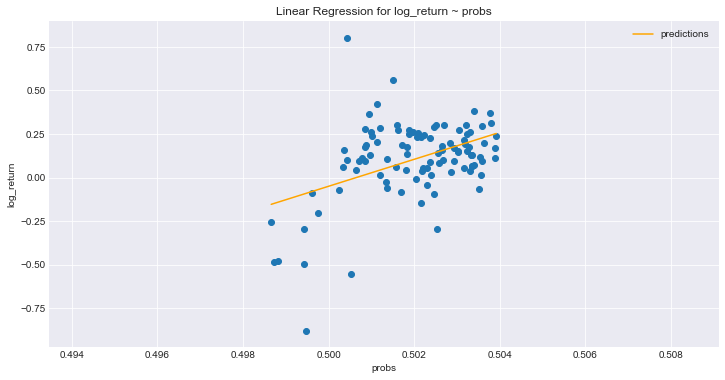

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             log_return   R-squared:                       0.191
Model:                            OLS   Adj. R-squared:                  0.183
Method:                 Least Squares   F-statistic:                     23.15
Date:                Fri, 06 Nov 2020   Prob (F-statistic):           5.44e-06
Time:                        16:20:37   Log-Likelihood:                 16.851
No. Observations:                 100   AIC:                            -29.70
Df Residuals:                      98   BIC:                            -24.49
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -38.7588      8.078     -4.798      0.000     -54.789     -22.729
probs         77.4174     16.091      4.811      0.000      45.486     109.349
==============================================================================
Omnibus:                       14.877   Durbin-Watson:                   2.054
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               57.536
Skew:                          -0.102   Prob(JB):                     3.21e-13
Kurtosis:                       6.710   Cond. No.                         975.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Test for homoscedasticity of residuals:


F_statistic     p_value
Goldfeld-Quandt    0.416669  0.00494933

Normality Test Results for ['residuals']:
-------------------------------------------------------------------------------------------


K-S and Shapiro-Wilk: 
 
 
 
 
 K-S 
 Shapiro-Wilk 
 
 
 
 
 residuals 
 Statistic 
 3.569296e-01 
 0.939451 
 
 
 p-value 
 6.573275e-12 
 0.000179 
 
 
 Anderson-Darling: 
 
 
 
 statistic 
 critical 
 
 
 
 
 residuals 
 1.308803 
 0.759 
 
 
 Jarque-Bera: 
 
 
 
 residuals 
 
 
 
 
 Statistic 
 5.753614e+01 
 
 
 p-value 
 3.207638e-13 
 
 
 Skew 
 -1.018999e-01 
 
 
 Kurtosis 
 6.710410e+00

Skew: -0.1018999010252318
Kurtosis: 3.7104096588302538


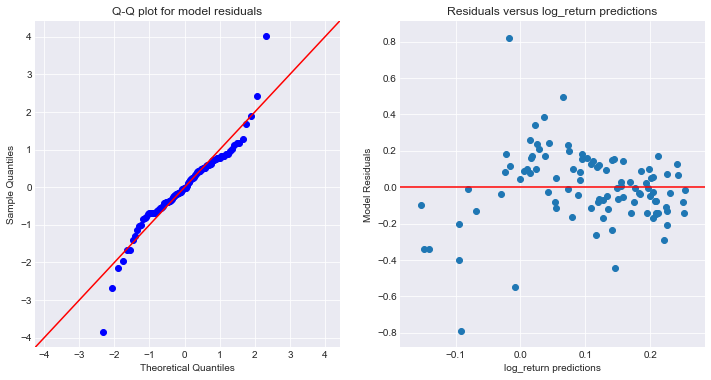

In [432]:
test_df = pd.DataFrame(list(zip(probas[:,1], 
                                log_returns.loc[y_test.index, 'log_return'])), 
                       index=y_test.index)
print(test_df.head())
test_df.columns = ['probs', 'log_return']
mf.do_a_linreg(test_df, ['probs'], 'log_return')

Text(0.5, 1.0, 'Feature Importance (MDI)')

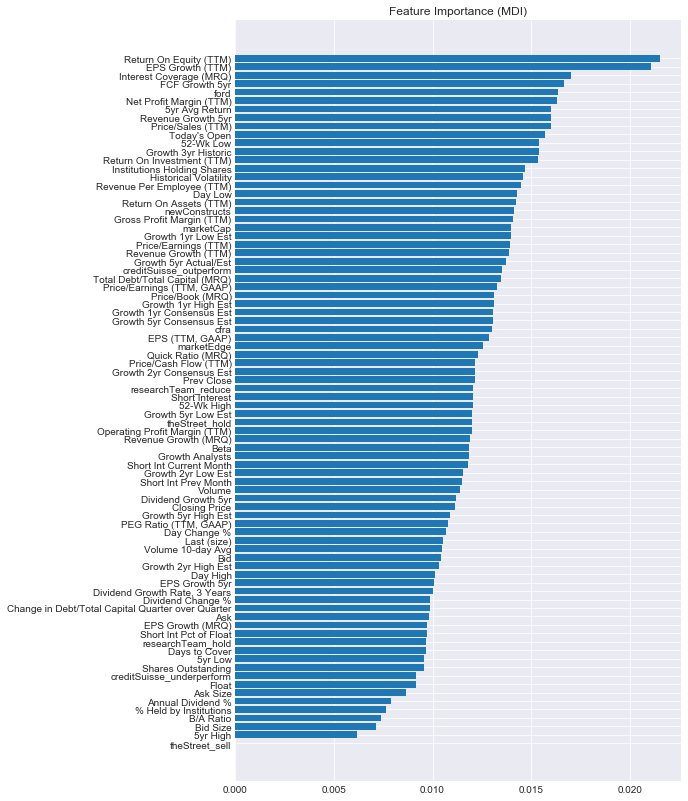

In [405]:
# Let's look at the feature importances for this model
feature_importance = estimator.steps[2][1].feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(8, 14))
plt.subplot(1, 1, 1)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(X_new.columns)[sorted_idx])
plt.title('Feature Importance (MDI)')

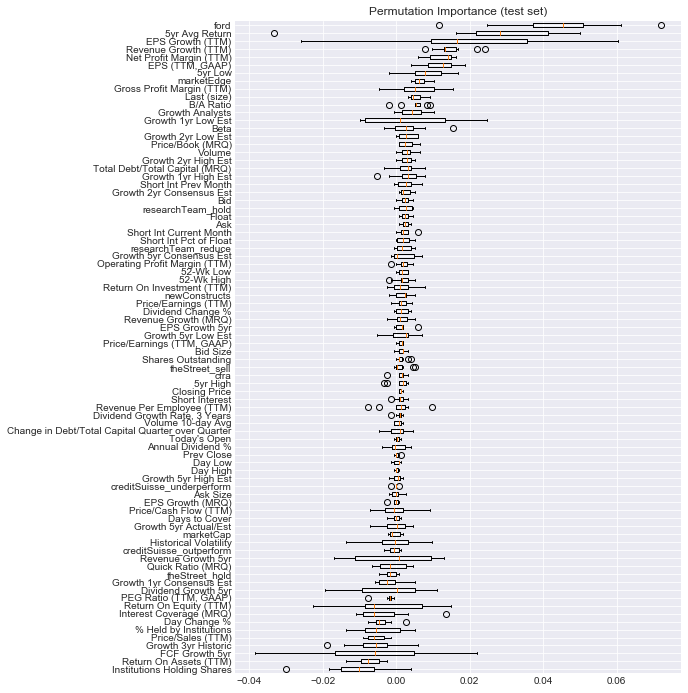

In [404]:
result = permutation_importance(estimator, 
                                X_test, 
                                y_test, 
                                scoring='roc_auc',
                                n_repeats=10,
                                random_state=42, 
                                n_jobs=-1)
sorted_idx = result.importances_mean.argsort()
fig = plt.figure(figsize=(8,12))
plt.subplot(1, 1, 1)
plt.boxplot(result.importances[sorted_idx].T,
            vert=False, labels=np.array(X_new.columns)[sorted_idx])
plt.title("Permutation Importance (test set)")
plt.show()

In [ ]:
# Again, we are seeing a shuffling of feature importances. Some features have been consistently
# found at the top of the list, but it would be nice to see more consistency in these readings.
# It has come to my attention that having multicolinearity in the dataset can affect the
# interpretability of feature importances in tree ensembles (although it is not important
# to deal with it if you are only interested in model accuracy). This means that examining and
# removing highly correlated features may help with the issue we are having here.

<a id='removing_multicollinearity'></a>
## Removing Multicollinearity
So far we have trained all of our models on a dataset which had a lot of multicollinearity present. While this may not necessarily have an impact on model accuracy, it does have an impact of analysis of feature importances, as the importances of certain features may be distorted by the presence of other features with which they are highly correlated. This is the same as the impact of multicollinearity on interpreting the coefficients of linear regression. I will now proceed to locate and manage multicollinearity, to see the effect on both the accuracy of the model and the feature importances.

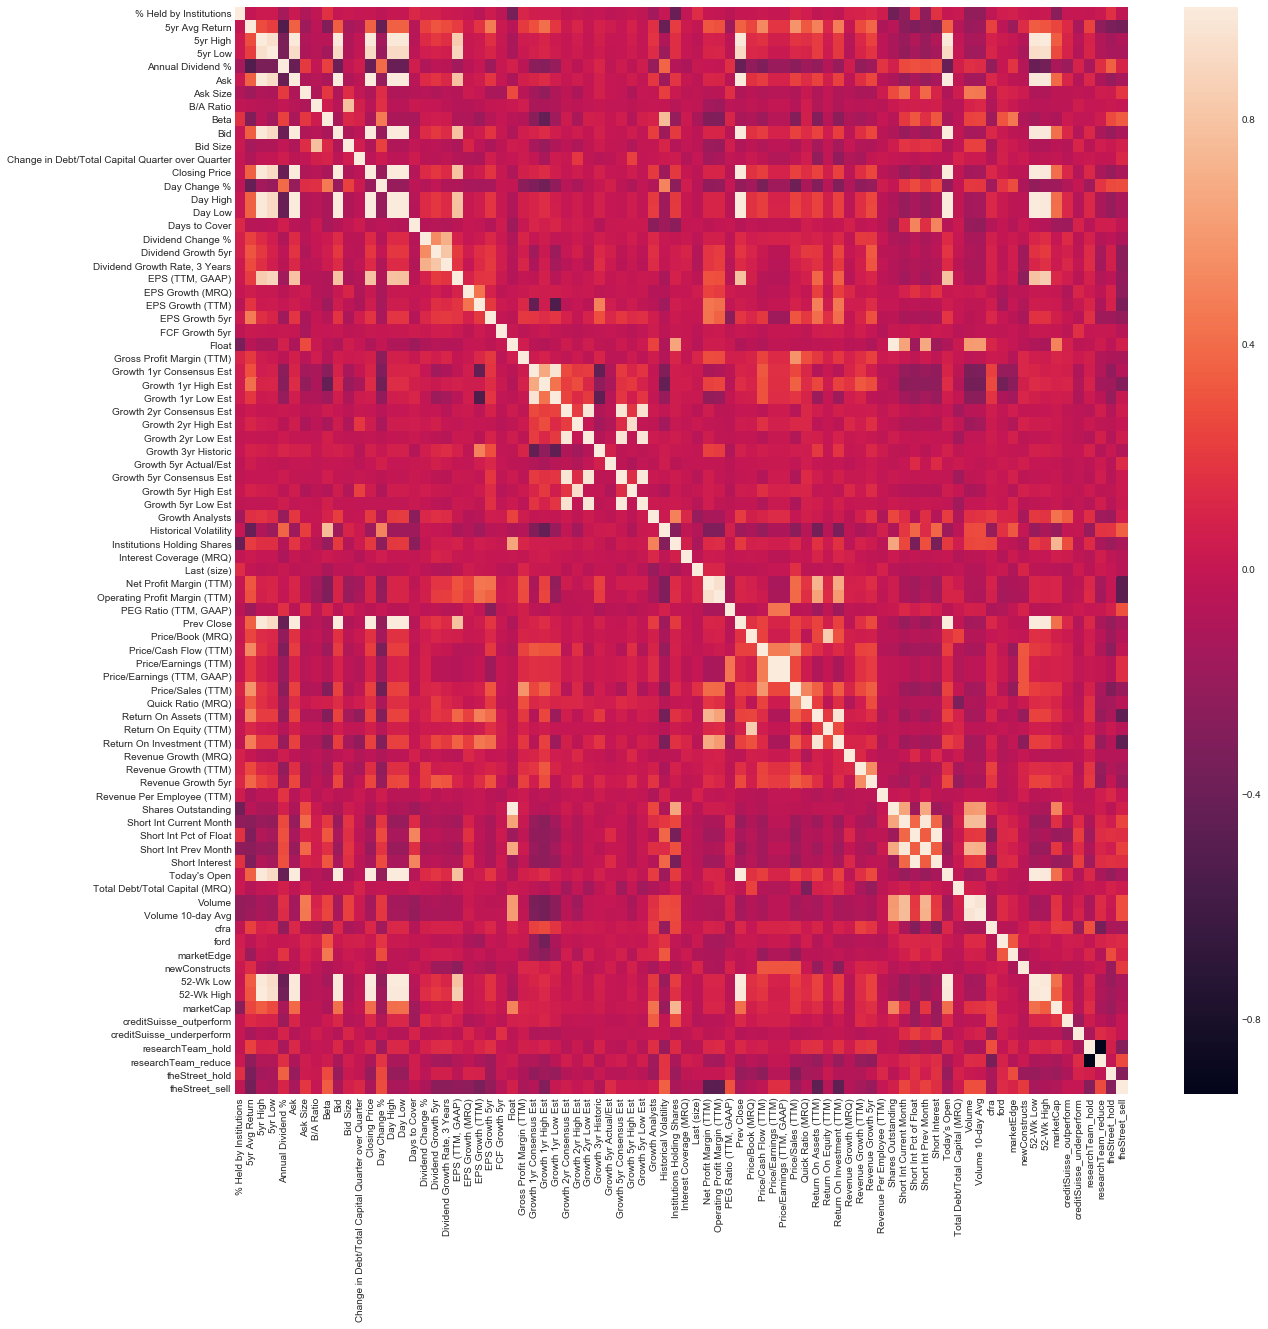

In [174]:
# Let's start off by examining a correlation matrix, and see if it explains any of the behavior
# we were seeing above.
corr = X_new.corr()
plt.figure(figsize=(20,20))
sns.heatmap(corr);

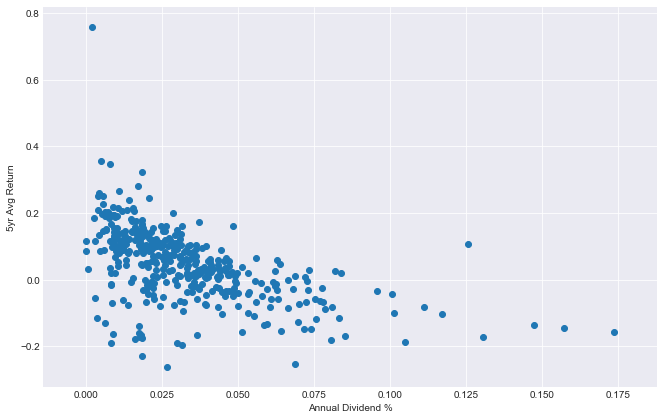

In [175]:
# Interestingly, it appears that Annual Dividend % has an inverse relationship with many price
# based features. Let's take a look at its relationship to 5yr Avg Return
plt.scatter(X_new['Annual Dividend %'], X_new['5yr Avg Return'])
plt.xlabel('Annual Dividend %')
plt.ylabel('5yr Avg Return');

In [176]:
# There is a strong negative relationship here. The reason for this is at least part to do with
# the fact that when a dividend is paid out for a stock, the value of the dividend is subtracted
# from the price of that stock, so naturally, if a yearly dividend is a significant portion of
# the price of a share of stock, it is going to have a negative effect on the growth rate of
# that stock.
# Annual Dividend % was not proving to be a powerful predictor earlier, possibly because it was
# getting overtaken by the importance of the 5yr average return, since they would be competing
# Let's see which one is missing more values.
X_new[['Annual Dividend %', '5yr Avg Return']].info()

<class 'pandas.core.frame.DataFrame'>
Index: 499 entries, A to ZTS
Data columns (total 2 columns):
Annual Dividend %    392 non-null float64
5yr Avg Return       499 non-null float64
dtypes: float64(2)
memory usage: 31.7+ KB


In [177]:
# Looks like dropping Annual Dividend % is the way to go here

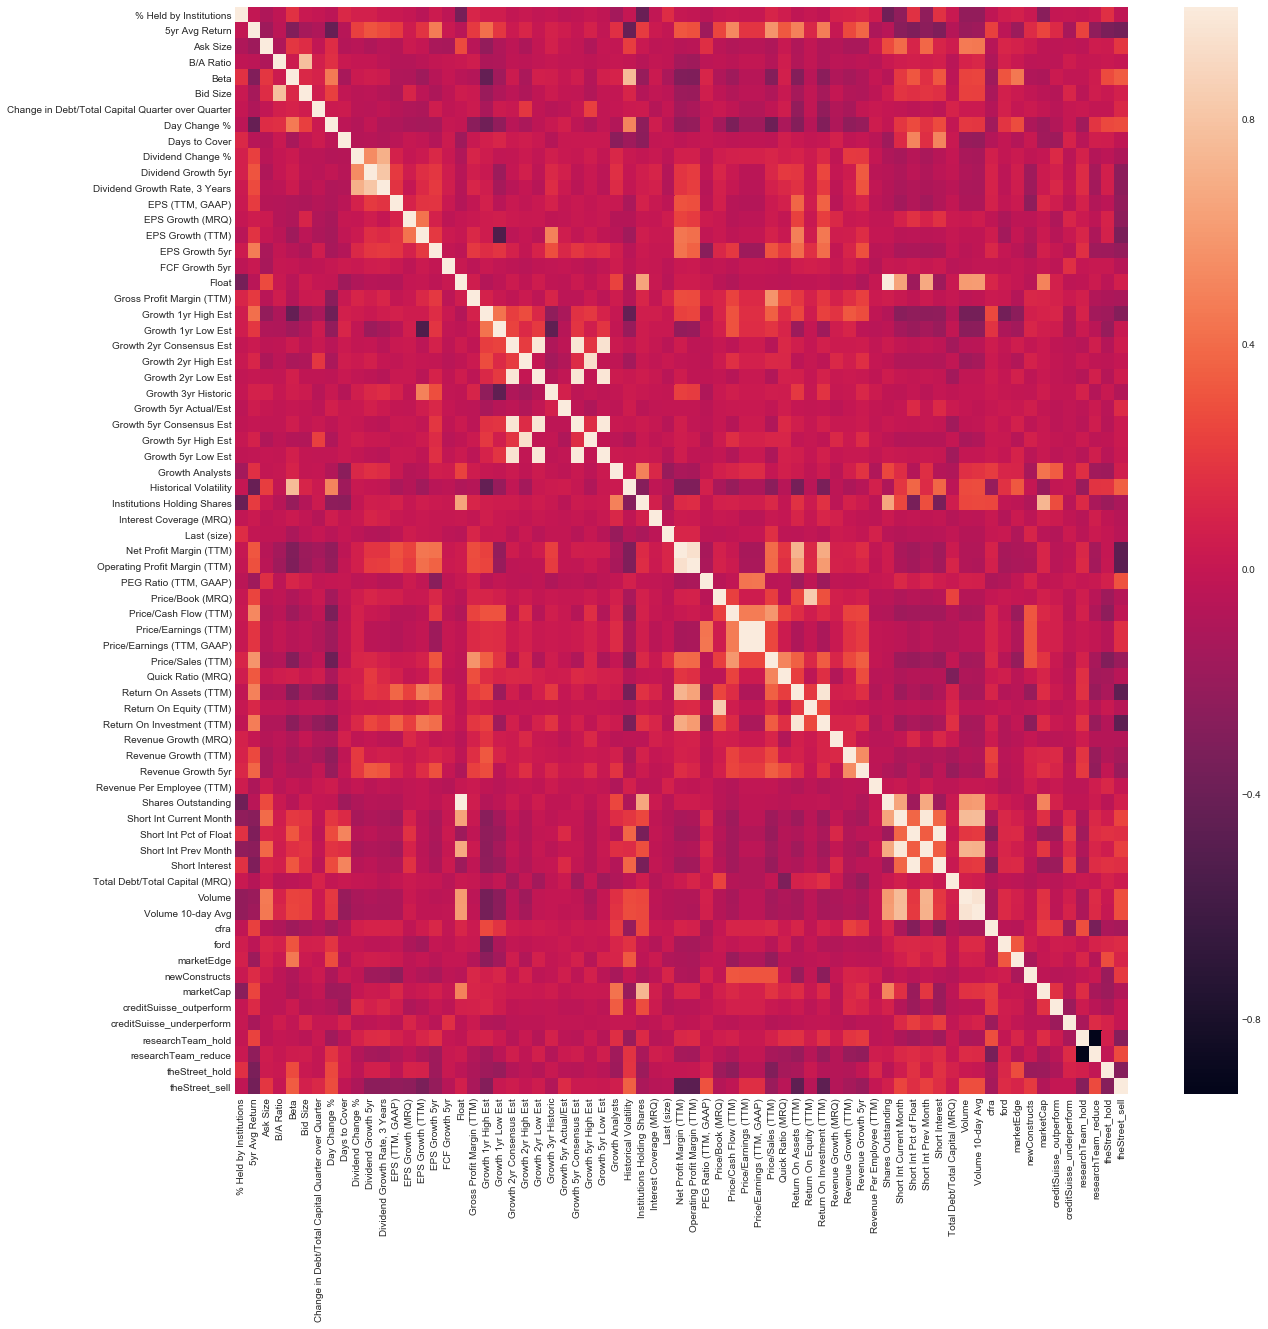

In [178]:
# Looking at the correlation matrix, we can see that the price related features all have
# collinearity with each other, as well as other features such as EPS. We can start by removing
# these features to see if it makes the feature importances more consistent.
# Also, the Growth 1yr features are highly correlated, and we can see above the the Growth
# 1yr low estimate was consistently more important than the other two, and that Growth 1yr
# consensus was the least useful generally. We can keep Low and High, since they are not
# as correlated as the others
X_reduced = X_new.drop(columns=['5yr High',
                                '5yr Low',
                                'Ask',
                                'Bid',
                                'Closing Price',
                                'Day High',
                                'Day Low',
                                'Prev Close',
                                "Today's Open",
                                '52-Wk High',
                                '52-Wk Low',
                                'Growth 1yr Consensus Est',
                                'Annual Dividend %'
                              ])
# Let's take another look now
corr = X_reduced.corr()
plt.figure(figsize=(20,20))
sns.heatmap(corr)

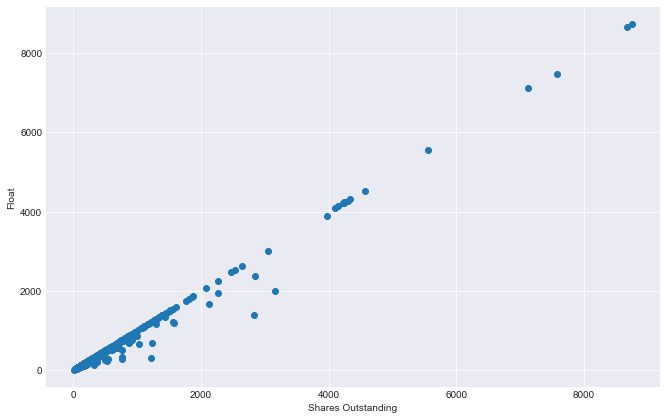

In [179]:
# The 5yr Growth measurements were not scoring very high above, and are highly correlated with
# the 2yr estimates, I'm going to get rid of all the 5yr estimates and the 2yr consensus est.
# Shares outstanding and float are basically the same thing, let's look at them together to see
plt.scatter(X_reduced['Shares Outstanding'], X_reduced['Float'])
plt.xlabel('Shares Outstanding')
plt.ylabel('Float');

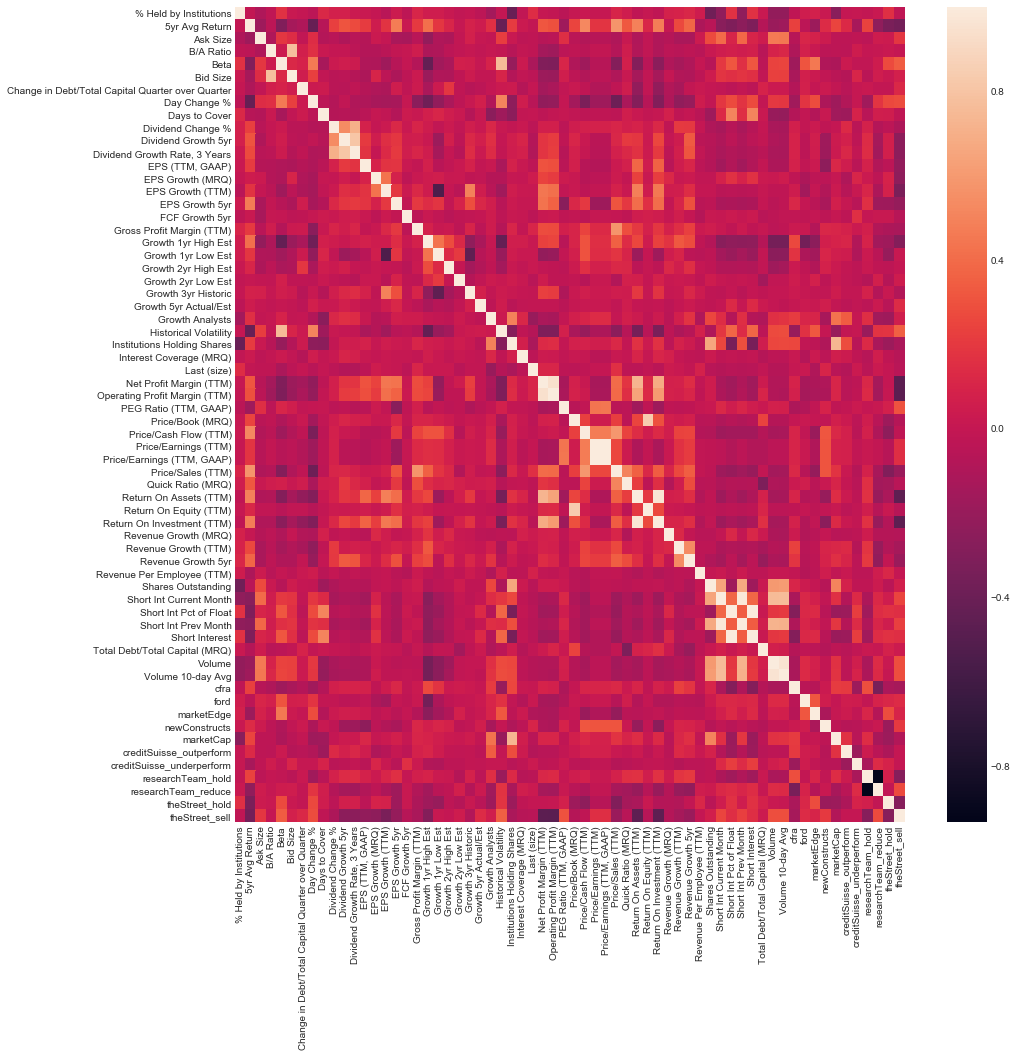

In [180]:
# Float is never higher than Shares Outstanding, because Float represents the number of shares
# available for the public to trade. Since this leaves out some additional information of how
# many shares are not available to the public, I'm going to take out float
X_reduced = X_reduced.drop(columns=['Growth 2yr Consensus Est',
                                    'Growth 5yr High Est',
                                    'Growth 5yr Low Est',
                                    'Growth 5yr Consensus Est',
                                    'Float'
                                   ])
corr = X_reduced.corr()
plt.figure(figsize=(15,15))
sns.heatmap(corr);

In [181]:
# Let's look at short interest related features
X_reduced[['Short Int Current Month',
           'Short Int Prev Month',
           'Short Int Pct of Float',
           'Short Interest'
          ]].head()

Short Int Current Month  Short Int Prev Month  Short Int Pct of Float  \
A                   4851353.0             4767556.0                0.015731   
AAL                81535899.0            55241201.0                0.193731   
AAP                 1694128.0             1533419.0                0.024609   
AAPL               34636195.0            39059449.0                0.007922   
ABBV               84732539.0            84640109.0                0.057452   

      Short Interest  
A             0.0157  
AAL           0.1937  
AAP           0.0246  
AAPL          0.0079  
ABBV          0.0575

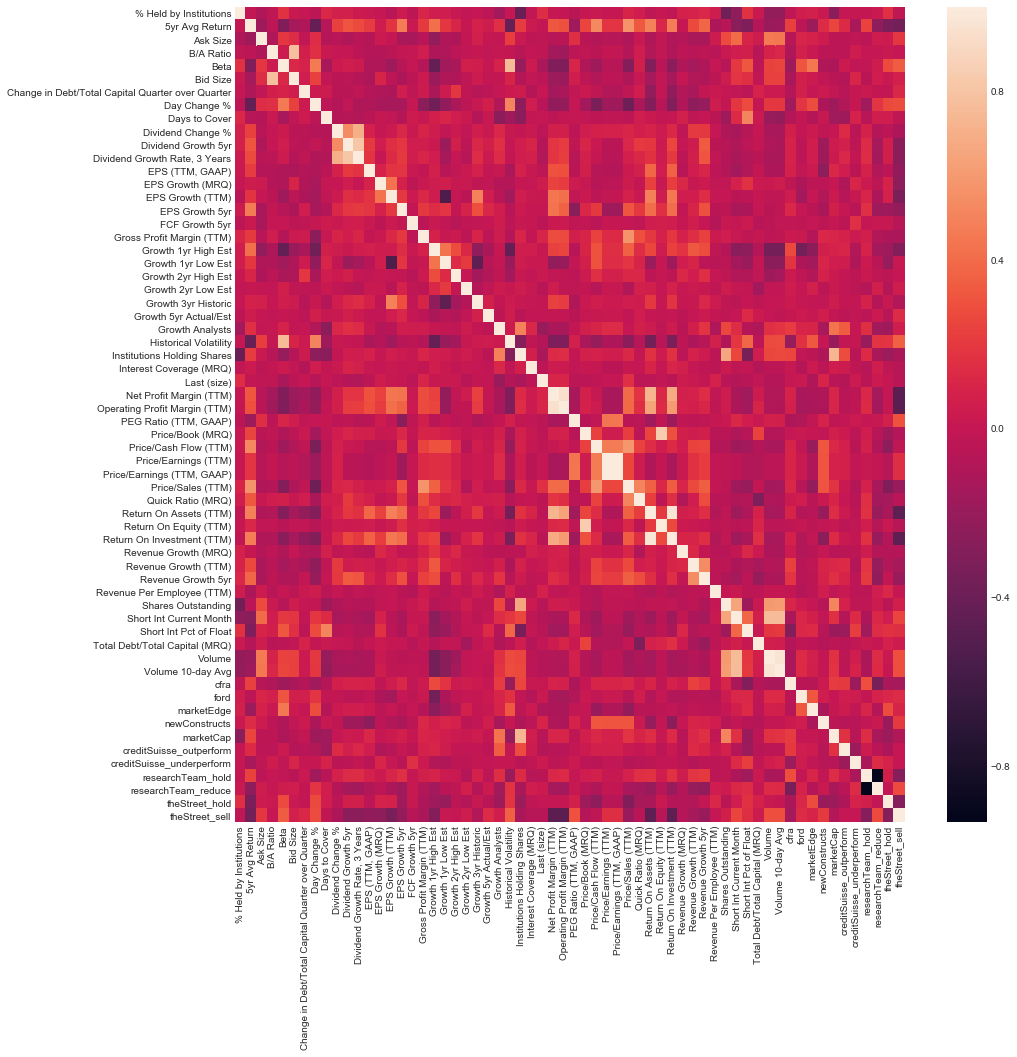

In [182]:
# We can see that Short Int Pct of Float is basically the same as Short Interest, but with 
# more resolution, so I will drop the latter
# The other two variables are probably not particularly helpful, since they are correlated to
# float in that the higher the value of float the higher they may be, and since we already have
# the Short Int Pct of Float, I think this one feature pretty much sums it all up
X_reduced = X_reduced.drop(columns=['Short Int Prev Month',
                                    'Short Interest'
                                   ])
corr = X_reduced.corr()
plt.figure(figsize=(15,15))
sns.heatmap(corr);

In [183]:
# Historical volatility is very similar to beta, since beta is the volatility of the stock
# in comparison to the market. Historical volatility also seems to have a very negative
# correlation to 5yr Avg Return and Growth 1yr High Est, so it will be useful to drop it
# Another pair of highly correlated features is the GAAP and non-GAAP Price/Earnings ratios.
# non-GAAP Price/Earnings is considered to be more useful in analysis because it excludes large
# one-off costs to a company that are not a usual part of their expenses, and may confuse the
# math when considering the performance of a company. In this case, they are almost perfectly
# correlated anyways, so dropping one won't be very harmful in any case. We'll stick with the
# non-GAAP earnings.
# First let's look at the number of missing values these two have
X_reduced[['Price/Earnings (TTM)', 'Price/Earnings (TTM, GAAP)']].info()

<class 'pandas.core.frame.DataFrame'>
Index: 499 entries, A to ZTS
Data columns (total 2 columns):
Price/Earnings (TTM)          447 non-null float64
Price/Earnings (TTM, GAAP)    447 non-null float64
dtypes: float64(2)
memory usage: 31.7+ KB


In [184]:
# Good, they are the same
# Another pair of highly correlated features is the Volume 10-day Avg and the Volume
# Since the 10-day average contains more information, let's keep that one
X_reduced = X_reduced.drop(columns=['Volume',
                                    'Price/Earnings (TTM, GAAP)',
                                    'Historical Volatility'
                                   ])

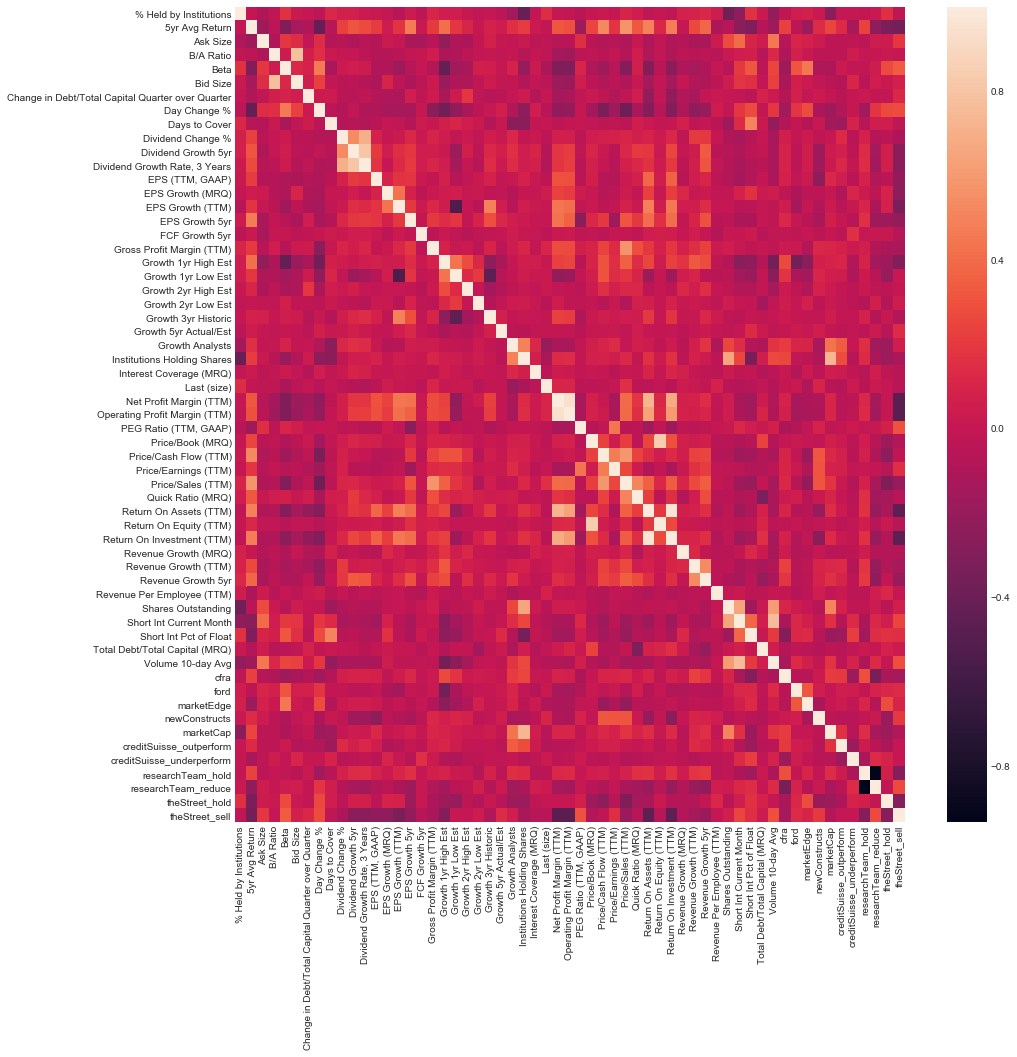

In [185]:
corr = X_reduced.corr()
plt.figure(figsize=(15,15))
sns.heatmap(corr);

Return on Equity and Return on Assets are very similar metrics, so similar that [this article](https://www.experian.com/blogs/insights/2008/12/roe-vs-roa/#:~:text=Return%20on%20Equity%20(ROE)%20is,There%20you%20have%20it.&text=ROE%20tends%20to%20tell%20us,base%20of%20equity%2C%20or%20capital.) explains the difference. It mentions that, since a company must have "assets" in order to calculate ROA, that ROE has become the more popular measure. Let's take a look and see if ROA is missing more values than ROE, which would support this reasoning.

Return on Assets is also highly correlated with Return On Investment (TTM). [This article](https://smallbusiness.chron.com/roa-vs-roi-formulas-36950.html) explains that cross industry comparisons of ROA, like that which we may attempt here, may not be meaningful, and that ROI is a better comparison metric in these scenarios.

In [186]:
X_reduced[['Return On Equity (TTM)',    
           'Return On Investment (TTM)', 
           'Return On Assets (TTM)']].info()

<class 'pandas.core.frame.DataFrame'>
Index: 499 entries, A to ZTS
Data columns (total 3 columns):
Return On Equity (TTM)        451 non-null float64
Return On Investment (TTM)    435 non-null float64
Return On Assets (TTM)        477 non-null float64
dtypes: float64(3)
memory usage: 35.6+ KB


In [187]:
# Oddly enough, the ROA column has more values than ROE, which isn't what I expected after
# reading that first article. Although ROA has the least missing values, it is likely the best
# candidate to drop, as the second article above informs us that it is not necessaril useful
# in cross-industry comparisons. The companies in the S&P 500 spread over different industries.
# Net profit margin is the same as Operating Profit Margin minus taxes and interest, so it is
# likely that we should stick with Net Profit Margin, let's check for missing values
X_reduced[['Net Profit Margin (TTM)', 'Operating Profit Margin (TTM)']].info()

<class 'pandas.core.frame.DataFrame'>
Index: 499 entries, A to ZTS
Data columns (total 2 columns):
Net Profit Margin (TTM)          487 non-null float64
Operating Profit Margin (TTM)    487 non-null float64
dtypes: float64(2)
memory usage: 31.7+ KB


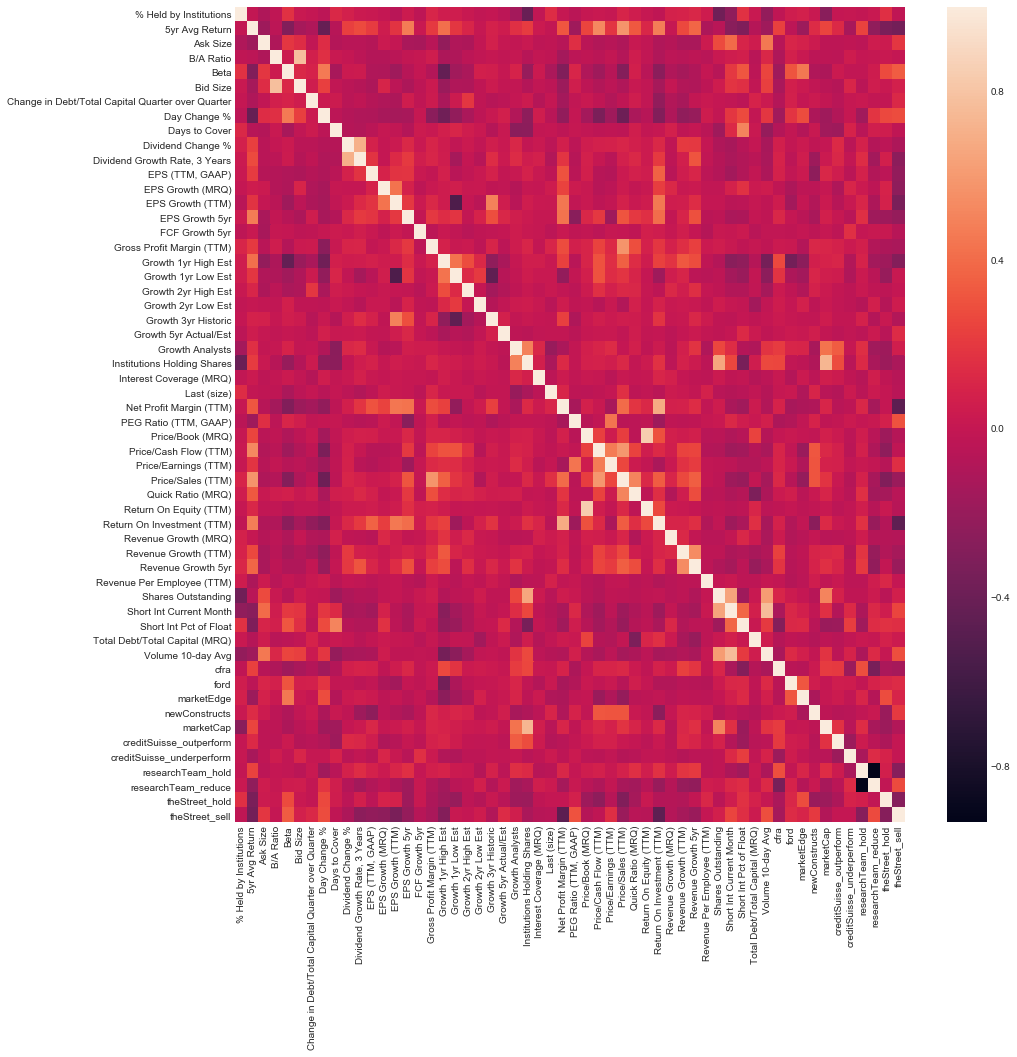

In [188]:
# They're the same, we'll drop the Operating Profit Margin which contains less information
# Another correlated set of features is the 5yr and 3yr Dividend Growth. Since the 5yr feature
# is missing more values, and since the 5yr Dividend growth was found toward the bottom of
# the permutation importances earlier, let's drop the 5yr feature
X_reduced = X_reduced.drop(columns=['Return On Assets (TTM)',
                                    'Operating Profit Margin (TTM)',
                                    'Dividend Growth 5yr'
                                   ])
corr = X_reduced.corr()
plt.figure(figsize=(15,15))
sns.heatmap(corr);

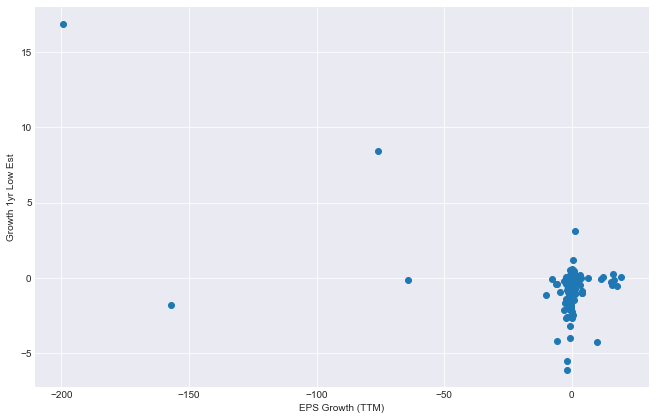

In [189]:
# We can see a strong negative correlation between EPS Growth (TTM) and Growth 1yr Low Est
# Let's plot them together to take a look
plt.scatter(X_reduced['EPS Growth (TTM)'], X_reduced['Growth 1yr Low Est'])
plt.xlabel('EPS Growth (TTM)')
plt.ylabel('Growth 1yr Low Est');

In [190]:
# It looks like this correlation is being found because of some pretty extreme outliers, so
# I will just leave it in place. Another strong negative correlation exists in the researchTeam
# dummy variables, which is to be expected. I will leave it alone from here, this is a
# pretty clean set of features at this point. Time for some modeling.
# First, let's look at the dataframe info, to see how our missing values have been affected
# after our feature selection
X_reduced.info()

<class 'pandas.core.frame.DataFrame'>
Index: 499 entries, A to ZTS
Data columns (total 56 columns):
% Held by Institutions                               493 non-null float64
5yr Avg Return                                       499 non-null float64
Ask Size                                             490 non-null float64
B/A Ratio                                            490 non-null float64
Beta                                                 486 non-null float64
Bid Size                                             490 non-null float64
Change in Debt/Total Capital Quarter over Quarter    471 non-null float64
Day Change %                                         499 non-null float64
Days to Cover                                        493 non-null float64
Dividend Change %                                    403 non-null float64
Dividend Growth Rate, 3 Years                        392 non-null float64
EPS (TTM, GAAP)                                      488 non-null float64
EPS Growth (

In [191]:
# This looks pretty good. Let's try to compare some imputation methods with different regressors
# to see how the performance differs from above when we had not dealt with collinearity.

<a id='regression2'></a>
## Regression (2)
We will now perform regression using the reduced feature set as predictors.

### Imputing Missing Data (Regression 2)

#### RandomForestRegressor

In [192]:
# The RandomForestRegressor had the best performance before, so let's cut straight to the chase
regressor = RandomForestRegressor(random_state=0)

In [195]:
y = targets.log_return

In [196]:
estimators = [
    BayesianRidge(),
    DecisionTreeRegressor(max_features='sqrt', random_state=123),
    ExtraTreesRegressor(n_estimators=10, max_features='sqrt', random_state=123),
    KNeighborsRegressor(n_neighbors=15)
]

Imputing with IterativeImputer using BayesianRidge estimator
Imputing with IterativeImputer using DecisionTreeRegressor estimator


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


Imputing with IterativeImputer using ExtraTreesRegressor estimator


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


Imputing with IterativeImputer using KNeighborsRegressor estimator


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


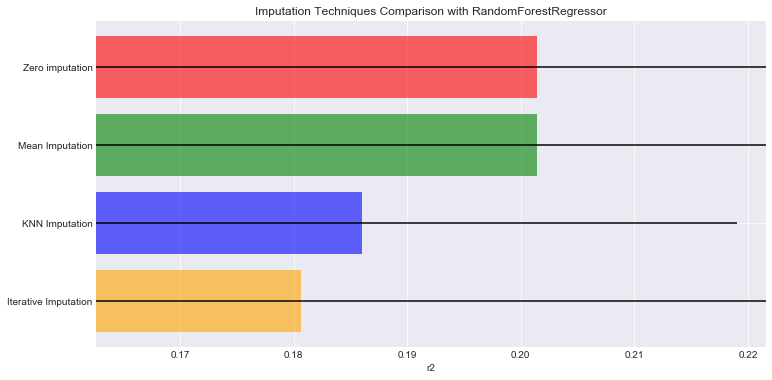

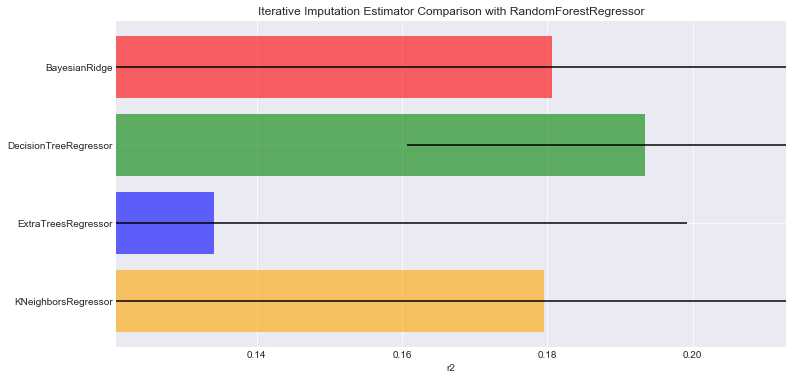

In [197]:
ax1, ax2 = compare_imputer_scores(X_reduced, y, regressor, 'r2', estimators)

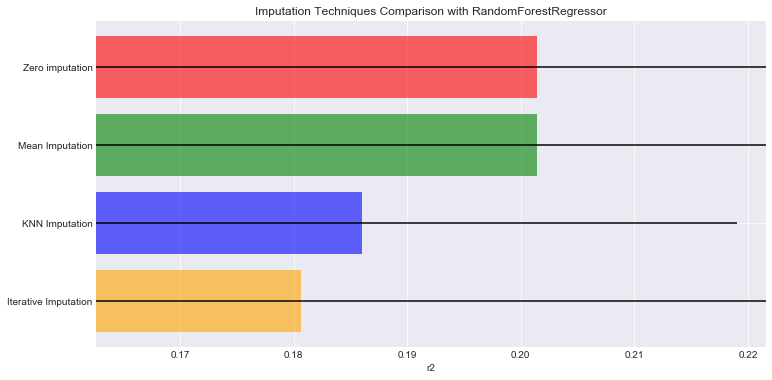

In [198]:
ax1.figure

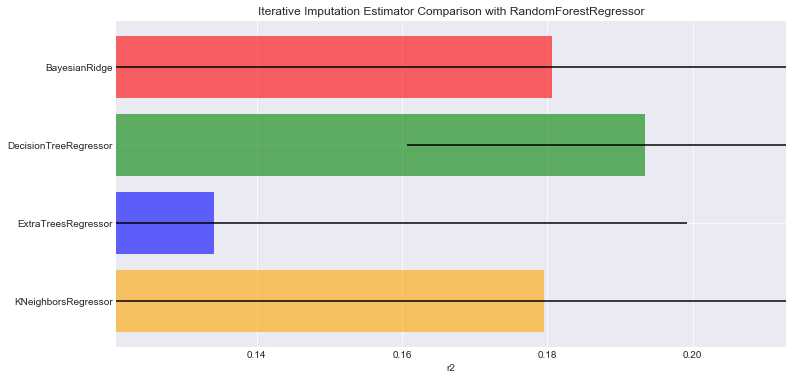

In [199]:
ax2.figure

In [108]:
# These scores are slightly worse than before multicollinearity was managed, and the variances
# have become wider.

#### XGBRegressor

In [202]:
from xgboost import XGBRegressor
regressor = XGBRegressor(random_state=0)

In [203]:
estimators = [
    BayesianRidge(),
    DecisionTreeRegressor(max_features='sqrt', random_state=123),
    ExtraTreesRegressor(n_estimators=10, max_features='sqrt', random_state=123),
    KNeighborsRegressor(n_neighbors=15)
]

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[12:01:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:01:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[12:01:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:01:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[12:01:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:01:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[12:01:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:01:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[12:01:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:01:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[12:01:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[12:01:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[12:01:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[12:01:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[12:01:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[12:01:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[12:01:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[12:01:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[12:01:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[12:01:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Imputing with IterativeImputer using BayesianRidge estimator


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[12:01:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[12:01:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[12:01:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[12:01:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[12:01:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Imputing with IterativeImputer using DecisionTreeRegressor estimator


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[12:01:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[12:01:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[12:01:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[12:01:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[12:01:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Imputing with IterativeImputer using ExtraTreesRegressor estimator


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[12:01:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[12:01:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[12:01:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[12:02:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[12:02:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Imputing with IterativeImputer using KNeighborsRegressor estimator


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[12:02:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[12:02:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[12:02:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[12:02:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[12:02:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


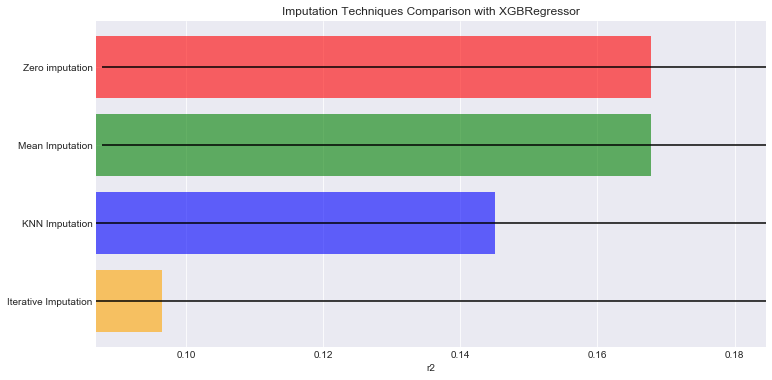

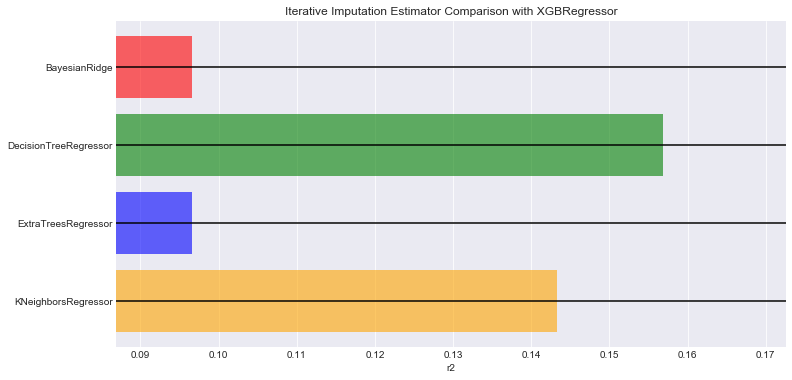

In [204]:
ax1, ax2 = compare_imputer_scores(X_reduced, y, regressor, 'r2', estimators)

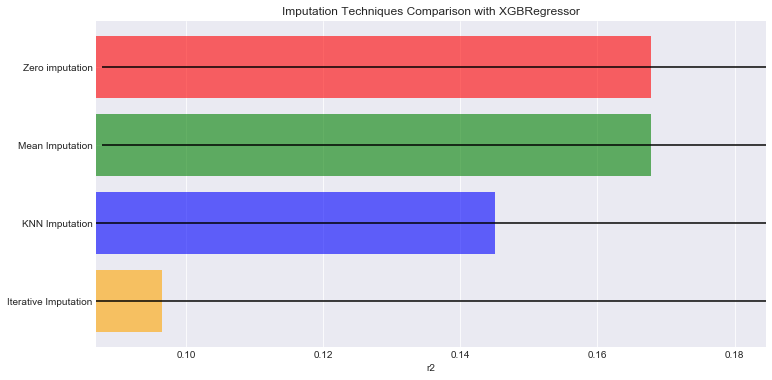

In [205]:
ax1.figure

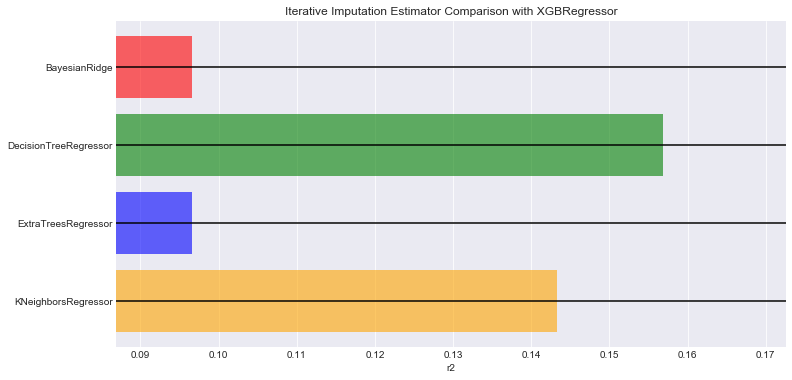

In [206]:
ax2.figure

In [ ]:
# Again, more lackluster scores that are all over the place

In [207]:
# XGBRegressor has its own imputation method built in, let's try it out
scores = cross_val_score(regressor, X_reduced, y, scoring='r2', n_jobs=-1)
print('cross validation scores')
print('mean:', scores.mean())
print('std:', scores.std())

cross validation scores
mean: 0.16277971792358287
std: 0.07188030643588306


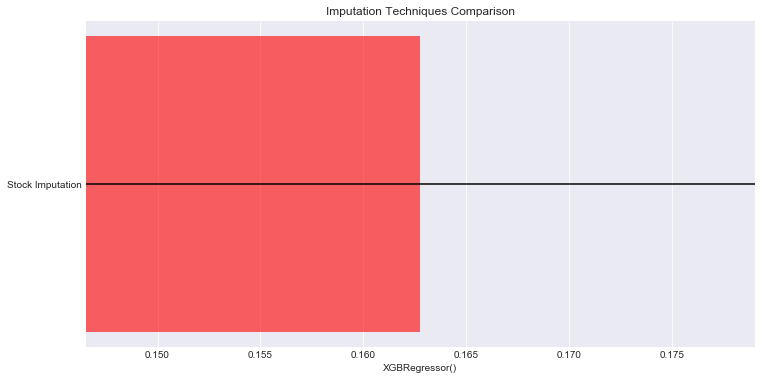

In [208]:
graph_imputer_scores([scores.mean()], [scores.std()], ['Stock Imputation'], regressor)

In [209]:
# This worked better than the other methods, but the r2 is still low and the variance is still
# wide.

#### XGBRFRegressor

In [210]:
from xgboost import XGBRFRegressor
regressor = XGBRFRegressor(random_state=0)

In [124]:
estimators = [
    BayesianRidge(),
    DecisionTreeRegressor(max_features='sqrt', random_state=123),
    ExtraTreesRegressor(n_estimators=10, max_features='sqrt', random_state=123),
    KNeighborsRegressor(n_neighbors=15)
]

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[12:05:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:05:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[12:05:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:05:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[12:05:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:05:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[12:05:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:05:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[12:05:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:05:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[12:05:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[12:05:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[12:05:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:05:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[12:05:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[12:05:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[12:05:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[12:05:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[12:05:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[12:05:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Imputing with IterativeImputer using BayesianRidge estimator


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[12:05:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[12:05:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[12:05:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[12:05:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[12:05:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Imputing with IterativeImputer using DecisionTreeRegressor estimator


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[12:05:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[12:05:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[12:05:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[12:05:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[12:05:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Imputing with IterativeImputer using ExtraTreesRegressor estimator


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[12:05:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[12:06:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[12:06:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[12:06:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[12:06:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Imputing with IterativeImputer using KNeighborsRegressor estimator


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[12:06:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[12:06:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[12:06:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[12:06:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[12:06:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


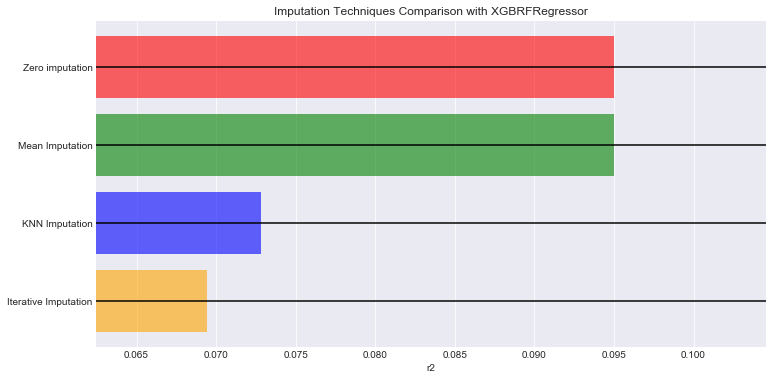

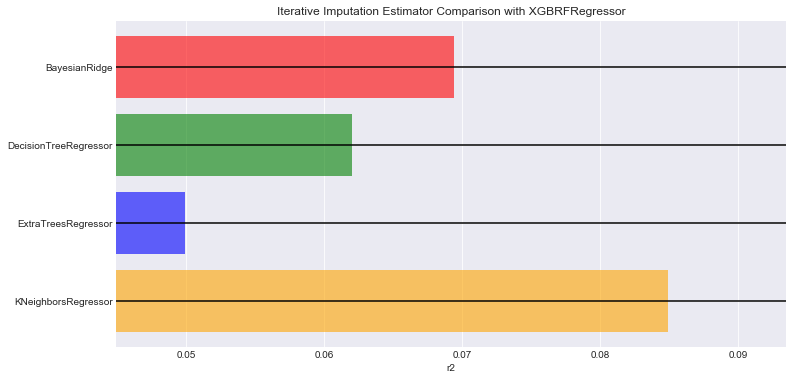

In [211]:
ax1, ax2 = compare_imputer_scores(X_reduced, y, regressor, 'r2', estimators)

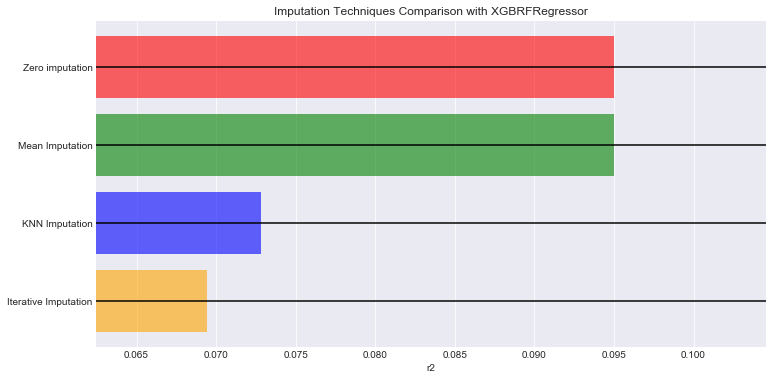

In [212]:
ax1.figure

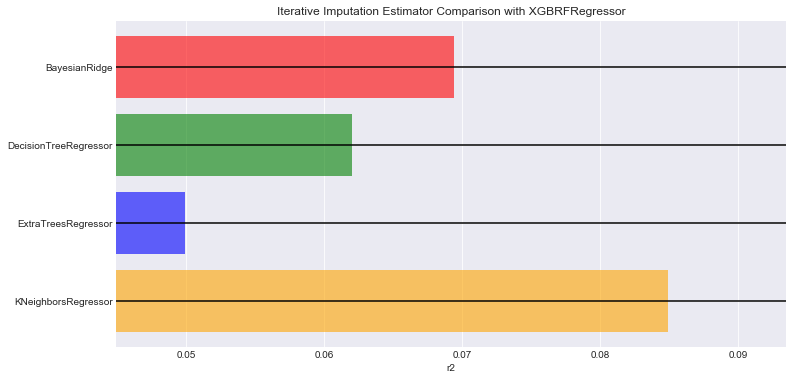

In [213]:
ax2.figure

In [128]:
# Nothing happening here either

In [214]:
# XGBRFRegressor has its own imputation method built in, let's try it out
scores = cross_val_score(regressor, X_reduced, y, scoring='r2', n_jobs=-1)
print('cross validation scores')
print('mean:', scores.mean())
print('std:', scores.std())

cross validation scores
mean: 0.09320854131544414
std: 0.04371566752881143


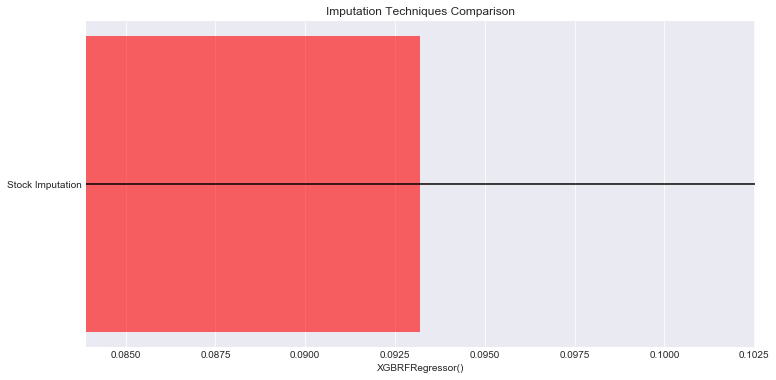

In [215]:
graph_imputer_scores([scores.mean()], [scores.std()], ['Stock Imputation'], regressor)

In [ ]:
# This regressor is not working as well as others we have explored so far.
# I am just going to skip the modeling step for regression after multicollinearity management,
# since our results have not improved.

<a id='classification2'></a>
## Classification (2)
In this section I will be classifying the two binary categorical target variables using the reduced feature set with removed multicollinearity for training.

### Class 1: Gainers and Losers

### Imputing Data

#### RandomForestClassifier

In [235]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()
y = targets.class1

In [226]:
estimators = [
    BayesianRidge(),
    DecisionTreeRegressor(max_features='sqrt', random_state=123),
    ExtraTreesRegressor(n_estimators=10, max_features='sqrt', random_state=123),
    KNeighborsRegressor(n_neighbors=15)
]

Imputing with IterativeImputer using BayesianRidge estimator
Imputing with IterativeImputer using DecisionTreeRegressor estimator


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


Imputing with IterativeImputer using ExtraTreesRegressor estimator


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


Imputing with IterativeImputer using KNeighborsRegressor estimator


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


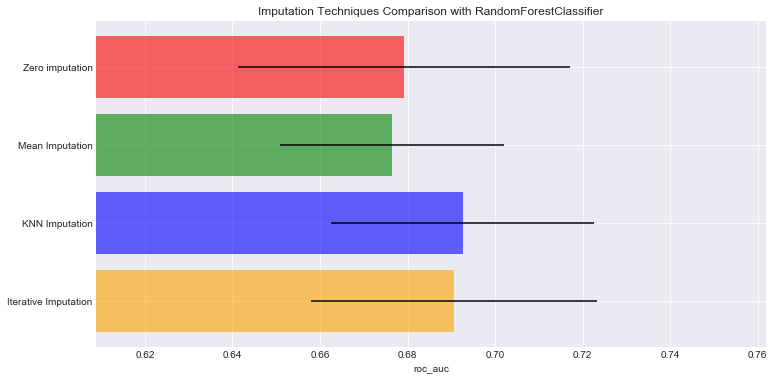

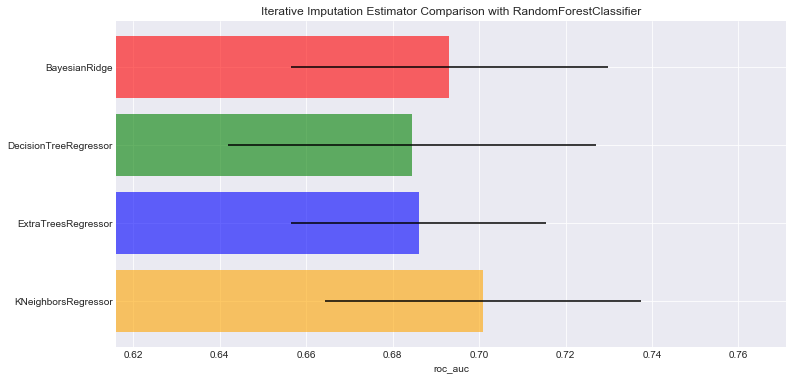

In [236]:
ax1, ax2 = compare_imputer_scores(X_reduced, y, clf, 'roc_auc', estimators)

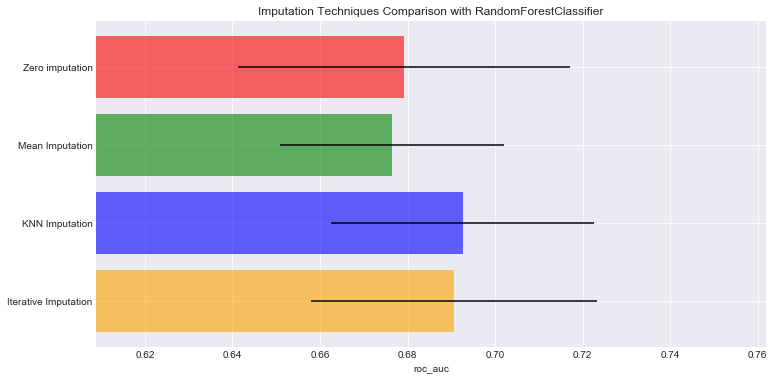

In [237]:
ax1.figure

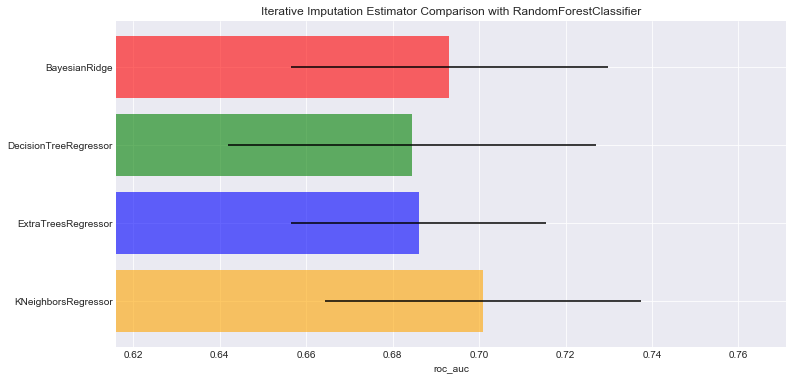

In [238]:
ax2.figure

#### GradientBoostingClassifier

In [240]:
clf = GradientBoostingClassifier(random_state=0)
y = targets.class1

In [241]:
estimators = [
    BayesianRidge(),
    DecisionTreeRegressor(max_features='sqrt', random_state=123),
    ExtraTreesRegressor(n_estimators=10, max_features='sqrt', random_state=123),
    KNeighborsRegressor(n_neighbors=15)
]

Imputing with IterativeImputer using BayesianRidge estimator
Imputing with IterativeImputer using DecisionTreeRegressor estimator


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


Imputing with IterativeImputer using ExtraTreesRegressor estimator


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


Imputing with IterativeImputer using KNeighborsRegressor estimator


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


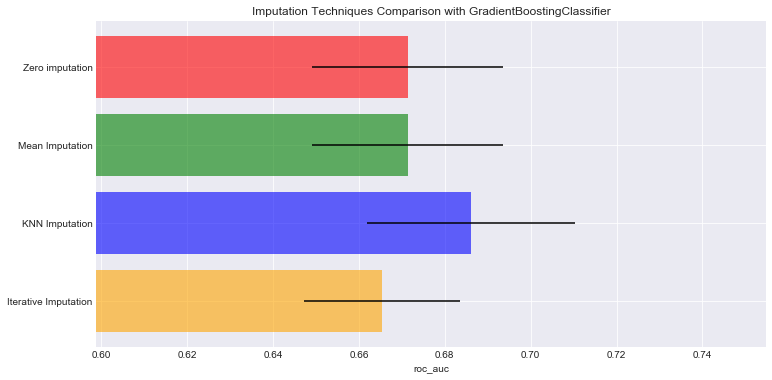

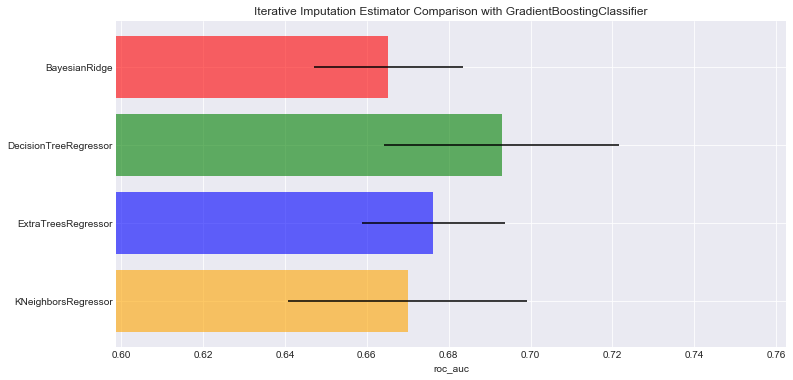

In [242]:
ax1, ax2 = compare_imputer_scores(X_reduced, y, clf, 'roc_auc', estimators)

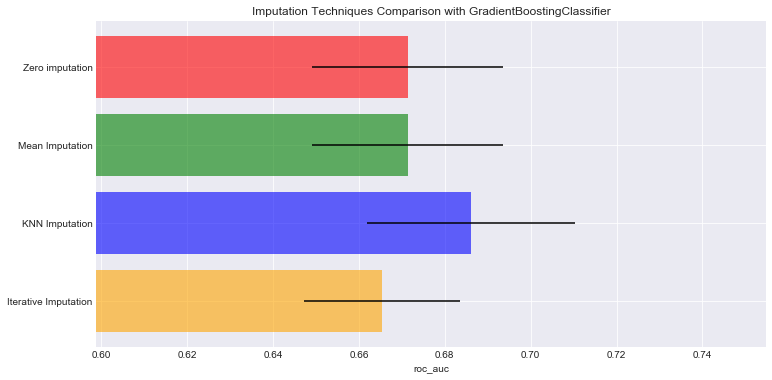

In [243]:
ax1.figure

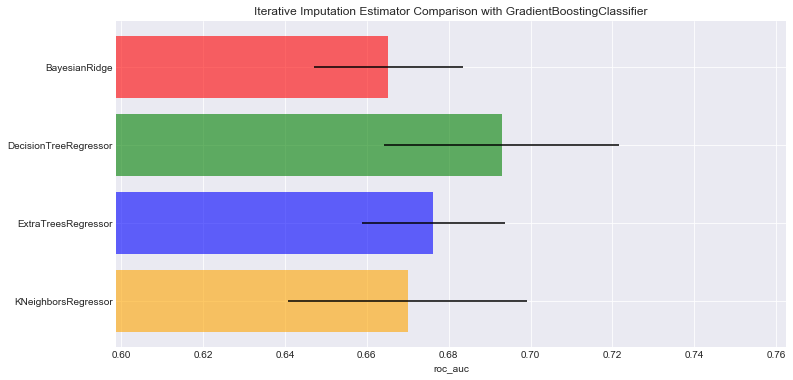

In [244]:
ax2.figure

#### XGBClassifier

In [223]:
# The best performance earlier was achieved using XGBClassifier, let's compare the results now
from xgboost import XGBClassifier

In [295]:
clf = XGBClassifier()

In [296]:
# Setting target to 
y = targets.class1

In [297]:
estimators = [
    BayesianRidge(),
    DecisionTreeRegressor(max_features='sqrt', random_state=123),
    ExtraTreesRegressor(n_estimators=10, max_features='sqrt', random_state=123),
    KNeighborsRegressor(n_neighbors=15)
]

In [298]:
ax1, ax2 = compare_imputer_scores(X_reduced, y, clf, 'roc_auc', estimators)

KeyboardInterrupt: 

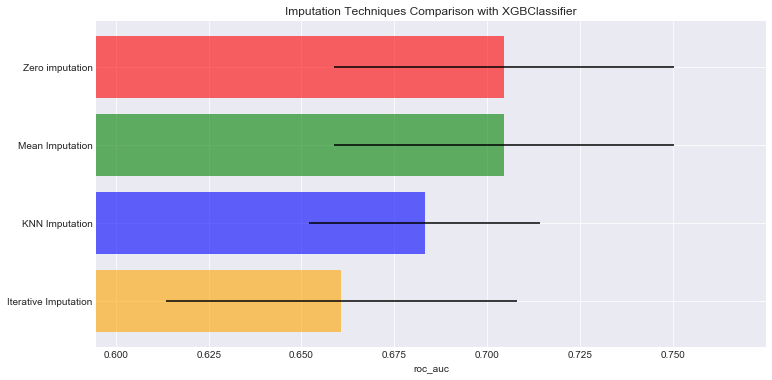

In [229]:
ax1.figure

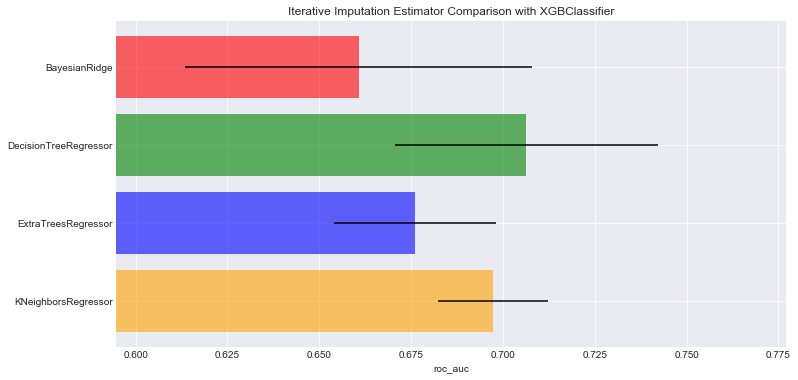

In [230]:
ax2.figure

In [111]:
# These are actually better than the scores we got with the entire feature set, which means
# we have done a good job not sacrificing performance, and we should get much more meaningful
# feature importances

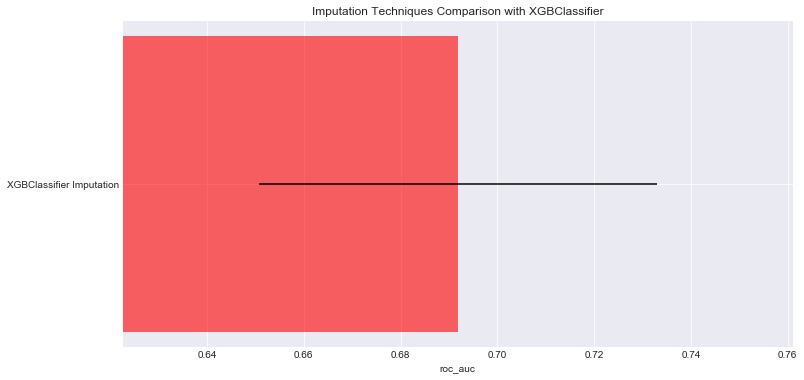

In [301]:
# Let's see how well the classifier does with its own built-in imputation method
estimator = make_pipeline(StandardScaler(), XGBClassifier(random_state=0))
scores = cross_val_score(estimator, X_reduced, y, scoring='roc_auc', cv=5)
graph_imputer_scores([scores.mean()], [scores.std()], ['XGBClassifier Imputation'], 'roc_auc', XGBClassifier())

#### XGBRFClassifier

In [122]:
from xgboost import XGBRFClassifier

In [246]:
clf = XGBRFClassifier()
y = targets.class1

In [247]:
estimators = [
    BayesianRidge(),
    DecisionTreeRegressor(max_features='sqrt', random_state=123),
    ExtraTreesRegressor(n_estimators=10, max_features='sqrt', random_state=123),
    KNeighborsRegressor(n_neighbors=15, weights='distance')
]

Imputing with IterativeImputer using BayesianRidge estimator
Imputing with IterativeImputer using DecisionTreeRegressor estimator


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


Imputing with IterativeImputer using ExtraTreesRegressor estimator


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


Imputing with IterativeImputer using KNeighborsRegressor estimator


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


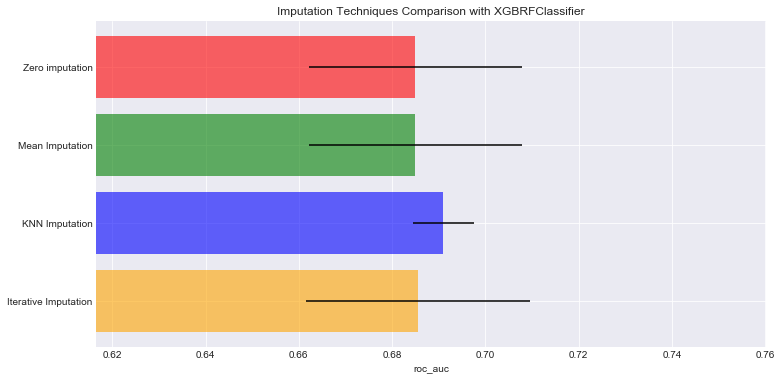

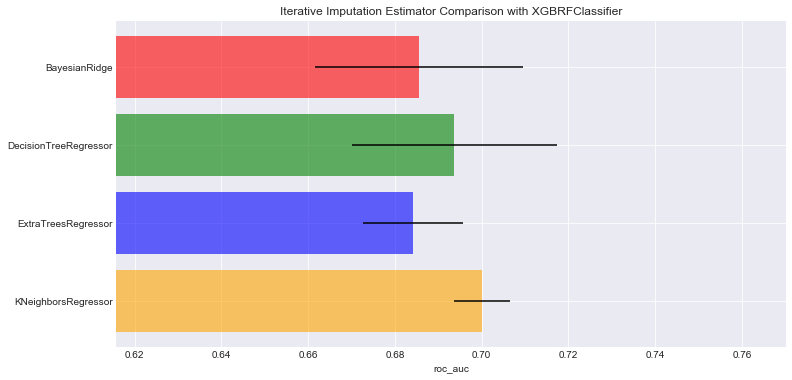

In [248]:
ax1, ax2 = compare_imputer_scores(X_reduced, y, clf, 'roc_auc', estimators)

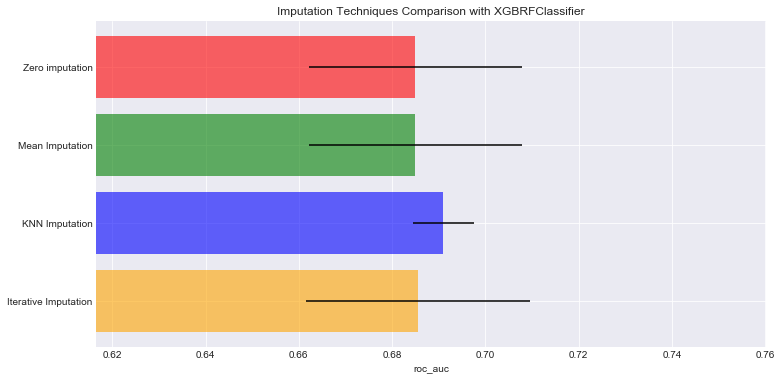

In [249]:
ax1.figure

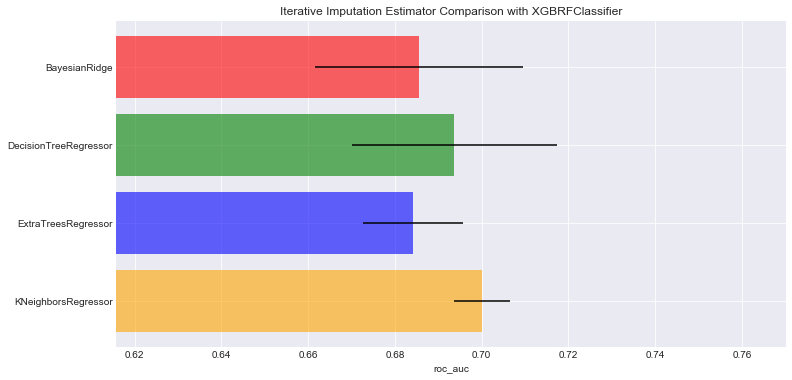

In [250]:
ax2.figure

In [ ]:
# We are getting some good results here from the IterativeImputer using KNeighborsRegressor,
# which has a very tight variance across the cross validation folds, meaning the models are
# robust. Let's tune the parameters a bit

In [251]:
estimators = [
    BayesianRidge(),
    DecisionTreeRegressor(max_features='auto', random_state=123),
    ExtraTreesRegressor(n_estimators=10, max_features='auto', random_state=123),
    KNeighborsRegressor(n_neighbors=30, weights='distance')
]

Imputing with IterativeImputer using BayesianRidge estimator
Imputing with IterativeImputer using DecisionTreeRegressor estimator


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


Imputing with IterativeImputer using ExtraTreesRegressor estimator


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


Imputing with IterativeImputer using KNeighborsRegressor estimator


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


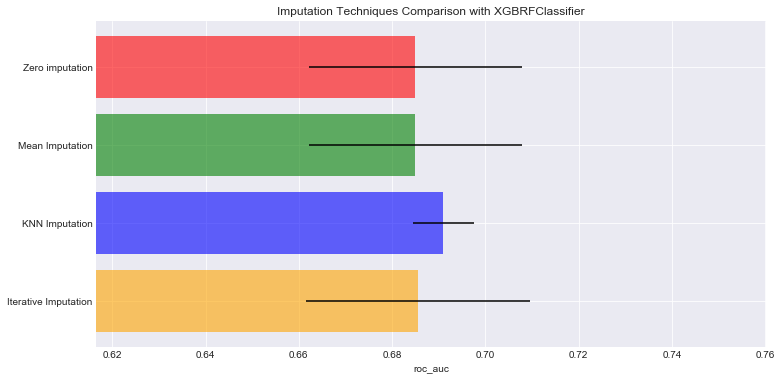

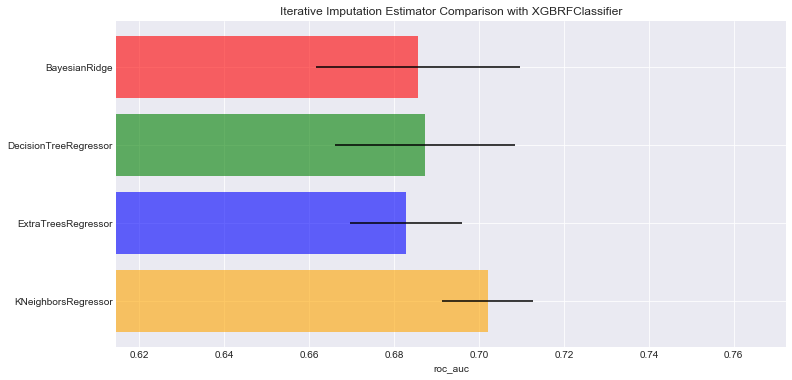

In [252]:
ax1, ax2 = compare_imputer_scores(X_reduced, y, clf, 'roc_auc', estimators)

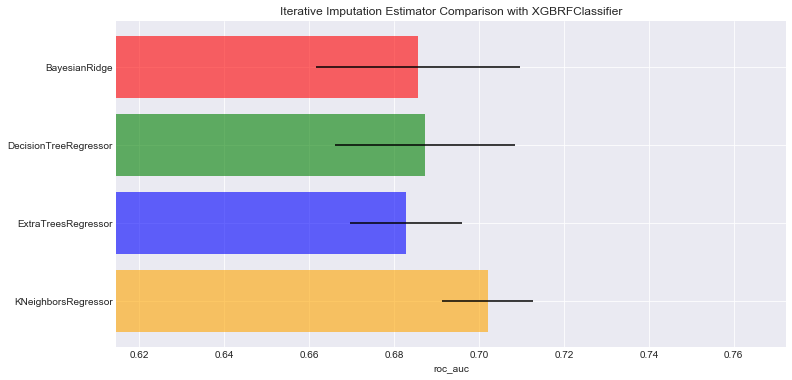

In [254]:
ax2.figure

In [ ]:
# Looks like we got a little more performance out of KNeighborsRegressor by increasing the 
# n_neighbors to 30, but the DecisionTree and ExtraTrees suffered as a result of changing
# the max_features parameter to auto. The variance of the KNeighborsRegressor did increase,
# meaning that the scores are not as stable as they were before the change.

In [ ]:
# I want to see if reducing the max_iter parameter affects performance of this estimator,
# because if it does not we can greatly improve efficiency of a grid search

Imputing with IterativeImputer using BayesianRidge estimator
Imputing with IterativeImputer using DecisionTreeRegressor estimator


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


Imputing with IterativeImputer using ExtraTreesRegressor estimator


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


Imputing with IterativeImputer using KNeighborsRegressor estimator


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


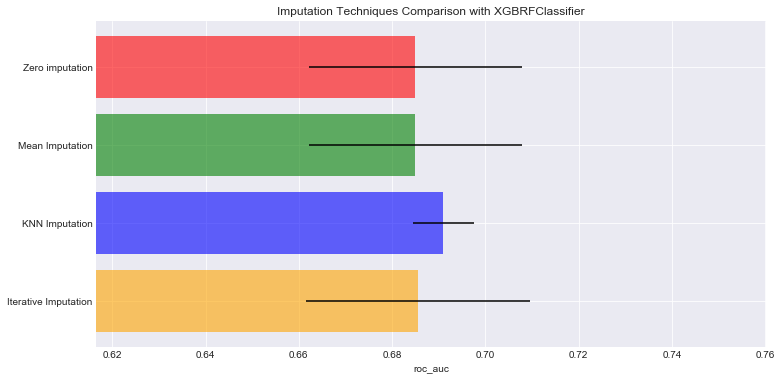

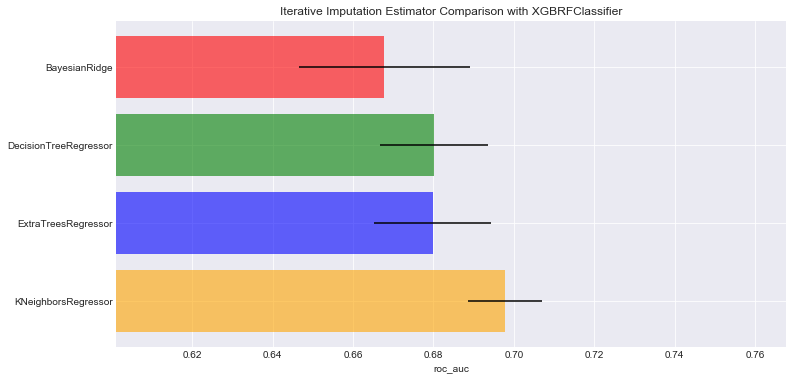

In [256]:
ax1, ax2 = compare_imputer_scores(X_reduced, y, clf, 'roc_auc', estimators, max_iter=1)

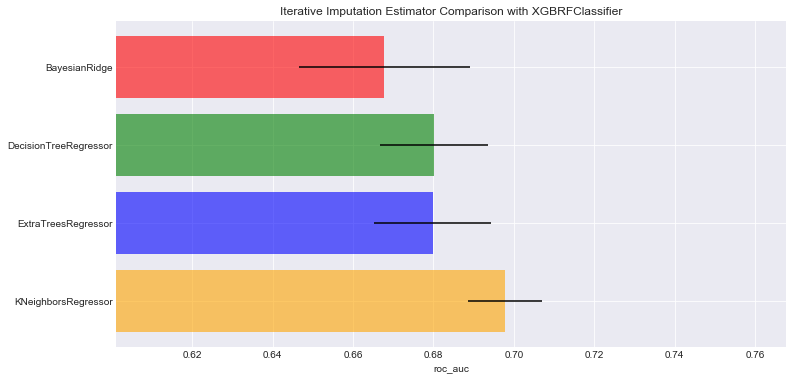

In [257]:
ax2.figure

In [ ]:
# This has had some detrimental effect on the performance. May a slightly higher number would
# be better

In [258]:
estimators = [
    BayesianRidge(),
    DecisionTreeRegressor(max_features='sqrt', random_state=123),
    ExtraTreesRegressor(n_estimators=10, max_features='sqrt', random_state=123),
    KNeighborsRegressor(n_neighbors=15, weights='distance')
]

Imputing with IterativeImputer using BayesianRidge estimator
Imputing with IterativeImputer using DecisionTreeRegressor estimator


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


Imputing with IterativeImputer using ExtraTreesRegressor estimator


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


Imputing with IterativeImputer using KNeighborsRegressor estimator


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


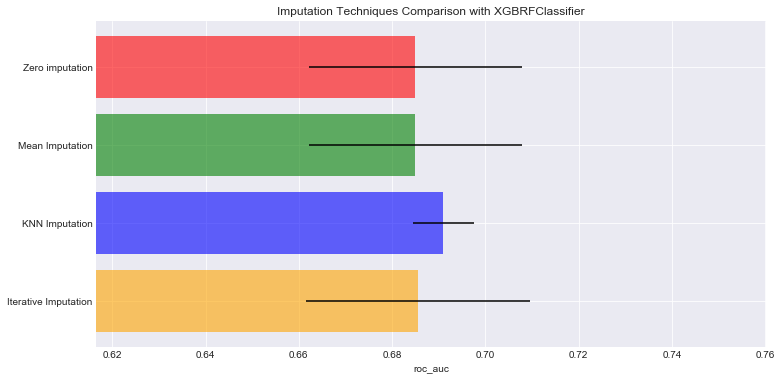

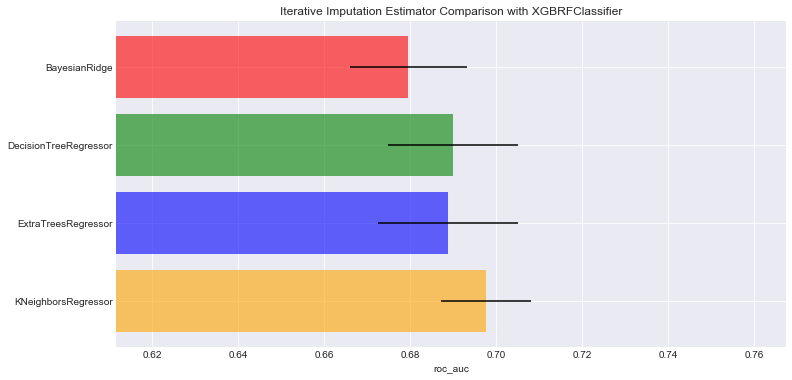

In [259]:
ax1, ax2 = compare_imputer_scores(X_reduced, y, clf, 'roc_auc', estimators, max_iter=2)

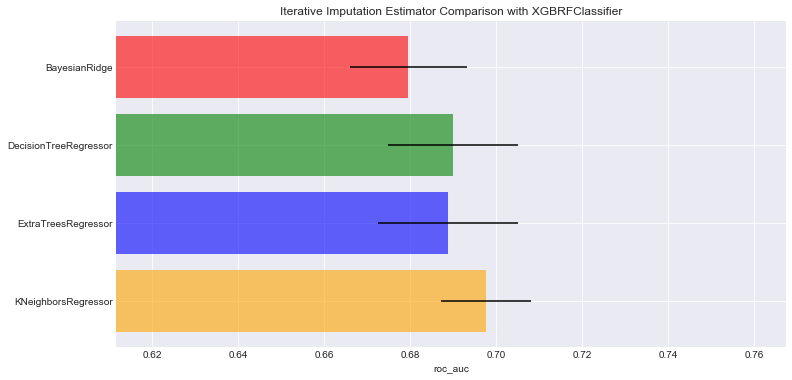

In [260]:
ax2.figure

Imputing with IterativeImputer using BayesianRidge estimator
Imputing with IterativeImputer using DecisionTreeRegressor estimator


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


Imputing with IterativeImputer using ExtraTreesRegressor estimator


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


Imputing with IterativeImputer using KNeighborsRegressor estimator


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


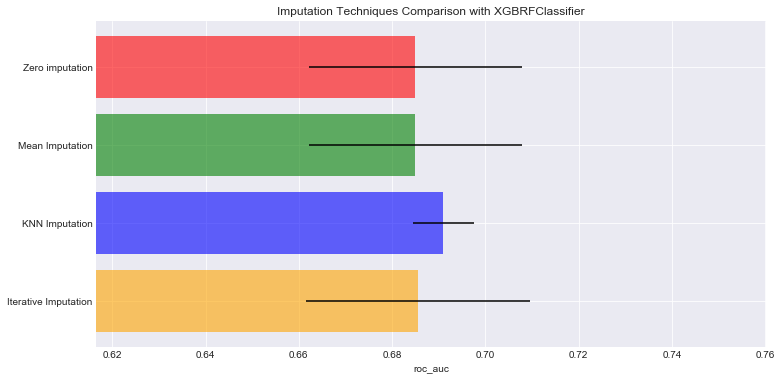

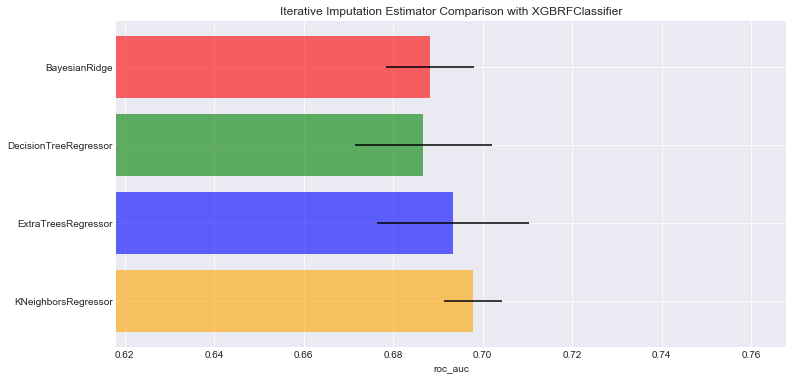

In [261]:
ax1, ax2 = compare_imputer_scores(X_reduced, y, clf, 'roc_auc', estimators, max_iter=3)

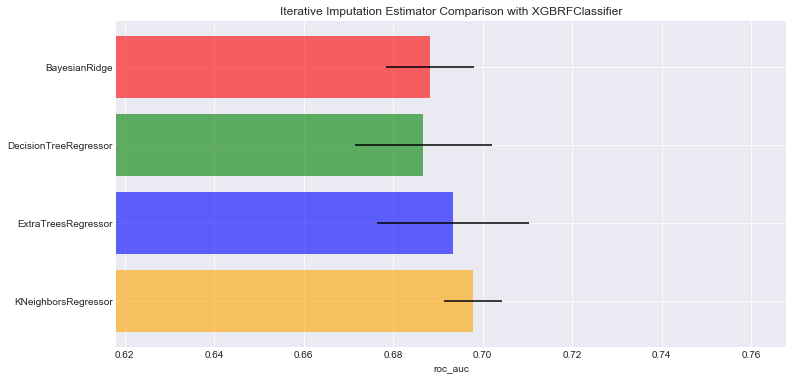

In [262]:
ax2.figure

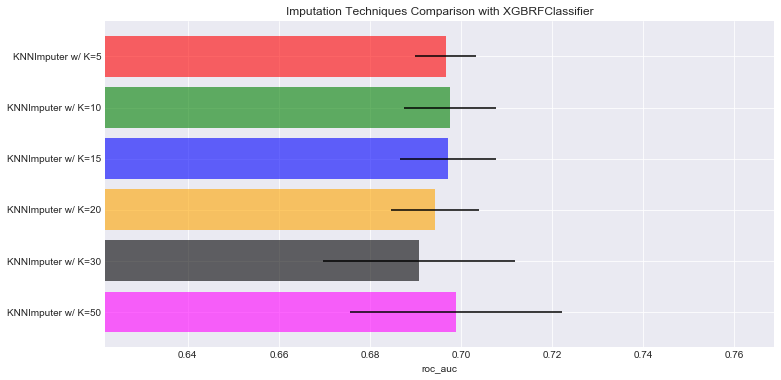

In [266]:
# Since the IterativeImputer can cost a lot of time, it may be helpful to do some parameter
# tuning on the KNNImputer to see if it can get up to a similar level of performance
scores = []
stds = []
labels = []

for k in [5, 10, 15, 20, 30, 50]:
    scaler = StandardScaler()
    imputer = KNNImputer(n_neighbors=k, weights='distance')
    regressor = XGBRFClassifier(n_jobs=-1, random_state=0)
    estimator = make_pipeline(scaler, imputer, estimator)
    
    cv_scores = cross_val_score(estimator, X_reduced, y, scoring='roc_auc', cv=5)
    scores.append(cv_scores.mean())
    stds.append(cv_scores.std())
    labels.append('KNNImputer w/ K={}'.format(k))
    
graph_imputer_scores(scores, stds, labels, 'roc_auc', regressor=XGBRFClassifier())

In [ ]:
# These computations take much less time, and aren't terribly worse than the scores that the
# IterativeImputer with the KNeighborsRegressor estimator. It is most likely that we can do
# a grid search using the KNNImputer to find the best hyperparameters for the Classifier, then
# create a pipeline using a classifier with these parameters and switch out the imputer with
# the iterative one to get a slightly boosted performance. I will take this approach.
# The KNNImputer has strong and consistent performance using the standard value of K = 5

### Modeling - Class 1: Gainers/Losers

#### XGBRFClassifier

In [267]:
y = targets.class1

#imputer_estimator = KNeighborsRegressor(n_neighbors=15, weights='distance', n_jobs=-1)

scaler = StandardScaler()

#imputer = IterativeImputer(estimator=imputer_estimator,
#                           max_iter=10,
#                           add_indicator=False
#                          )

imputer = KNNImputer(weights='distance', add_indicator=False)

clf = XGBRFClassifier(n_jobs=-1, random_state=0)

steps = [('scaler', scaler),
         ('imputer', imputer),
         ('clf', clf)
        ]
estimator = Pipeline(steps=steps)

param_grid = {#'imputer__n_nearest_features': [5, 15, None],
              'clf__max_depth': [3, 5, 7],
              'clf__learning_rate': [.001, .01, .1],
              'clf__n_estimators': [100, 300, 500],
              'clf__subsample': [0.8, 1.0],
              'clf__colsample_bytree': [0.6, 0.8, 1.0],
              #'clf__colsample_bylevel': [0.6, 0.8, 1.0],
              'clf__colsample_bynode': [0.6, 0.8, 1.0],
              'clf__reg_alpha': [0, 0.5, 1],
              'clf__reg_lambda': [.25, .5, .75, 1]
             }

grid_search = GridSearchCV(estimator=estimator, 
                           param_grid=param_grid,
                           scoring='roc_auc',
                           n_jobs=-1,
                           cv=5,
                           verbose=2
                          )
grid_fit_new = grid_search.fit(X_reduced, y)

Fitting 5 folds for each of 5832 candidates, totalling 29160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   59.0s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed:  9.8min
[Parallel(n_jobs=-1)]: Done 3265 tasks      | elapsed: 13.4min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed: 16.1min
[Parallel(n_jobs=-1)]: Done 4885 tasks      | elapsed: 19.4min
[Parallel(n_jobs=-1)]: Done 5816 tasks      | elapsed: 23.3min
[Parallel(n_jobs=-1)]: Done 6829 tasks      | elapsed: 27.5min
[Parallel(n_jobs=-1)]: Done 7922 tasks      | elapsed: 32.2min
[Parallel(n_jobs=-1)]: Done 9097 tasks      | e

In [268]:
# Let's see what the best score was
grid_fit_new.best_score_

0.7160282428547269

In [269]:
# This is our highest score yet
# Let's look at the parameters
grid_fit_new.best_params_

{'clf__colsample_bynode': 0.8,
 'clf__colsample_bytree': 0.6,
 'clf__learning_rate': 0.001,
 'clf__max_depth': 5,
 'clf__n_estimators': 100,
 'clf__reg_alpha': 0,
 'clf__reg_lambda': 0.5,
 'clf__subsample': 0.8}

In [324]:
# Looks like these are actually the out-of-box parameters
# Let's calculate the probabilities, and see if they have any relationship with the returns
probas = grid_fit_new.best_estimator_.predict_proba(X_reduced)
probas[:5]

array([[0.49970388, 0.5002961 ],
       [0.49973273, 0.50026727],
       [0.49963188, 0.5003681 ],
       [0.4996748 , 0.5003252 ],
       [0.49998868, 0.5000113 ]], dtype=float32)

In [325]:
import my_functions as mf

In [326]:
%load_ext autoreload
%autoreload 1
%aimport my_functions

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


             0         1
A     0.500296  0.250673
AAL   0.500267  0.095848
AAP   0.500368  0.161577
AAPL  0.500325  0.398815
ABBV  0.500011 -0.014316
Linear Regression for log_return~probs


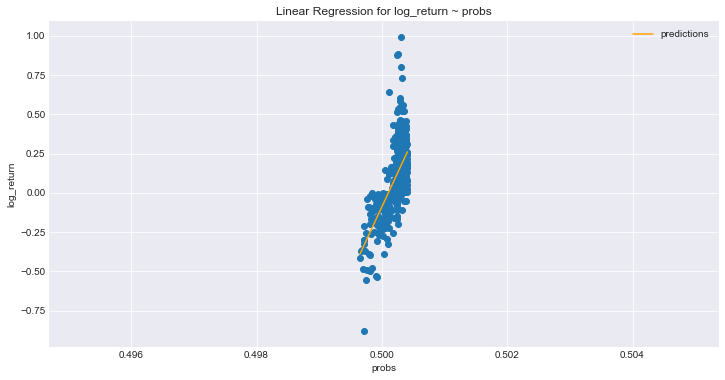

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             log_return   R-squared:                       0.465
Model:                            OLS   Adj. R-squared:                  0.464
Method:                 Least Squares   F-statistic:                     431.5
Date:                Mon, 16 Nov 2020   Prob (F-statistic):           1.86e-69
Time:                        21:41:35   Log-Likelihood:                 212.90
No. Observations:                 499   AIC:                            -421.8
Df Residuals:                     497   BIC:                            -413.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -430.3704     20.723    -20.768      0.000    -471.086    -389.655
probs        860.5614     41.427     20.773      0.000     779.167     941.956
==============================================================================
Omnibus:                      118.809   Durbin-Watson:                   1.899
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              414.136
Skew:                           1.065   Prob(JB):                     1.18e-90
Kurtosis:                       6.922   Cond. No.                     7.31e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.31e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Test for homoscedasticity of residuals:


F_statistic      p_value
Goldfeld-Quandt     1.58543  0.000624477

Normality Test Results for ['residuals']:
-------------------------------------------------------------------------------------------


K-S and Shapiro-Wilk: 
 
 
 
 
 K-S 
 Shapiro-Wilk 
 
 
 
 
 residuals 
 Statistic 
 3.744730e-01 
 9.418344e-01 
 
 
 p-value 
 2.435419e-63 
 4.545713e-13 
 
 
 Anderson-Darling: 
 
 
 
 statistic 
 critical 
 
 
 
 
 residuals 
 3.749881 
 0.781 
 
 
 Jarque-Bera: 
 
 
 
 residuals 
 
 
 
 
 Statistic 
 4.141359e+02 
 
 
 p-value 
 1.179069e-90 
 
 
 Skew 
 1.064506e+00 
 
 
 Kurtosis 
 6.922456e+00

Skew: 1.0645063887954247
Kurtosis: 3.922456231987872


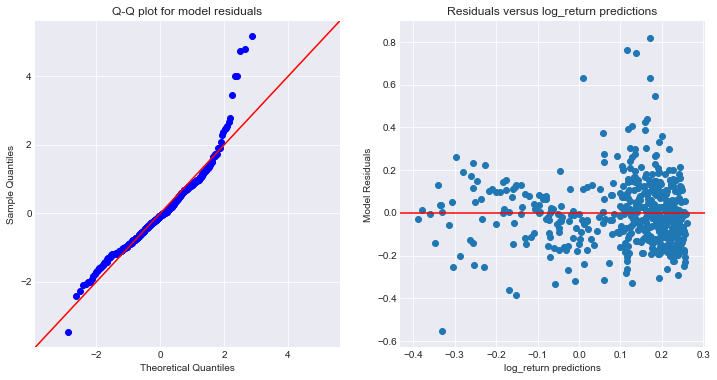

In [327]:
test_df = pd.DataFrame(list(zip(probas[:,1], log_returns.log_return)), index=log_returns.index)
print(test_df.head())
test_df.columns = ['probs', 'log_return']
model = mf.do_a_linreg(test_df, ['probs'], 'log_return')

In [328]:
# We can see a very linear relationship here, with a stronger r-squared score with the
# actual returns than we were getting when trying to regress those returns with our features
# The range of the predicted probabilities is extremely slim, which seems to be related to 
# the use of XGBRFClassifier. 

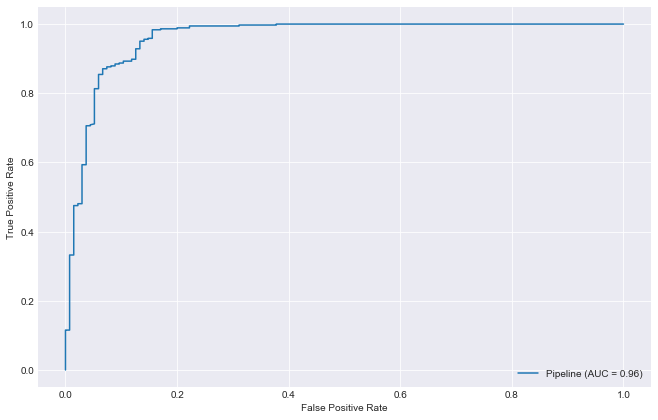

In [331]:
plot_roc_curve(grid_fit_new.best_estimator_, X=X_reduced, y=y.values)

Text(0.5, 1.0, 'Feature Importance')

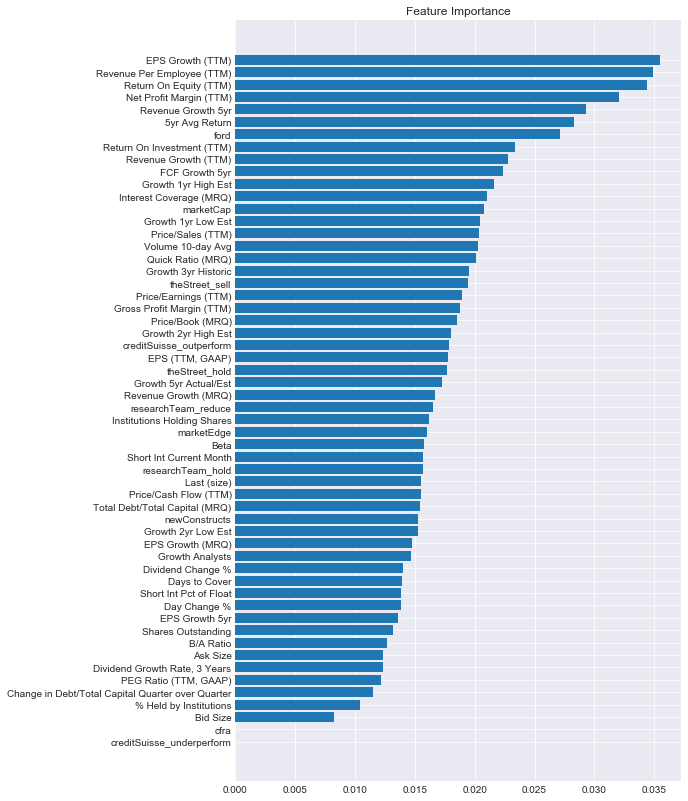

In [292]:
# Let's look at the feature importances for this model
feature_importance = grid_fit_new.best_estimator_.steps[2][1].feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(8, 14))
plt.subplot(1, 1, 1)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(X_reduced.columns)[sorted_idx])
plt.title('Feature Importance')

In [293]:
# Let's look now at the permutation importances, and compare
X_train, X_test, y_train, y_test = train_test_split(X_reduced, 
                                                    targets.class1, 
                                                    test_size=0.2,
                                                    random_state=0
                                                   )

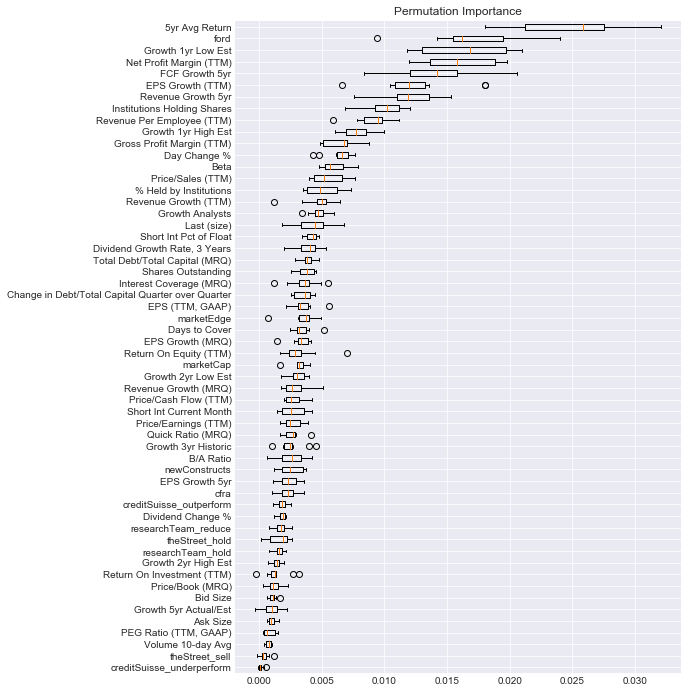

In [294]:
result = permutation_importance(grid_fit_new.best_estimator_, 
                                X_reduced, 
                                y, 
                                scoring='roc_auc',
                                n_repeats=10,
                                random_state=42, 
                                n_jobs=-1)
sorted_idx = result.importances_mean.argsort()
fig = plt.figure(figsize=(8,12))
plt.subplot(1, 1, 1)
plt.boxplot(result.importances[sorted_idx].T,
            vert=False, labels=np.array(X_reduced.columns)[sorted_idx])
plt.title("Permutation Importance")
plt.show()

#### XGBClassifier

In [302]:
# I'd like to see how this differs from the XGBClassifier, which gives more resolution
# in the predicted probabilities
scaler = StandardScaler()

imputer = SimpleImputer(strategy='constant', fill_value=0)

clf = XGBClassifier(random_state=0, n_jobs=-1)

steps = [('scaler', scaler),
         ('imputer', imputer),
         ('clf', clf)
        ]
estimator = Pipeline(steps=steps)

param_grid = {'clf__n_estimators': [100, 250, 500, 1000],
              'clf__max_depth': [2, 3, 5],
              'clf__learning_rate': [.001, .01, .1, .5],
              #'clf__booster': ['gbtree', 'gblinear', 'dart'],
              #'clf__reg_alpha': [0, 1],
              'clf__reg_lambda': [.5, 1],
              'clf__subsample': [.6, .8, 1],
              'clf__colsample_bytree': [.6, .8, 1],
              'clf__colsample_bylevel': [.6, .8, 1]
             }

grid_search = GridSearchCV(estimator, 
                           param_grid=param_grid, 
                           scoring='roc_auc', 
                           cv=5,
                           n_jobs=-1,
                           verbose=2
                          )
grid_fit = grid_search.fit(X_reduced, y)

Fitting 5 folds for each of 2592 candidates, totalling 12960 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   24.1s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed:  9.2min
[Parallel(n_jobs=-1)]: Done 3265 tasks      | elapsed: 11.7min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed: 14.5min
[Parallel(n_jobs=-1)]: Done 4885 tasks      | elapsed: 17.5min
[Parallel(n_jobs=-1)]: Done 5816 tasks      | elapsed: 20.5min
[Parallel(n_jobs=-1)]: Done 6829 tasks      | elapsed: 24.7min
[Parallel(n_jobs=-1)]: Done 7922 tasks      | elapsed: 28.6min
[Parallel(n_jobs=-1)]: Done 9097 tasks      | e

In [303]:
grid_fit.best_score_

0.7217416427081573

In [304]:
grid_fit.best_params_

{'clf__colsample_bylevel': 0.8,
 'clf__colsample_bytree': 0.6,
 'clf__learning_rate': 0.5,
 'clf__max_depth': 3,
 'clf__n_estimators': 250,
 'clf__reg_lambda': 0.5,
 'clf__subsample': 0.8}

In [307]:
# Looks like these are actually the out-of-box parameters
# Let's calculate the probabilities, and see if they have any relationship with the returns
probas = grid_fit.best_estimator_.predict_proba(X_reduced)
probas[:5]

array([[1.28412247e-03, 9.98715878e-01],
       [4.62931395e-03, 9.95370686e-01],
       [7.80701637e-04, 9.99219298e-01],
       [2.66492367e-04, 9.99733508e-01],
       [9.89969552e-01, 1.00304745e-02]], dtype=float32)

             0         1
A     0.998716  0.250673
AAL   0.995371  0.095848
AAP   0.999219  0.161577
AAPL  0.999734  0.398815
ABBV  0.010030 -0.014316
Linear Regression for log_return~probs


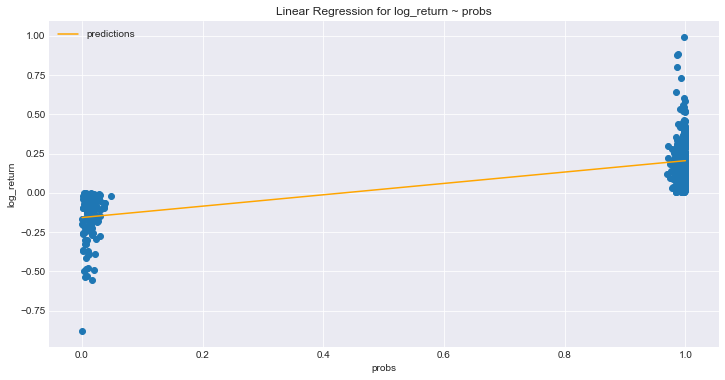

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             log_return   R-squared:                       0.535
Model:                            OLS   Adj. R-squared:                  0.534
Method:                 Least Squares   F-statistic:                     571.5
Date:                Mon, 16 Nov 2020   Prob (F-statistic):           1.20e-84
Time:                        19:12:53   Log-Likelihood:                 247.95
No. Observations:                 499   AIC:                            -491.9
Df Residuals:                     497   BIC:                            -483.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.1576      0.013    -12.248      0.000      -0.183      -0.132
probs          0.3621      0.015     23.907      0.000       0.332       0.392
==============================================================================
Omnibus:                       90.759   Durbin-Watson:                   1.920
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              443.705
Skew:                           0.693   Prob(JB):                     4.47e-97
Kurtosis:                       7.406   Cond. No.                         3.68
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Test for homoscedasticity of residuals:


F_statistic    p_value
Goldfeld-Quandt     1.32164  0.0379008

Normality Test Results for ['residuals']:
-------------------------------------------------------------------------------------------


K-S and Shapiro-Wilk: 
 
 
 
 
 K-S 
 Shapiro-Wilk 
 
 
 
 
 residuals 
 Statistic 
 3.905290e-01 
 9.408116e-01 
 
 
 p-value 
 4.644510e-69 
 3.348045e-13 
 
 
 Anderson-Darling: 
 
 
 
 statistic 
 critical 
 
 
 
 
 residuals 
 3.26174 
 0.781 
 
 
 Jarque-Bera: 
 
 
 
 residuals 
 
 
 
 
 Statistic 
 4.437054e+02 
 
 
 p-value 
 4.472957e-97 
 
 
 Skew 
 6.934894e-01 
 
 
 Kurtosis 
 7.406453e+00

Skew: 0.6934894135158187
Kurtosis: 4.406453270776098


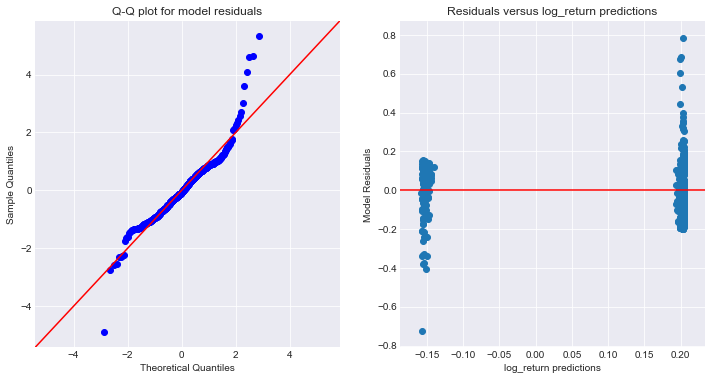

In [308]:
test_df = pd.DataFrame(list(zip(probas[:,1], log_returns.log_return)), index=log_returns.index)
print(test_df.head())
test_df.columns = ['probs', 'log_return']
model = mf.do_a_linreg(test_df, ['probs'], 'log_return')

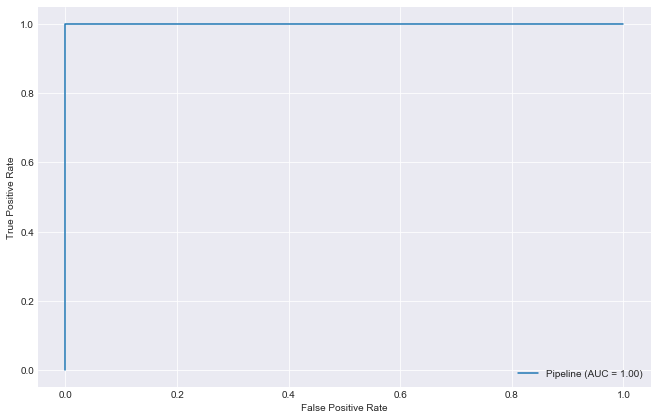

In [335]:
plot_roc_curve(grid_fit.best_estimator_, X=X_reduced, y=y.values)

Text(0.5, 1.0, 'Feature Importance')

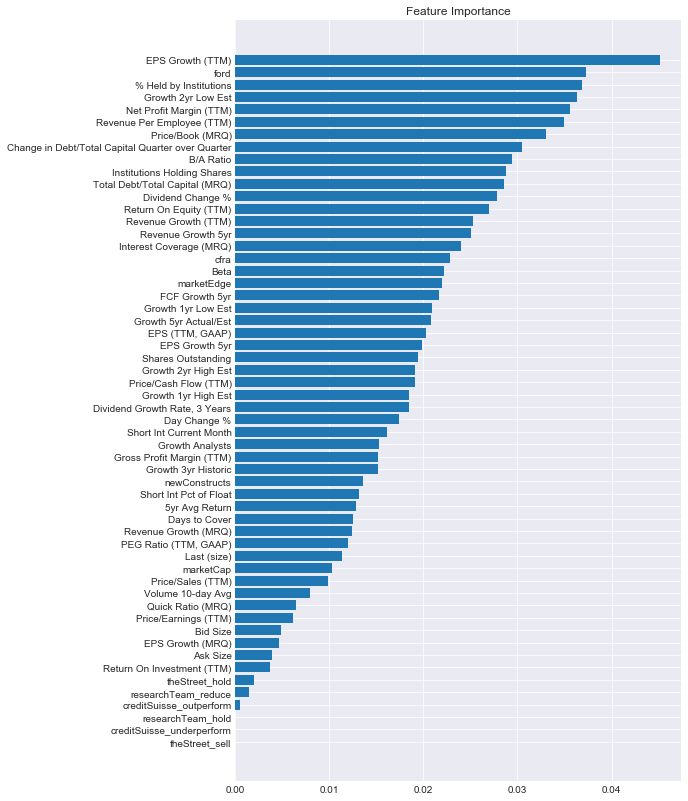

In [336]:
# Let's look at the feature importances for this model
feature_importance = grid_fit.best_estimator_.steps[2][1].feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(8, 14))
plt.subplot(1, 1, 1)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(X_reduced.columns)[sorted_idx])
plt.title('Feature Importance')

In [337]:
# Let's look now at the permutation importances, and compare
X_train, X_test, y_train, y_test = train_test_split(X_reduced, 
                                                    targets.class1, 
                                                    test_size=0.2,
                                                    random_state=0
                                                   )

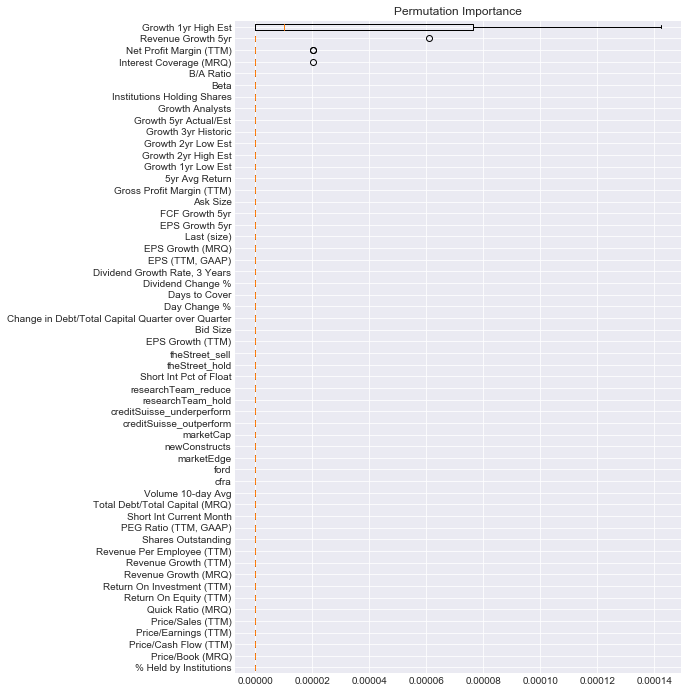

In [338]:
result = permutation_importance(grid_fit.best_estimator_, 
                                X_reduced, 
                                y, 
                                scoring='roc_auc',
                                n_repeats=10,
                                random_state=42, 
                                n_jobs=-1)
sorted_idx = result.importances_mean.argsort()
fig = plt.figure(figsize=(8,12))
plt.subplot(1, 1, 1)
plt.boxplot(result.importances[sorted_idx].T,
            vert=False, labels=np.array(X_reduced.columns)[sorted_idx])
plt.title("Permutation Importance")
plt.show()

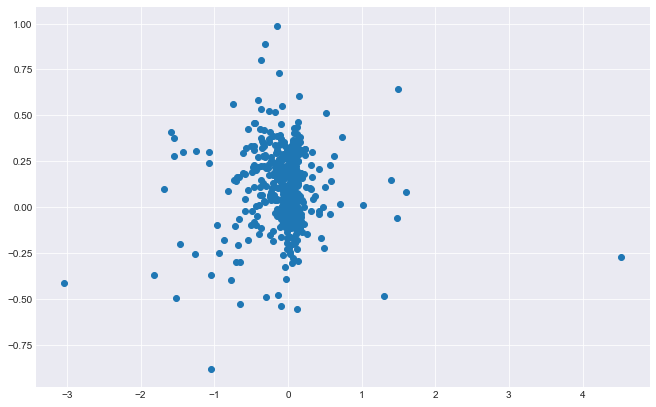

In [339]:
plt.scatter(X_reduced['Growth 1yr High Est'], targets.log_return)

In [118]:
#imputer_estimator = KNeighborsRegressor(n_neighbors=15, weights='distance', n_jobs=-1)

scaler = StandardScaler()

#imputer = IterativeImputer(estimator=imputer_estimator,
#                           max_iter=50,
#                           add_indicator=False
#                          )

imputer = KNNImputer(weights='distance', add_indicator=False)

clf = XGBRFClassifier(n_jobs=-1, random_state=0)

steps = [('scaler', scaler),
         ('imputer', imputer),
         ('clf', clf)
        ]
estimator = Pipeline(steps=steps)

param_grid = {#'imputer__n_nearest_features': [5, 15, None],
              'clf__max_depth': [3, 5, 7],
              'clf__learning_rate': [.001, .01, .1, 1],
              'clf__n_estimators': [100, 300, 500],
              'clf__subsample': [0.8, 1.0],
              'clf__colsample_bytree': [0.6, 0.8, 1.0],
              #'clf__colsample_bylevel': [0.6, 0.8, 1.0],
              'clf__colsample_bynode': [0.6, 0.8, 1.0],
              'clf__reg_alpha': [0, 0.5, 1],
              'clf__reg_lambda': [.25, .5, .75, 1]
             }

grid_search = GridSearchCV(estimator=estimator, 
                           param_grid=param_grid,
                           scoring='roc_auc',
                           n_jobs=-1,
                           cv=5,
                           verbose=2
                          )
grid_fit_new = grid_search.fit(X_reduced, y)

Fitting 5 folds for each of 7776 candidates, totalling 38880 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   19.6s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed:  7.5min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed:  9.9min
[Parallel(n_jobs=-1)]: Done 3265 tasks      | elapsed: 13.0min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed: 15.2min
[Parallel(n_jobs=-1)]: Done 4885 tasks      | elapsed: 18.2min
[Parallel(n_jobs=-1)]: Done 5816 tasks      | elapsed: 21.8min
[Parallel(n_jobs=-1)]: Done 6829 tasks      | elapsed: 25.9min
[Parallel(n_jobs=-1)]: Done 7922 tasks      | elapsed: 30.0min
[Parallel(n_jobs=-1)]: Done 9097 tasks      | e

In [119]:
# Let's see what the best score was
grid_fit_new.best_score_

0.7194388071480918

In [120]:
# This is our highest score yet
# Let's look at the parameters
grid_fit_new.best_params_

{'clf__colsample_bynode': 0.6,
 'clf__colsample_bytree': 1.0,
 'clf__learning_rate': 0.01,
 'clf__max_depth': 5,
 'clf__n_estimators': 100,
 'clf__reg_alpha': 0,
 'clf__reg_lambda': 0.25,
 'clf__subsample': 0.8}

In [122]:
# Looks like these are actually the out-of-box parameters
# Let's calculate the probabilities, and see if they have any relationship with the returns
probas = grid_fit_new.best_estimator_.predict_proba(X_reduced)
probas[:5]

array([[0.49709398, 0.502906  ],
       [0.4968155 , 0.5031845 ],
       [0.49600726, 0.50399274],
       [0.49659562, 0.5034044 ],
       [0.499398  , 0.500602  ]], dtype=float32)

             0         1
A     0.502906  0.250673
AAL   0.503184  0.095848
AAP   0.503993  0.161577
AAPL  0.503404  0.398815
ABBV  0.500602 -0.014316
Linear Regression for log_return~probs


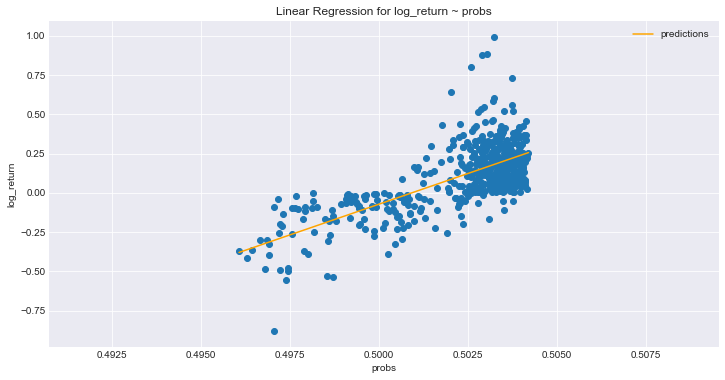

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             log_return   R-squared:                       0.474
Model:                            OLS   Adj. R-squared:                  0.473
Method:                 Least Squares   F-statistic:                     448.1
Date:                Sat, 07 Nov 2020   Prob (F-statistic):           2.24e-71
Time:                        01:05:04   Log-Likelihood:                 217.33
No. Observations:                 499   AIC:                            -430.7
Df Residuals:                     497   BIC:                            -422.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -39.2167      1.858    -21.111      0.000     -42.866     -35.567
probs         78.2878      3.698     21.169      0.000      71.022      85.554
==============================================================================
Omnibus:                      106.921   Durbin-Watson:                   1.910
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              346.203
Skew:                           0.979   Prob(JB):                     6.65e-76
Kurtosis:                       6.580   Cond. No.                         660.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Test for homoscedasticity of residuals:


F_statistic      p_value
Goldfeld-Quandt     1.58248  0.000656637

Normality Test Results for ['residuals']:
-------------------------------------------------------------------------------------------


K-S and Shapiro-Wilk: 
 
 
 
 
 K-S 
 Shapiro-Wilk 
 
 
 
 
 residuals 
 Statistic 
 3.781348e-01 
 9.472486e-01 
 
 
 p-value 
 1.277958e-64 
 2.444540e-12 
 
 
 Anderson-Darling: 
 
 
 
 statistic 
 critical 
 
 
 
 
 residuals 
 3.348954 
 0.781 
 
 
 Jarque-Bera: 
 
 
 
 residuals 
 
 
 
 
 Statistic 
 3.462028e+02 
 
 
 p-value 
 6.652999e-76 
 
 
 Skew 
 9.792246e-01 
 
 
 Kurtosis 
 6.579876e+00

Skew: 0.9792245518428477
Kurtosis: 3.579876186919881


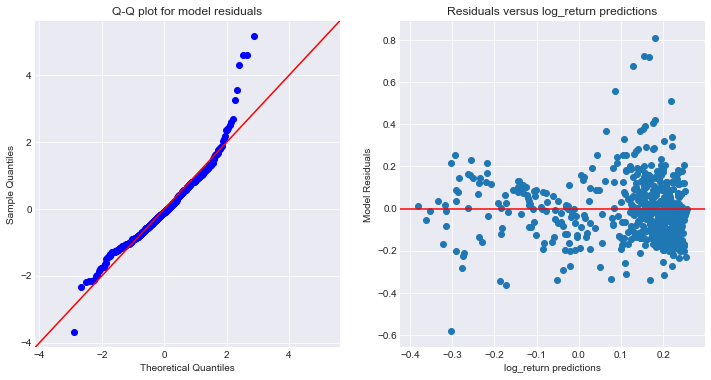

In [123]:
test_df = pd.DataFrame(list(zip(probas[:,1], log_returns.log_return)), index=log_returns.index)
print(test_df.head())
test_df.columns = ['probs', 'log_return']
mf.do_a_linreg(test_df, ['probs'], 'log_return')

In [ ]:
# We can see a very linear relationship here

Text(0.5, 1.0, 'Feature Importance')

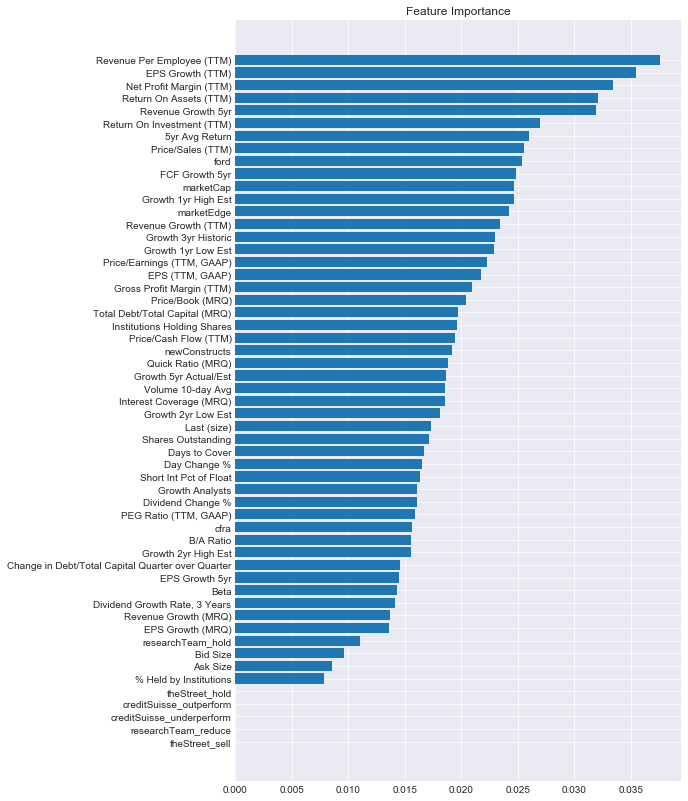

In [126]:
# Let's look at the feature importances for this model
feature_importance = grid_fit_new.best_estimator_.steps[2][1].feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(8, 14))
plt.subplot(1, 1, 1)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(X_reduced.columns)[sorted_idx])
plt.title('Feature Importance')

In [127]:
# Let's look now at the permutation importances, and compare
X_train, X_test, y_train, y_test = train_test_split(X_reduced, 
                                                    targets.class1, 
                                                    test_size=0.2,
                                                    random_state=0
                                                   )

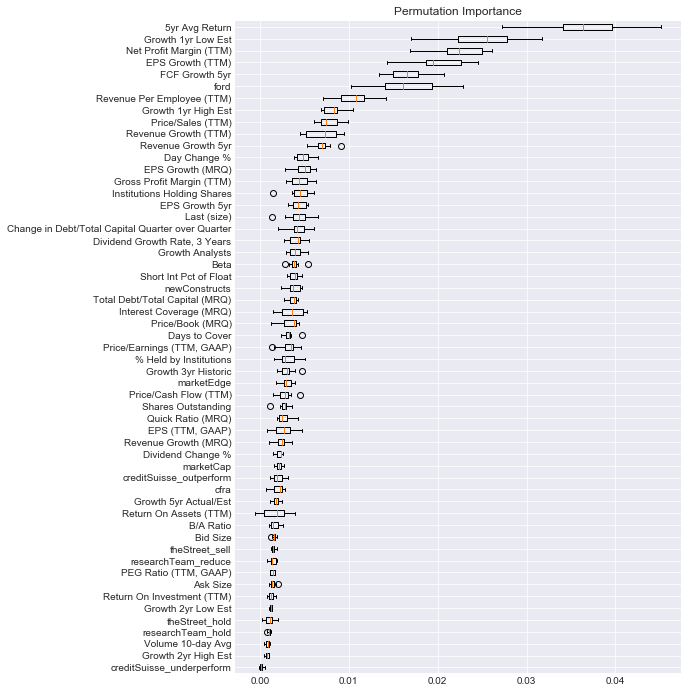

In [130]:
result = permutation_importance(grid_fit_new.best_estimator_, 
                                X_reduced, 
                                y, 
                                scoring='roc_auc',
                                n_repeats=10,
                                random_state=42, 
                                n_jobs=-1)
sorted_idx = result.importances_mean.argsort()
fig = plt.figure(figsize=(8,12))
plt.subplot(1, 1, 1)
plt.boxplot(result.importances[sorted_idx].T,
            vert=False, labels=np.array(X_reduced.columns)[sorted_idx])
plt.title("Permutation Importance")
plt.show()

Text(0, 0.5, 'log return')

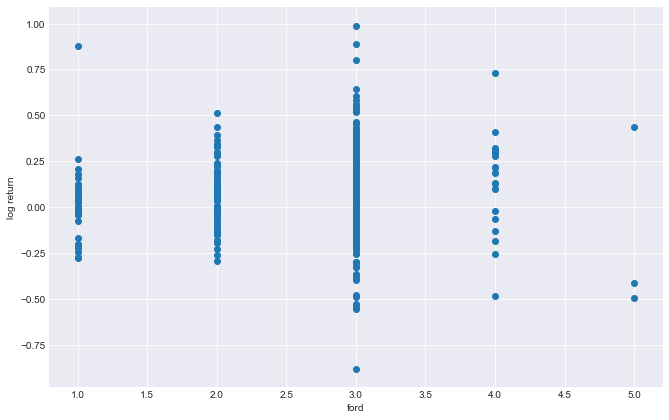

In [131]:
plt.scatter(X_reduced.ford, targets.log_return)
plt.xlabel('ford')
plt.ylabel('log return')

## Modeling - Relative Performance to index
We have now modeled the returns with some compelling results. Assuming that the model is robust to different time periods, it could possibly give a trader an edge in predicting returns of a stock, however, if market conditions change, so too might the accuracy of the model. In any case, the model above has provided some useful insights on what fundamental financial features had the most predictive power in the model. Now, we can turn to modeling a slightly different target: the relative performance of securities within the index to the overall index. 

Market trends do change. The time period of study takes place in an upward trend of the S&P 500, but for all we know, the market may trend downward in the next 6 months. This would affect the prospect of gaining an edge by deploying the model in the next 6 months. One could defend against such uncertainty by only investing or shorting in stocks that were outside of a central window of ambivalence within the predicted probabilites, but it might be difficult to tell from the above model what threshold, and window around it, would be the most safe moving forward. 

This is why we will subtract the mean return of the index from each return, so that instead of classifying gainers/losers, we are classifying over/under performers. A model developed to model such a classification may be more informative about the driving factors in a stock's performance, since it will seek to find the features which predict whether a stock will do better or worse than the index, rather than whether it had gains or losses, the latter of which is more likely to be variable with time. Having modeled returns using our features during an uptrend, the previous model may have seen certain features driving gains, when really the gains were attributable to the upward motion of the market itself, and not those the fundamental features. Investors take on a risk when investing in the market, and the best they can hope to do during any period in which they are invested into a given market is to outperform the market. That is exactly what this model will hope to accomplish. 

Unfortunately, we do not have data relating to another time period to test the tradability of either of our models (as of now), but we can certainly learn a lot from the feature importances of these models, to understand what fundamental financial features of a company drive its returns or relative performance to the market.

In [133]:
y = targets.class2

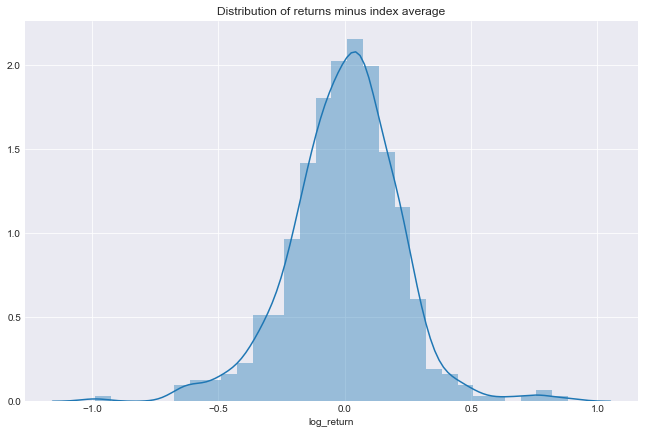

In [137]:
# A look at the distribution of our new target (classes split over zero line)
sns.distplot(targets.log_return - targets.log_return.mean())
plt.title('Distribution of returns minus index average');

In [138]:
#imputer_estimator = KNeighborsRegressor(n_neighbors=15, weights='distance', n_jobs=-1)

scaler = StandardScaler()

#imputer = IterativeImputer(estimator=imputer_estimator,
#                           max_iter=50,
#                           add_indicator=False
#                          )

imputer = KNNImputer(weights='distance', add_indicator=False)

clf = XGBRFClassifier(n_jobs=-1, random_state=0)

steps = [('scaler', scaler),
         ('imputer', imputer),
         ('clf', clf)
        ]
estimator = Pipeline(steps=steps)

param_grid = {#'imputer__n_nearest_features': [5, 15, None],
              'clf__max_depth': [3, 5, 7],
              'clf__learning_rate': [.001, .01, .1, 1],
              'clf__n_estimators': [100, 300, 500],
              'clf__subsample': [0.8, 1.0],
              'clf__colsample_bytree': [0.6, 0.8, 1.0],
              #'clf__colsample_bylevel': [0.6, 0.8, 1.0],
              'clf__colsample_bynode': [0.6, 0.8, 1.0],
              'clf__reg_alpha': [0, 0.5, 1],
              'clf__reg_lambda': [.25, .5, .75, 1]
             }

grid_search = GridSearchCV(estimator=estimator, 
                           param_grid=param_grid,
                           scoring='roc_auc',
                           n_jobs=-1,
                           cv=5,
                           verbose=2
                          )
grid_fit_new2 = grid_search.fit(X_reduced, y)

Fitting 5 folds for each of 7776 candidates, totalling 38880 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   55.0s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed:  9.7min
[Parallel(n_jobs=-1)]: Done 3265 tasks      | elapsed: 13.3min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed: 15.6min
[Parallel(n_jobs=-1)]: Done 4885 tasks      | elapsed: 18.8min
[Parallel(n_jobs=-1)]: Done 5816 tasks      | elapsed: 22.8min
[Parallel(n_jobs=-1)]: Done 6829 tasks      | elapsed: 27.2min
[Parallel(n_jobs=-1)]: Done 7922 tasks      | elapsed: 31.9min
[Parallel(n_jobs=-1)]: Done 9097 tasks      | e

In [139]:
# Let's see what the best score was
grid_fit_new2.best_score_

0.7016510077303936

In [140]:
# This is our highest score yet
# Let's look at the parameters
grid_fit_new.best_params_

{'clf__colsample_bynode': 0.6,
 'clf__colsample_bytree': 1.0,
 'clf__learning_rate': 0.01,
 'clf__max_depth': 5,
 'clf__n_estimators': 100,
 'clf__reg_alpha': 0,
 'clf__reg_lambda': 0.25,
 'clf__subsample': 0.8}

In [145]:
# Looks like these are actually the out-of-box parameters
# Let's calculate the probabilities, and see if they have any relationship with the returns
probas = grid_fit_new2.best_estimator_.predict_proba(X_reduced)
probas[:5]

array([[0.4997273 , 0.5002727 ],
       [0.5001379 , 0.4998621 ],
       [0.4997357 , 0.5002643 ],
       [0.4996686 , 0.5003314 ],
       [0.5003489 , 0.49965107]], dtype=float32)

             0         1
A     0.500273  0.250673
AAL   0.499862  0.095848
AAP   0.500264  0.161577
AAPL  0.500331  0.398815
ABBV  0.499651 -0.014316
Linear Regression for log_return~probs


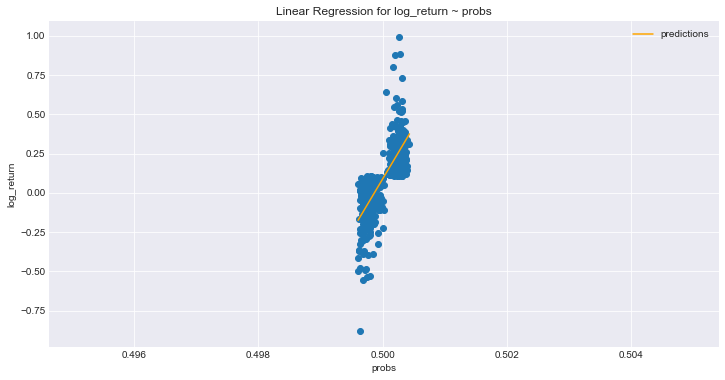

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             log_return   R-squared:                       0.568
Model:                            OLS   Adj. R-squared:                  0.567
Method:                 Least Squares   F-statistic:                     654.3
Date:                Sun, 08 Nov 2020   Prob (F-statistic):           1.04e-92
Time:                        11:18:28   Log-Likelihood:                 266.55
No. Observations:                 499   AIC:                            -529.1
Df Residuals:                     497   BIC:                            -520.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -332.6093     13.008    -25.570      0.000    -358.166    -307.053
probs        665.3958     26.014     25.579      0.000     614.285     716.506
==============================================================================
Omnibus:                       70.312   Durbin-Watson:                   2.091
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              496.344
Skew:                           0.338   Prob(JB):                    1.66e-108
Kurtosis:                       7.839   Cond. No.                     5.11e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.11e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Test for homoscedasticity of residuals:


F_statistic   p_value
Goldfeld-Quandt    0.839623  0.192491

Normality Test Results for ['residuals']:
-------------------------------------------------------------------------------------------


K-S and Shapiro-Wilk: 
 
 
 
 
 K-S 
 Shapiro-Wilk 
 
 
 
 
 residuals 
 Statistic 
 3.808414e-01 
 9.366727e-01 
 
 
 p-value 
 1.416207e-65 
 1.006234e-13 
 
 
 Anderson-Darling: 
 
 
 
 statistic 
 critical 
 
 
 
 
 residuals 
 4.418794 
 0.781 
 
 
 Jarque-Bera: 
 
 
 
 residuals 
 
 
 
 
 Statistic 
 4.963436e+02 
 
 
 p-value 
 1.660951e-108 
 
 
 Skew 
 3.380102e-01 
 
 
 Kurtosis 
 7.838929e+00

Skew: 0.3380102077464971
Kurtosis: 4.838928974624217


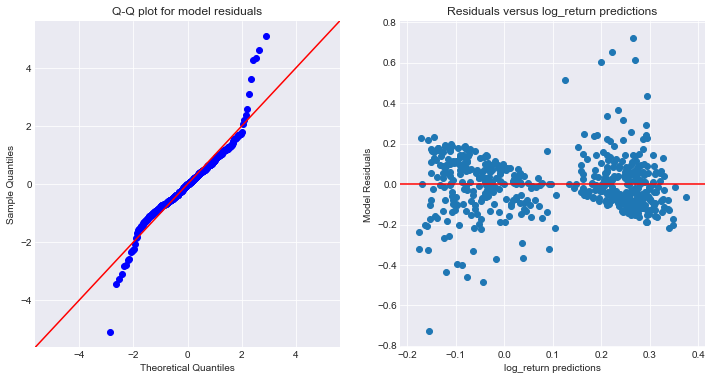

In [146]:
test_df = pd.DataFrame(list(zip(probas[:,1], log_returns.log_return)), index=log_returns.index)
print(test_df.head())
test_df.columns = ['probs', 'log_return']
mf.do_a_linreg(test_df, ['probs'], 'log_return')

In [143]:
# We can see a very linear relationship here

Text(0.5, 1.0, 'Feature Importance')

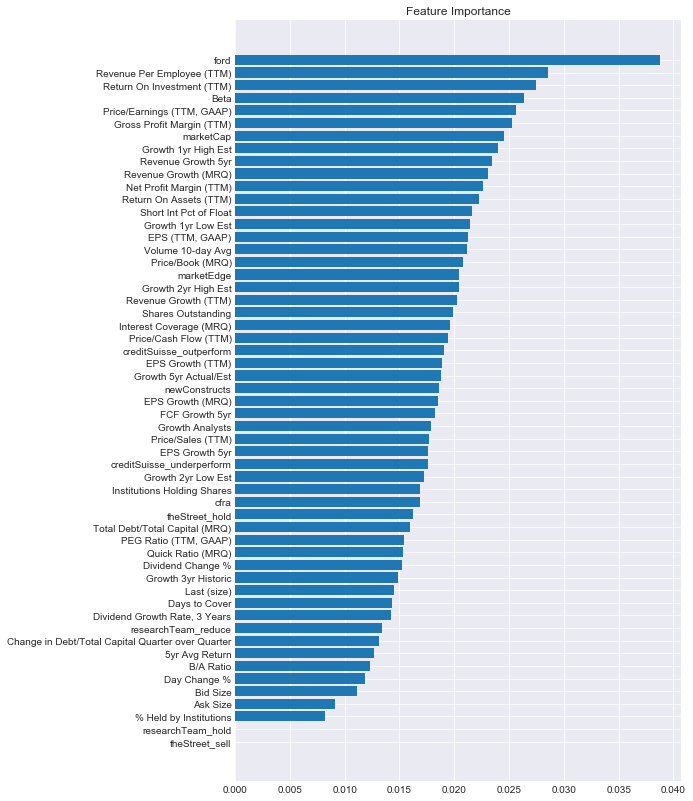

In [147]:
# Let's look at the feature importances for this model
feature_importance = grid_fit_new2.best_estimator_.steps[2][1].feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(8, 14))
plt.subplot(1, 1, 1)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(X_reduced.columns)[sorted_idx])
plt.title('Feature Importance')

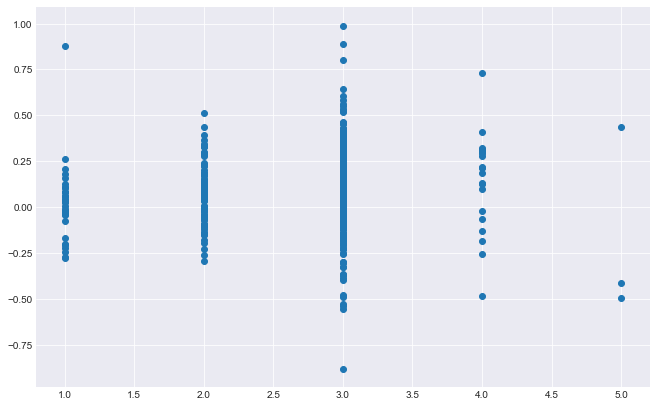

In [155]:
# We've seen ford make multiple appearances in high places, let's look at a scatter of ford
# with the target
plt.scatter(X_reduced.ford, targets.log_return)

In [148]:
# Let's look now at the permutation importances, and compare
X_train, X_test, y_train, y_test = train_test_split(X_reduced, 
                                                    targets.class1, 
                                                    test_size=0.2,
                                                    random_state=0
                                                   )

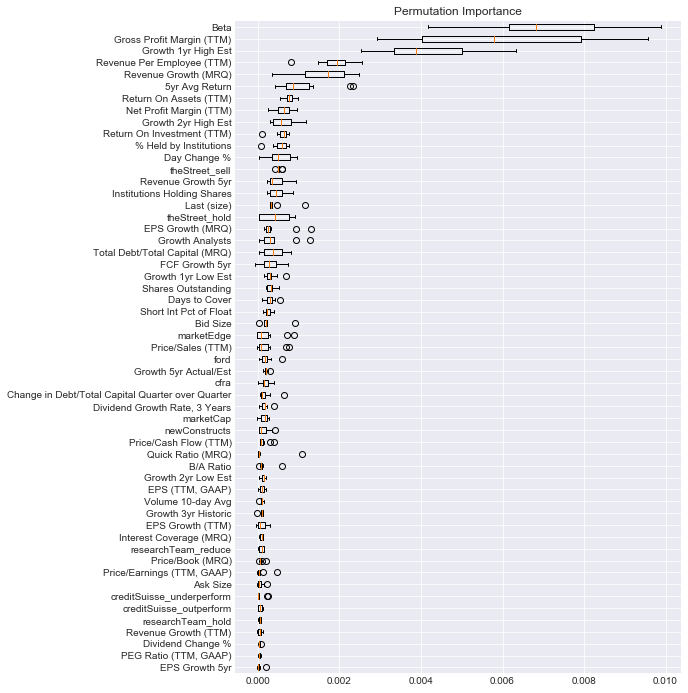

In [149]:
result = permutation_importance(grid_fit_new2.best_estimator_, 
                                X_reduced, 
                                targets.class2, 
                                scoring='roc_auc',
                                n_repeats=10,
                                random_state=42, 
                                n_jobs=-1)
sorted_idx = result.importances_mean.argsort()
fig = plt.figure(figsize=(8,12))
plt.subplot(1, 1, 1)
plt.boxplot(result.importances[sorted_idx].T,
            vert=False, labels=np.array(X_reduced.columns)[sorted_idx])
plt.title("Permutation Importance")
plt.show()

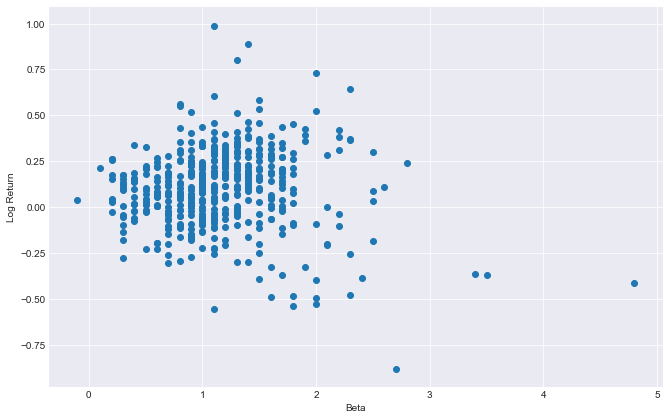

In [157]:
# Beta is at the top of this list, let's look at its relationship to log_returns
plt.scatter(X_reduced.Beta, targets.log_return)
plt.xlabel('Beta')
plt.ylabel('Log Return');

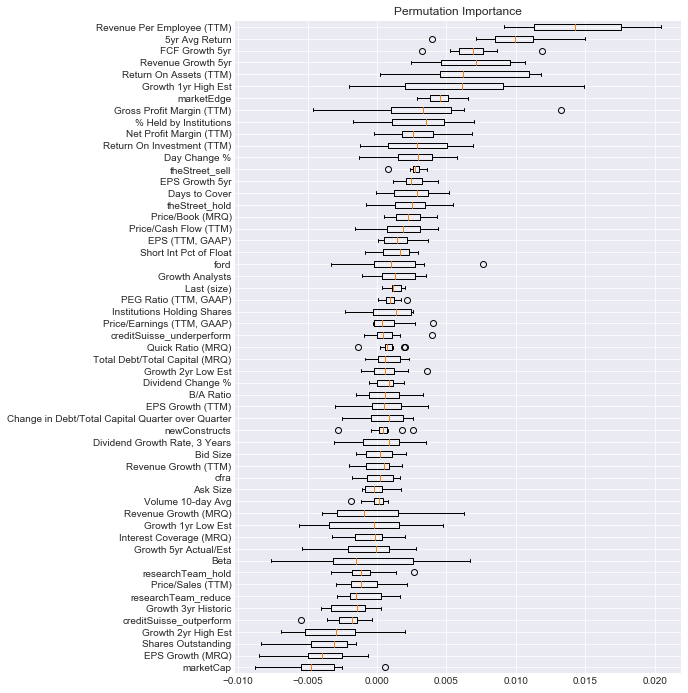

In [151]:
result = permutation_importance(grid_fit_new2.best_estimator_, 
                                X_train, 
                                y_train, 
                                scoring='roc_auc',
                                n_repeats=10,
                                random_state=42, 
                                n_jobs=-1)
sorted_idx = result.importances_mean.argsort()
fig = plt.figure(figsize=(8,12))
plt.subplot(1, 1, 1)
plt.boxplot(result.importances[sorted_idx].T,
            vert=False, labels=np.array(X_reduced.columns)[sorted_idx])
plt.title("Permutation Importance")
plt.show()

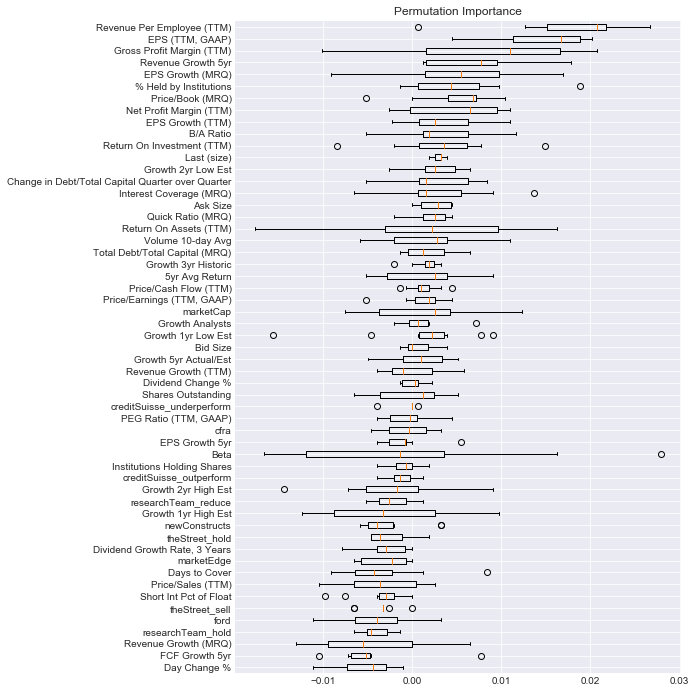

In [153]:
result = permutation_importance(grid_fit_new2.best_estimator_, 
                                X_test, 
                                y_test, 
                                scoring='roc_auc',
                                n_repeats=10,
                                random_state=42, 
                                n_jobs=-1)
sorted_idx = result.importances_mean.argsort()
fig = plt.figure(figsize=(8,12))
plt.subplot(1, 1, 1)
plt.boxplot(result.importances[sorted_idx].T,
            vert=False, labels=np.array(X_reduced.columns)[sorted_idx])
plt.title("Permutation Importance")
plt.show()

In [158]:
# We are seeing a lot of variability in these permutation importances still. It appears as
# though different features were more important for different sets of securities, which
# is an indication that although some of our features have consistently been at the top, our
# rich list of features is helpful in getting accurate classifications, as when certain ones
# are providing weak predictive power for certain securities, others are helping instead.
# Perhaps to get a more sophisticated view, we could shuffle the data multiple times and average
# the permutation importances for each shuffle
# Let's look at the structure of the permutation importances
result

{'importances_mean': array([ 0.00526316,  0.00152697,  0.00259909,  0.00337882, -0.00087719,
         0.00071475,  0.00272904, -0.00510071, -0.00331384,  0.00012995,
        -0.00279402,  0.01487979,  0.00552307,  0.00357375, -0.0008447 ,
        -0.00474334,  0.00883691, -0.00266407,  0.00097466, -0.00188434,
         0.00279402,  0.00162443,  0.00068226,  0.00103964, -0.00097466,
         0.00259909,  0.00292398,  0.00506823, -0.0005848 ,  0.00526316,
         0.00129955,  0.00129955, -0.00334633,  0.00214425,  0.00207927,
         0.00331384, -0.00448343,  0.00025991,  0.0074399 ,  0.01786875,
        -0.00019493, -0.00341131,  0.00181936,  0.00198181, -0.0005848 ,
        -0.00389864, -0.00298895, -0.00266407,  0.0011371 , -0.00129955,
        -0.00032489, -0.00396361, -0.00207927, -0.00272904, -0.00350877]),
 'importances_std': array([0.00572906, 0.00472159, 0.00181472, 0.00435687, 0.01365145,
        0.00157695, 0.00395295, 0.00293137, 0.00484898, 0.00114589,
        0.00219485, 

In [161]:
# We need the importances, and to concatenate dataframes. Let's see how a df looks
pd.DataFrame(result.importances).head()

0         1         2         3         4         5         6  \
0  1.110223e-16  0.009747  0.007797 -0.000650 -0.001300  0.006823  0.003899   
1 -3.248863e-03  0.001949 -0.004548  0.007797  0.009097  0.004224  0.003249   
2  0.000000e+00  0.003899  0.004548  0.000000  0.003899  0.004548  0.001949   
3  1.949318e-03  0.001300  0.001300  0.006498 -0.005198  0.001300  0.011696   
4 -1.624431e-02 -0.012346 -0.016569  0.000650 -0.010396 -0.002599  0.027940   

          7         8         9  
0  0.002599  0.004873  0.018843  
1 -0.001300 -0.005198  0.003249  
2  0.001949  0.000650  0.004548  
3  0.007147  0.001949  0.005848  
4  0.016244  0.004548  0.000000

In [162]:
# If we concatenate all the results on axis 1, we can get a grand view of what the importances
# average out to over many different instances.
combined = pd.DataFrame()
y = targets.class2

for i in range(100):
    X_train, X_test, y_train, y_test = train_test_split(X_reduced, targets.class2, test_size=.2)
    scaler = StandardScaler()
    imputer = KNNImputer(weights='distance', add_indicator=False)

    clf = XGBRFClassifier(colsample_bynode=0.6,
                          colsample_bytree=1,
                          learning_rate=0.01,
                          max_depth=5,
                          n_estimators=100,
                          reg_alpha=0,
                          reg_lambda=0.25,
                          subsample=0.8,
                          n_jobs=-1, 
                          random_state=0
                         )

    steps = [('scaler', scaler),
             ('imputer', imputer),
             ('clf', clf)
            ]
    est = Pipeline(steps=steps)
    est.fit(X_train, y_train)
    result = permutation_importance(est, 
                                    X_test, 
                                    y_test, 
                                    scoring='roc_auc',
                                    n_repeats=10, 
                                    n_jobs=-1)
    temp = pd.DataFrame(result.importances)
    combined = pd.concat([combined, temp], axis = 1)

In [168]:
combined.mean(axis=1)

0     0.000078
1     0.003706
2    -0.000528
3    -0.000940
4     0.035215
5     0.000731
6    -0.000379
7     0.001169
8     0.000007
9    -0.000280
10    0.000718
11    0.004454
12    0.001669
13    0.004275
14    0.001060
15    0.001758
16    0.012352
17    0.013171
18    0.007187
19    0.006408
20    0.001057
21   -0.000895
22    0.001532
23    0.000564
24    0.002087
25    0.004044
26   -0.000902
27    0.001610
28    0.000094
29    0.002896
30    0.001211
31    0.001555
32    0.001358
33    0.000235
34    0.000051
35   -0.000448
36    0.005404
37    0.000970
38    0.008748
39    0.007209
40    0.001138
41    0.000389
42   -0.000409
43    0.000161
44   -0.000641
45    0.004045
46    0.000409
47    0.001744
48    0.008794
49    0.001074
50   -0.000608
51    0.000386
52    0.000133
53    0.000256
54   -0.002729
dtype: float64

In [179]:
combined.mean(axis=1).sort_values(ascending=False)

4     0.035215
17    0.013171
16    0.012352
48    0.008794
38    0.008748
39    0.007209
18    0.007187
19    0.006408
36    0.005404
11    0.004454
13    0.004275
45    0.004045
25    0.004044
1     0.003706
29    0.002896
24    0.002087
15    0.001758
47    0.001744
12    0.001669
27    0.001610
31    0.001555
22    0.001532
32    0.001358
30    0.001211
7     0.001169
40    0.001138
49    0.001074
14    0.001060
20    0.001057
37    0.000970
5     0.000731
10    0.000718
23    0.000564
46    0.000409
41    0.000389
51    0.000386
53    0.000256
33    0.000235
43    0.000161
52    0.000133
28    0.000094
0     0.000078
34    0.000051
8     0.000007
9    -0.000280
6    -0.000379
42   -0.000409
35   -0.000448
2    -0.000528
50   -0.000608
44   -0.000641
21   -0.000895
26   -0.000902
3    -0.000940
54   -0.002729
dtype: float64

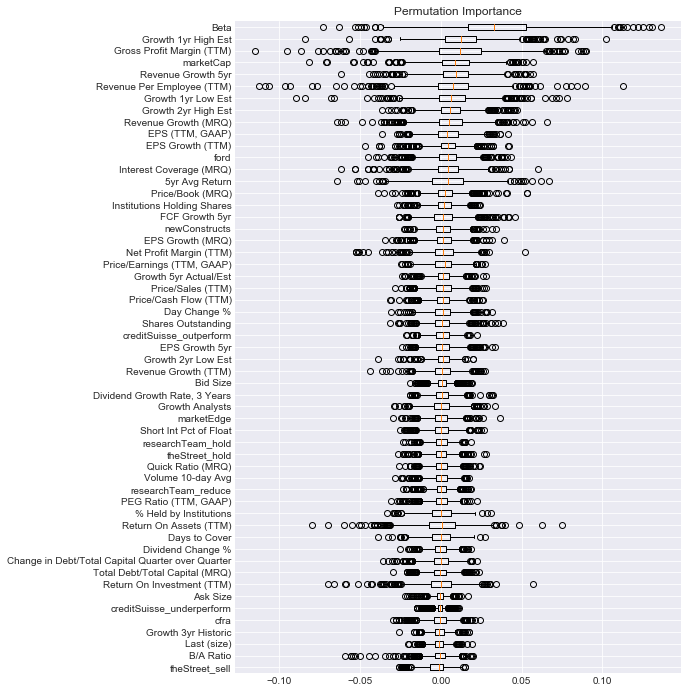

In [177]:
sorted_idx = combined.mean(axis=1).argsort()
fig = plt.figure(figsize=(8,12))
plt.subplot(1, 1, 1)
plt.boxplot(combined.iloc[sorted_idx],
            vert=False, labels=np.array(X_reduced.columns)[sorted_idx])
plt.title("Permutation Importance")
plt.show()

In [ ]:
# These are interesting results. It seems as though there is a lot of variablility on the 
# value of various features over many different models. This is another indication that all of
# the features are actually valuable, but for different securities. 
# We do see that the top of the list contains a lot of familiar faces, however, even if they are
# much closer to zero than they were before. This is a good indication that we can say with
# confidence that these features are indeed the most important, but we are starting to see
# the gap shrinking, showing us that really all of the information is important, albeit some
# more than others.
# Instead of calculating permutation importances on the holdout sets, let's run this again and 
# calculate them with the training sets.

In [181]:
combined = pd.DataFrame()
y = targets.class2

for i in range(100):
    X_train, X_test, y_train, y_test = train_test_split(X_reduced, targets.class2, test_size=.2)
    scaler = StandardScaler()
    imputer = KNNImputer(weights='distance', add_indicator=False)

    clf = XGBRFClassifier(colsample_bynode=0.6,
                          colsample_bytree=1,
                          learning_rate=0.01,
                          max_depth=5,
                          n_estimators=100,
                          reg_alpha=0,
                          reg_lambda=0.25,
                          subsample=0.8,
                          n_jobs=-1, 
                          random_state=0
                         )

    steps = [('scaler', scaler),
             ('imputer', imputer),
             ('clf', clf)
            ]
    est = Pipeline(steps=steps)
    est.fit(X_train, y_train)
    result = permutation_importance(est, 
                                    X_train, 
                                    y_train, 
                                    scoring='roc_auc',
                                    n_repeats=10, 
                                    n_jobs=-1)
    temp = pd.DataFrame(result.importances)
    combined = pd.concat([combined, temp], axis = 1)

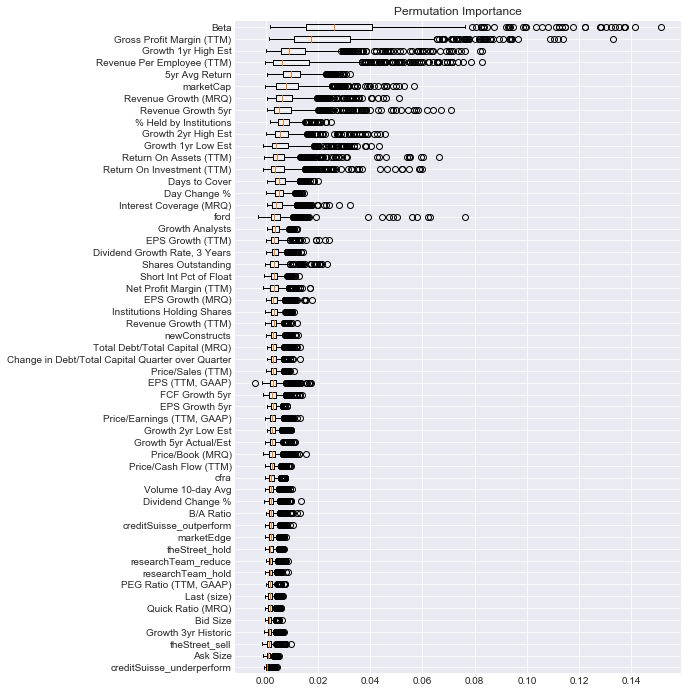

In [182]:
sorted_idx = combined.mean(axis=1).argsort()
fig = plt.figure(figsize=(8,12))
plt.subplot(1, 1, 1)
plt.boxplot(combined.iloc[sorted_idx],
            vert=False, labels=np.array(X_reduced.columns)[sorted_idx])
plt.title("Permutation Importance")
plt.show()

In [ ]:
# We can see at this point that when running permutation importance on data that the estimator
# has been trained on, the importances tend to be positive. When we run these on holdout sets,
# we get a lot of negative values for importances, which indicate that when a feature was
# shuffled, somehow it resulted in higher accuracy in predicting the testing set, even though
# it may have been important in the training set. This is the nature of testing models on 
# unseen data, which will have characteristics not seen by the model before. 

# Fortunately, we are seeing the same few features populating the tops of both of these lists,
# which means that we are finally approaching the point of saying with confidence that these
# features consistently provided models with the most predictive power.

# An overlying issue with interpreting these feature importances is, as we saw earlier, they
# do not necessarily have a linear relationship with the target variable, and that although 
# they are important to the model, we do not have an intuitive explanation for how the model
# is using the features, so although we can say that Beta or Revenue per Employee is an
# important feature for prediction, we can't say that higher/lower is better, or explain to 
# an investor what to look for outside of the context of our model. What we have learned, which
# can be stated objectively, is that all of the features find themselves playing some role
# in the predictive power of the model from time to time, so that the fact that the web scraper
# managed to collect so much information is a great thing.

### XGBoost without Imputation
Reading more about XGBoost, it turns out that it comes equipped with its own imputation capabilities, which are supposedly quite good. So far we have been using sklearn imputation methods as part of the pipeline on the way into XGBoost, so it may be revealing to compare this to feeding the sparse data into XGBoost.

In [184]:
y = targets.class2

In [185]:
scaler = StandardScaler()

clf = XGBRFClassifier(n_jobs=-1, random_state=0)

steps = [('scaler', scaler),
         ('clf', clf)
        ]
estimator = Pipeline(steps=steps)

param_grid = {'clf__max_depth': [3, 5, 7],
              'clf__learning_rate': [.001, .01, .1, 1],
              'clf__n_estimators': [100, 300, 500],
              'clf__subsample': [0.8, 1.0],
              'clf__colsample_bytree': [0.6, 0.8, 1.0],
              #'clf__colsample_bylevel': [0.6, 0.8, 1.0],
              'clf__colsample_bynode': [0.6, 0.8, 1.0],
              'clf__reg_alpha': [0, 0.5, 1],
              'clf__reg_lambda': [.25, .5, .75, 1]
             }

grid_search = GridSearchCV(estimator=estimator, 
                           param_grid=param_grid,
                           scoring='roc_auc',
                           n_jobs=-1,
                           cv=5,
                           verbose=2
                          )
grid_fit_new3 = grid_search.fit(X_reduced, y)

Fitting 5 folds for each of 7776 candidates, totalling 38880 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   18.5s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed: 10.1min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed: 13.4min
[Parallel(n_jobs=-1)]: Done 3265 tasks      | elapsed: 17.9min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed: 21.0min
[Parallel(n_jobs=-1)]: Done 4885 tasks      | elapsed: 25.4min
[Parallel(n_jobs=-1)]: Done 5816 tasks      | elapsed: 31.0min
[Parallel(n_jobs=-1)]: Done 6829 tasks      | elapsed: 36.9min
[Parallel(n_jobs=-1)]: Done 7922 tasks      | elapsed: 43.3min
[Parallel(n_jobs=-1)]: Done 9097 tasks      | e

In [186]:
grid_fit_new3.best_score_

0.6888648171880307

In [ ]:
# We can see that the onboard imputation has done well enough, but that the KNNImputer was
# getting slightly better results.

In [188]:
grid_fit_new3.best_params_

{'clf__colsample_bynode': 0.6,
 'clf__colsample_bytree': 0.6,
 'clf__learning_rate': 1,
 'clf__max_depth': 7,
 'clf__n_estimators': 300,
 'clf__reg_alpha': 0,
 'clf__reg_lambda': 0.25,
 'clf__subsample': 0.8}

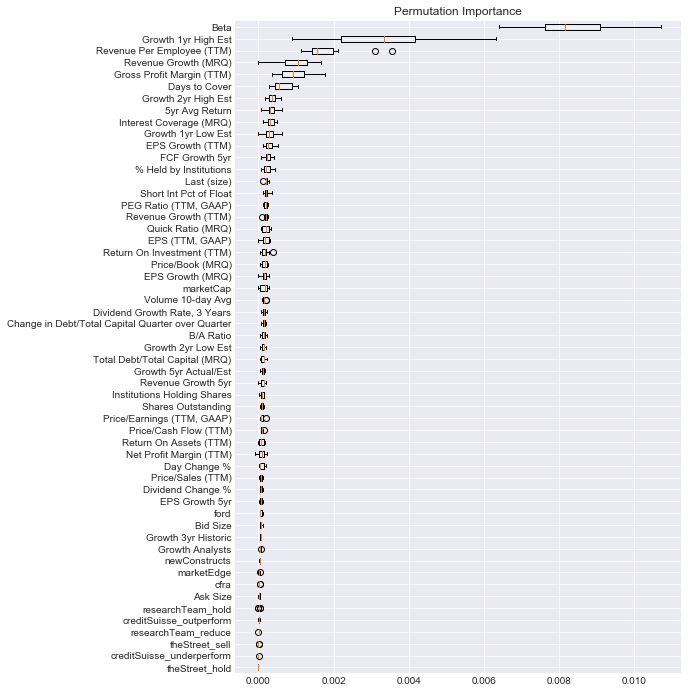

In [189]:
result = permutation_importance(grid_fit_new3.best_estimator_, 
                                X_reduced, 
                                targets.class2, 
                                scoring='roc_auc',
                                n_repeats=10,
                                random_state=42, 
                                n_jobs=-1)
sorted_idx = result.importances_mean.argsort()
fig = plt.figure(figsize=(8,12))
plt.subplot(1, 1, 1)
plt.boxplot(result.importances[sorted_idx].T,
            vert=False, labels=np.array(X_reduced.columns)[sorted_idx])
plt.title("Permutation Importance")
plt.show()

In [181]:
combined = pd.DataFrame()
y = targets.class2

for i in range(100):
    X_train, X_test, y_train, y_test = train_test_split(X_reduced, targets.class2, test_size=.2)
    scaler = StandardScaler()
    #imputer = KNNImputer(weights='distance', add_indicator=False)

    clf = XGBRFClassifier(colsample_bynode=0.6,
                          colsample_bytree=0.6,
                          learning_rate=1,
                          max_depth=7,
                          n_estimators=300,
                          reg_alpha=0,
                          reg_lambda=0.25,
                          subsample=0.8,
                          n_jobs=-1, 
                          random_state=0
                         )

    steps = [('scaler', scaler),
             #('imputer', imputer),
             ('clf', clf)
            ]
    est = Pipeline(steps=steps)
    est.fit(X_train, y_train)
    result = permutation_importance(est, 
                                    X_train, 
                                    y_train, 
                                    scoring='roc_auc',
                                    n_repeats=10, 
                                    n_jobs=-1)
    temp = pd.DataFrame(result.importances)
    combined = pd.concat([combined, temp], axis = 1)

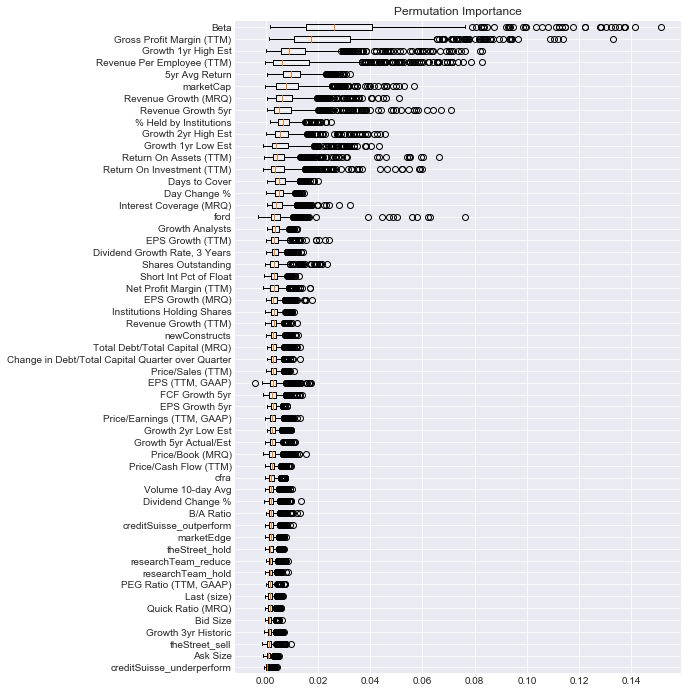

In [182]:
sorted_idx = combined.mean(axis=1).argsort()
fig = plt.figure(figsize=(8,12))
plt.subplot(1, 1, 1)
plt.boxplot(combined.iloc[sorted_idx],
            vert=False, labels=np.array(X_reduced.columns)[sorted_idx])
plt.title("Permutation Importance")
plt.show()

## SVM Classification

In [190]:
from sklearn import svm

In [191]:
# SVMs work with both dense and sparse data, so we can do another comparative study between
# imputation methods and allowing the algorithm to train with missing data.

In [202]:
clf = svm.SVC(kernel='poly', degree=3)

In [ ]:
N_SPLITS = 5
scoring = 'roc_auc'

zero_scores = get_impute_zero_score(X_reduced, y, clf, scoring)
mean_scores = get_impute_mean(X_reduced, y, clf, scoring)
knn_scores = get_impute_knn_score(X_reduced, y, clf, scoring)
iter_scores = get_impute_iterative(X_reduced, y, clf, scoring)

In [194]:
scores = [zero_scores[0], mean_scores[0], knn_scores[0], iter_scores[0]]
stds = [zero_scores[1], mean_scores[1], knn_scores[1], iter_scores[1]]

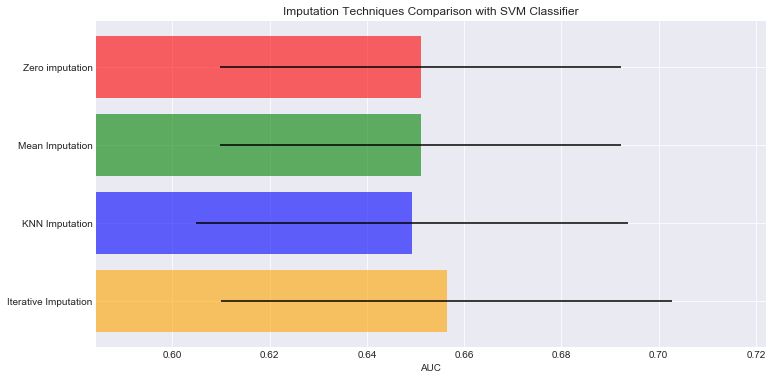

In [196]:
n_bars = len(scores)
xval = np.arange(n_bars)

x_labels = ['Zero imputation',
            'Mean Imputation',
            'KNN Imputation',
            'Iterative Imputation']
colors = ['r', 'g', 'b', 'orange', 'black']

# plot diabetes results
plt.figure(figsize=(12, 6))
ax1 = plt.subplot(111)
for j in xval:
    ax1.barh(j, scores[j], xerr=stds[j],
             color=colors[j], alpha=0.6, align='center')

ax1.set_title('Imputation Techniques Comparison with SVM Classifier')
ax1.set_xlim(left=np.min(scores*2) * 0.9,
             right=np.max(scores*2) * 1.1)
ax1.set_yticks(xval)
ax1.set_xlabel('AUC')
ax1.invert_yaxis()
ax1.set_yticklabels(x_labels)

plt.show()

In [197]:
# These scores are not very exciting, and also have high variance. Hyperparameter tuning would
# probably help. Let's look at more imputation first

In [198]:
estimators

[BayesianRidge(),
 DecisionTreeRegressor(max_features='sqrt', random_state=123),
 ExtraTreesRegressor(max_features='sqrt', n_estimators=10, random_state=123),
 KNeighborsRegressor(n_neighbors=15)]

In [199]:
results = []

for estimator in estimators:
    results.append(get_impute_iterative(X_reduced,
                                       y,
                                       clf,
                                       scoring,
                                       estimator
                                      )
                 )

print(results)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impu

[(0.6540893691648911, 0.039332418341934544), (0.6469531981801151, 0.035407437496897426), (0.6475808423143832, 0.03141836290735365), (0.6503751646954677, 0.0399783929004751)]


In [200]:
scores = [results[i][0] for i in range(len(results))]
stds = [results[i][1] for i in range(len(results))]

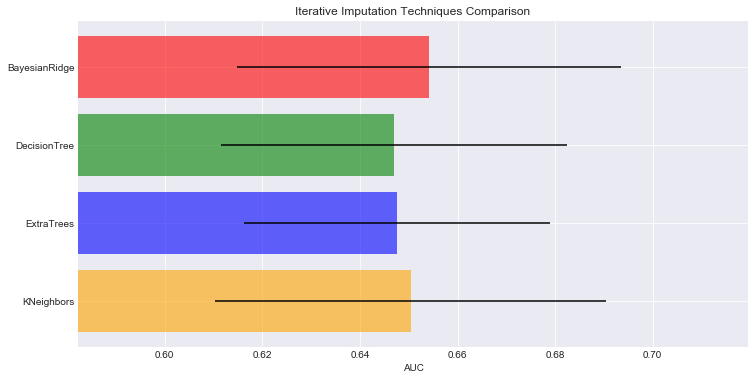

In [201]:
n_bars = len(scores)
xval = np.arange(n_bars)

x_labels = ['BayesianRidge', 
            'DecisionTree',
            'ExtraTrees', 
            'KNeighbors']
colors = ['r', 'g', 'b', 'orange', 'black']

# plot diabetes results
plt.figure(figsize=(12, 6))
ax1 = plt.subplot(111)
for j in xval:
    ax1.barh(j, scores[j], xerr=stds[j],
             color=colors[j], alpha=0.6, align='center')

ax1.set_title('Iterative Imputation Techniques Comparison')
ax1.set_xlim(left=np.min(scores*2) * 0.9,
             right=np.max(scores*2) * 1.1)
ax1.set_yticks(xval)
ax1.set_xlabel('AUC')
ax1.invert_yaxis()
ax1.set_yticklabels(x_labels)

plt.show()

## Regression on the reduced feature set
Earlier, we had lackluster performance using regressors to model the returns of the last 6 months using our input data. But, since then, we have performed some careful feature selection, and removed strong collinearity from the feature set. It is worthwhile at this point to see if we can get better regression performance using our trimmed feature set, and possibly try some feature combination and polynomials.

# Conclusions
In this notebook, we looked at modeling targets related to the returns of the companies in the S&P 500 in the 6 months since the data scrape on May 8th, 2020.

In [ ]:
{'clf__colsample_bynode': 0.6,
 'clf__colsample_bytree': 1.0,
 'clf__learning_rate': 0.01,
 'clf__max_depth': 5,
 'clf__n_estimators': 100,
 'clf__reg_alpha': 0,
 'clf__reg_lambda': 0.25,
 'clf__subsample': 0.8}

In [297]:
# Let's see what some dimensionality reduction would do..
from sklearn.decomposition import PCA

In [301]:
# PCA only really works for continuous features, so we will need to drop those categorical
# variables from earlier
X_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 499 entries, A to ZTS
Data columns (total 82 columns):
% Held by Institutions                               493 non-null float64
5yr Avg Return                                       499 non-null float64
5yr High                                             499 non-null float64
5yr Low                                              499 non-null float64
Annual Dividend %                                    392 non-null float64
Ask                                                  492 non-null float64
Ask Size                                             490 non-null float64
B/A Ratio                                            490 non-null float64
Beta                                                 486 non-null float64
Bid                                                  497 non-null float64
Bid Size                                             490 non-null float64
Change in Debt/Total Capital Quarter over Quarter    471 non-null float64
Closing Pric

In [318]:
X_cont = X_new.drop(columns=['creditSuisse_outperform',
                            'creditSuisse_underperform',
                            'researchTeam_hold',
                            'researchTeam_reduce',
                            'theStreet_hold',
                            'theStreet_sell'
                           ]).copy()

In [309]:
X_pca.info()

<class 'pandas.core.frame.DataFrame'>
Index: 499 entries, A to ZTS
Data columns (total 76 columns):
% Held by Institutions                               493 non-null float64
5yr Avg Return                                       499 non-null float64
5yr High                                             499 non-null float64
5yr Low                                              499 non-null float64
Annual Dividend %                                    392 non-null float64
Ask                                                  492 non-null float64
Ask Size                                             490 non-null float64
B/A Ratio                                            490 non-null float64
Beta                                                 486 non-null float64
Bid                                                  497 non-null float64
Bid Size                                             490 non-null float64
Change in Debt/Total Capital Quarter over Quarter    471 non-null float64
Closing Pric

In [319]:
scaler = StandardScaler()
imputer = SimpleImputer(strategy='constant', fill_value=0)
X_scaled = scaler.fit_transform(X_cont)
X_imputed = imputer.fit_transform(X_scaled)
pca = PCA(whiten=True)
X_pca = pca.fit_transform(X_imputed)

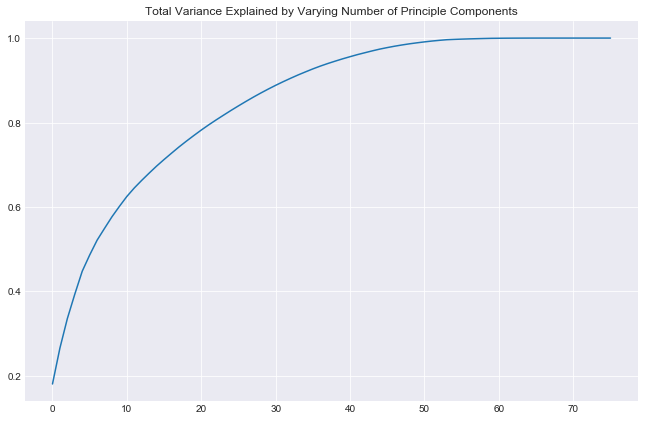

In [320]:
plt.plot(range(len(X_cont.columns)), pca.explained_variance_ratio_.cumsum())
plt.title('Total Variance Explained by Varying Number of Principle Components');

In [347]:
# Let's see how applying PCA to the data affects the model performance
scaler = StandardScaler()

imputer = SimpleImputer(strategy='constant', fill_value=0)

pca = PCA()

clf = XGBClassifier(random_state=0, n_jobs=-1)

steps = [('scaler', scaler),
         ('imputer', imputer),
         ('pca', pca),
         ('clf', clf)
        ]
estimator = Pipeline(steps=steps)

param_grid = {'pca__n_components': [35, 40, 50]
             }

grid_search = GridSearchCV(estimator, 
                           param_grid=param_grid, 
                           scoring='roc_auc', 
                           cv=5,
                           n_jobs=-1,
                           verbose=2
                          )
grid_fit2 = grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:    0.7s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    1.1s finished


In [348]:
grid_fit2.best_score_

0.6137166966328864

In [351]:
grid_fit2.best_params_

{'pca__n_components': 50}

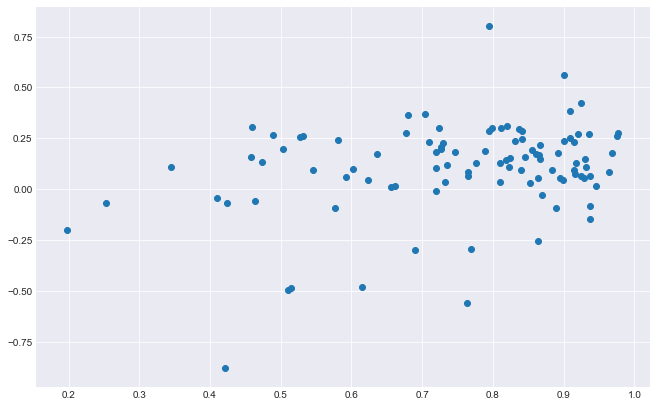

In [350]:
pred_probas = grid_fit2.best_estimator_.predict_proba(X_test)
plt.scatter(pred_probas[:, 1], targets.loc[y_test.index, 'log_return'])